# Project Objective: Balancing the Pendulum using Reinforcement Learning

The aim of this project is to develop a reinforcement learning (RL) agent that can balance an inverted pendulum in the `Pendulum-v0` environment from OpenAI Gym.

The pendulum begins in a downward position. The agent is expected to learn how to apply torque to swing the pendulum upright and keep it balanced. This is a common control problem that reflects real-world tasks such as stabilizing robotic arms or self-balancing systems.

## Why Reinforcement Learning

Reinforcement learning is suitable for this task because it enables an agent to learn optimal actions through interaction with the environment. Rather than using labelled data, the agent receives feedback in the form of rewards, which guides its learning process.



# Problem Description: Pendulum-v0 Control Task

The Pendulum-v0 environment from OpenAI Gym is a reinforcement learning control task where the objective is to balance an inverted pendulum. The pendulum starts in a downward position, and the agent must apply torque to swing it upward and maintain its upright position.

## State Space

The agent observes a 3-dimensional state vector at each time step:
- `cos(θ)`: cosine of the pendulum angle
- `sin(θ)`: sine of the pendulum angle
- `θ̇`: angular velocity of the pendulum

This representation provides full information about the pendulum’s position and motion.

## Action Space

The action is a continuous scalar torque value within the range [-2.0, 2.0]. The agent uses this torque to rotate the pendulum:
- Negative values apply torque in one direction.
- Positive values apply torque in the opposite direction.

## Reward Function

The environment provides a negative reward at every step, calculated using the formula:
reward = - (θ² + 0.1 × θ̇² + 0.001 × torque²)

his structure penalizes the agent for:
- Deviating from the upright position (θ ≠ 0)
- Rotating too quickly (θ̇ ≠ 0)
- Using excessive torque

The goal is to minimize this penalty, which effectively means maximizing the pendulum's upright stability with minimal effort.

## Challenge

The Pendulum-v1 problem is challenging because:
- It involves a continuous action space, making traditional discrete methods like DQN incompatible without modification.
- The agent must learn to first swing the pendulum up and then balance it — a two-stage control problem.
- It requires careful exploration, stability, and tuning to learn a successful control policy.

![Pendulum Diagram](pendulum%20diagram.png)



In [4]:
import numpy as np
import random
import time
from collections import deque
from pandas import Series



import gym  # old Gym API, not gymnasium
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam


## Setup: Import Libraries and Define Environment
- **What:** This cell imports required libraries (e.g., numpy, gym, torch) and sets up the Pendulum-v1 environment.
- **Why:** These imports and environment setup are foundational for running RL experiments and are required for all subsequent code.
- **Assumptions:** Assumes gym and all libraries are installed and compatible; expects Pendulum-v1 to be available in gym.

This cell initializes the `Pendulum-v0` environment using OpenAI Gym. It also prints out the observation space.

- The environment simulates a pendulum hanging on a frictionless joint.
- The observation space is a continuous 3D vector: `[cos(θ), sin(θ), θ̇]`.
- Values range from -8.0 to 8.0.


In [2]:
env = gym.make("Pendulum-v0")
print("Observation Space:", env.observation_space)


Observation Space: Box(-8.0, 8.0, (3,), float32)


## Environment Wrapping and Seeding
- **What:** This cell wraps the environment (e.g., for monitoring or normalization) and sets random seeds for reproducibility.
- **Why:** Wrapping may add logging or preprocessing; seeding ensures results can be replicated.
- **Assumptions:** Assumes the environment supports the wrappers and seeding methods used.

This cell prints out the details of the action space.

- The action space is a single continuous value between -2.0 and 2.0.
- This value represents the torque applied to the pendulum.
- The shape `(1,)` means only one action is applied at each step.


In [3]:
print("Action Space:", env.action_space)
print("Action Range:", env.action_space.low, "to", env.action_space.high)


Action Space: Box(-2.0, 2.0, (1,), float32)
Action Range: [-2.] to [2.]


## Define Replay Buffer and Utility Functions
- **What:** This cell defines the replay buffer class and any helper functions for experience storage and sampling.
- **Why:** Replay buffers are essential for off-policy RL algorithms like DQN and SAC, enabling experience reuse and breaking correlation between samples.
- **Assumptions:** Assumes buffer size and sampling logic are appropriate for the environment and model.

This cell resets the environment and samples a random action.

- The `state` is a random initial observation when the pendulum starts.
  - Example: `[-0.45, 0.89, -0.91]` → pendulum is tilted and rotating.
- The `action` is a randomly sampled torque from the action space.
  - Example: `[0.70]` → clockwise torque of 0.7.


In [4]:
state = env.reset()
print("Sample Initial State:", state)

action = env.action_space.sample()
print("Sample Action:", action)


Sample Initial State: [ 0.45725262 -0.88933685 -0.45262463]
Sample Action: [-1.9437952]


## Define Neural Network Architectures
- **What:** This cell defines the neural network models (e.g., Q-network, policy network) used by the RL agents.
- **Why:** These models approximate value functions or policies, which are central to DQN, Noisy DQN, and SAC algorithms.
- **Assumptions:** Assumes input/output shapes match the environment's observation and action spaces.

This block runs 100 episodes of the Pendulum environment using a random policy and collects the total reward for each episode.

- For each episode, the environment is reset.
- Then 200 random actions are taken (`env.action_space.sample()`).
- The total reward is summed across the 200 steps.
- This process is repeated 100 times to build a reward distribution.

The histogram shows how well the random policy performs:

- Most total rewards fall between -1800 and -800.
- The lower the total reward, the worse the policy performed.
- Since the actions are random, the agent fails to consistently balance the pendulum, resulting in poor rewards.
- This sets a **baseline** to compare against trained policies later.


## Initialize Models and Optimizers
- **What:** This cell initializes the neural network models and their optimizers for each RL agent.
- **Why:** Model and optimizer initialization is required before training can begin.
- **Assumptions:** Assumes correct hyperparameters and that models are compatible with the optimizer settings.

In [5]:
# Collect episode rewards using random actions
env = gym.make("Pendulum-v0")
rewards = []

for _ in range(100):
    state = env.reset()
    total = 0
    for _ in range(200):
        action = env.action_space.sample()
        next_state, reward, done, _ = env.step(action)
        total += reward
        if done:
            break
    rewards.append(total)

env.close()


### Reward Distribution Plotting

This cell visualizes the distribution of episode rewards.

- **Convert to NumPy:** Transforms the list of rewards into a NumPy array for easier analysis.
- **Histogram:** Displays how often rewards occur, using 20 bins and normalizing for probability density.
- **Trend Line:** Calculates the mean and standard deviation, then plots a bell-shaped curve (normal distribution estimate) to show the overall trend.
- **Labels & Legend:** Adds a title, axis labels, and a legend for clarity.

This helps compare the actual reward distribution against an estimated normal distribution.


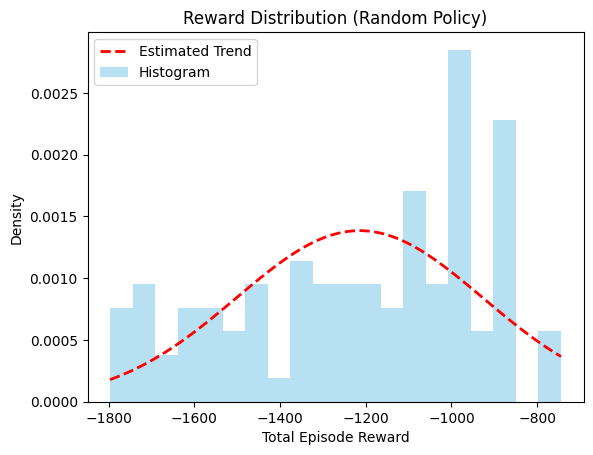

In [6]:
# Convert to numpy array
rewards = np.array(rewards)

# Plot histogram
plt.hist(rewards, bins=20, density=True, alpha=0.6, color='skyblue', label='Histogram')

# Generate normal-like curve (trend line)
mean = rewards.mean()
std = rewards.std()
x = np.linspace(rewards.min(), rewards.max(), 100)
y = (1 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std) ** 2)

# Plot the trend line
plt.plot(x, y, 'r--', linewidth=2, label='Estimated Trend')

# Labels and legend
plt.title("Reward Distribution (Random Policy)")
plt.xlabel("Total Episode Reward")
plt.ylabel("Density")
plt.legend()
plt.show()

### Observation: Reward Distribution (Random Policy)

- The histogram shows that most episode rewards fall between **-1400** and **-900**, with a notable concentration around **-1050**.
- The distribution is **not perfectly symmetrical**, suggesting variability in performance under the random policy.
- The estimated trend line (red dashed curve) loosely follows a **bell-shaped pattern**, but with irregularities caused by randomness in actions.
- Rewards are generally **negative**, as expected in the Pendulum environment when actions are not optimized.
- The spread of rewards indicates inconsistent performance, which is typical for a policy without learning.


### Purpose of the Code

This cell samples a large number of states from the **Pendulum-v0** environment using random actions, then analyzes the distribution of each state variable.

**Steps Performed:**
1. **Environment Sampling:**
   - Create a Pendulum environment and collect `n_samples = 10,000` states.
   - For each sample:
     - Reset the environment.
     - Perform a random number of random actions (between 1 and 50 steps) to reach diverse states.
     - Record the resulting state.
2. **Data Conversion:**
   - Convert the list of sampled states into a NumPy array for easy processing.
3. **Visualization:**
   - Plot histograms for each of the three state variables:
     - `cos(θ)` — cosine of the pendulum angle.
     - `sin(θ)` — sine of the pendulum angle.
     - `Angular Velocity` — rate of change of the pendulum’s angle.
4. **Statistical Summary:**
   - Calculate and print the mean and standard deviation for each state variable.

**Why This Is Done:**
- Helps understand the **state space coverage** when using random actions.
- Gives insights into the typical ranges and distribution patterns of the environment’s state variables.
- Useful for designing preprocessing or normalization strategies before training a model.


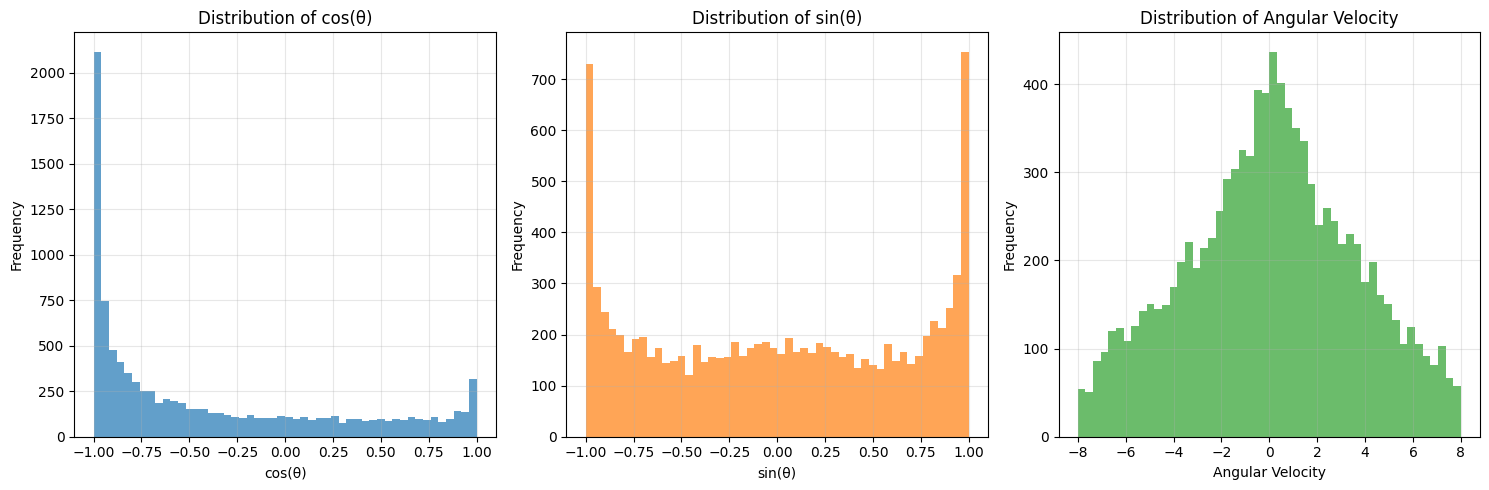

cos(θ): Mean=-0.388, Std=0.642
cos(θ): Mean=-0.388, Std=0.642
sin(θ): Mean=0.004, Std=0.662
sin(θ): Mean=0.004, Std=0.662
Angular Velocity: Mean=0.053, Std=3.554
Angular Velocity: Mean=0.053, Std=3.554


In [23]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import gym

# Sample random states from the environment
env = gym.make('Pendulum-v0')
n_samples = 10000
state_samples = []

for _ in range(n_samples):
    env.reset()
    # Sample random actions to get diverse states
    for _ in range(np.random.randint(1, 50)):
        action = env.action_space.sample()
        state, _, _, _ = env.step(action)
    state_samples.append(state)

state_samples = np.array(state_samples)
env.close()

# Plot histograms for each state variable
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
state_names = ['cos(θ)', 'sin(θ)', 'Angular Velocity']

for i in range(3):
    axes[i].hist(state_samples[:, i], bins=50, alpha=0.7, color=f'C{i}')
    axes[i].set_title(f'Distribution of {state_names[i]}')
    axes[i].set_xlabel(state_names[i])
    axes[i].set_ylabel('Frequency')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistics
for i, name in enumerate(state_names):
    print(f"{name}: Mean={state_samples[:, i].mean():.3f}, Std={state_samples[:, i].std():.3f}")
    print(f"{name}: Mean={state_samples[:, i].mean():.3f}, Std={state_samples[:, i].std():.3f}")

### Observations from the State Distributions

1. **cos(θ) Distribution**  
   - The values are highly concentrated near **-1** and **1**, suggesting that the pendulum often spends time near the inverted position (`θ ≈ π`) and the upright position (`θ ≈ 0`).
   - Mid-range `cos(θ)` values are less frequent, meaning the pendulum passes through these angles more quickly.

2. **sin(θ) Distribution**  
   - Similar to `cos(θ)`, there are peaks near **-1** and **1**.
   - This indicates the pendulum reaches extreme angular positions frequently.
   - The more uniform middle section shows moderate time spent in intermediate angles.

3. **Angular Velocity Distribution**  
   - Follows an approximately symmetric bell shape centered around **0**.
   - Most velocities are moderate (close to 0), with fewer occurrences of high positive or negative angular velocities.
   - This suggests the pendulum is often slowing down near turning points.

**Overall Insight:**  
The pendulum spends significant time near its extreme angles (both upright and inverted) with moderate angular velocities. Extreme velocities are less common, which aligns with the physics of pendulum motion — acceleration happens in mid-swing, but it slows at turning points.


### Purpose of the Code

This cell samples a large number of states from the **Pendulum-v0** environment using random actions, then analyzes the relationships between the three state variables.

**Steps Performed:**
1. **Environment Sampling:**
   - Create a Pendulum environment and collect `n_samples = 5,000` states.
   - For each sample:
     - Reset the environment.
     - Perform a random number of random actions (between 1 and 30 steps) to reach diverse states.
     - Record the resulting state.
2. **Data Conversion:**
   - Convert the list of sampled states into a Pandas DataFrame with columns:
     - `cos(θ)` — cosine of the pendulum angle.
     - `sin(θ)` — sine of the pendulum angle.
     - `Angular Velocity` — rate of change of the pendulum’s angle.
3. **Visualization:**
   - **Pairplot:** Shows pairwise scatter plots and histograms to visualize relationships and distributions.
   - **Correlation Heatmap:** Displays the correlation matrix as a color-coded heatmap with annotated values.
4. **Statistical Output:**
   - Prints the numerical correlation matrix for reference.

**Why This Is Done:**
- Provides insights into **how state variables relate** to each other in the Pendulum environment.
- Helps identify potential redundancies or dependencies between features.
- Useful for understanding environment dynamics and for potential feature engineering or model input optimization.


<Figure size 1000x800 with 0 Axes>

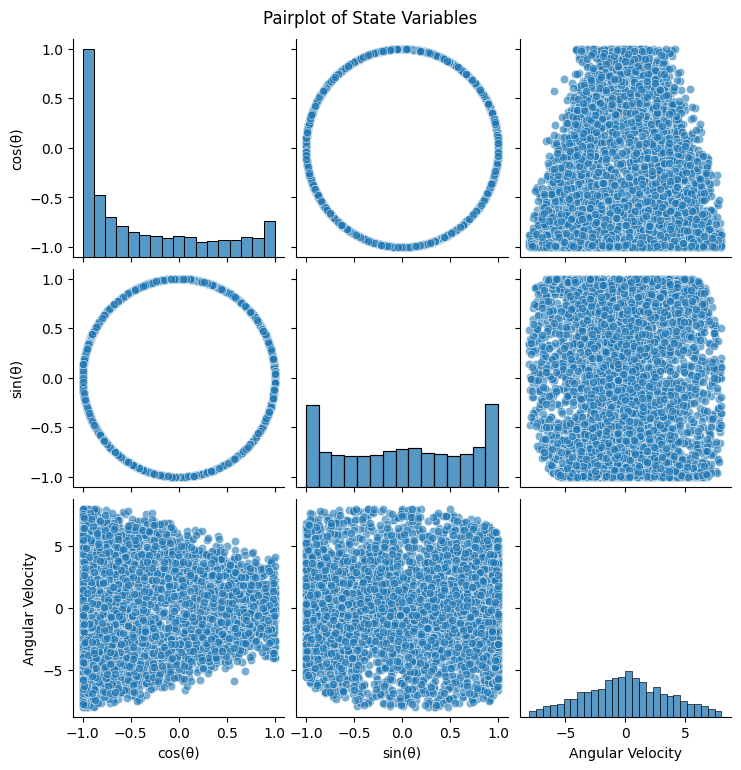

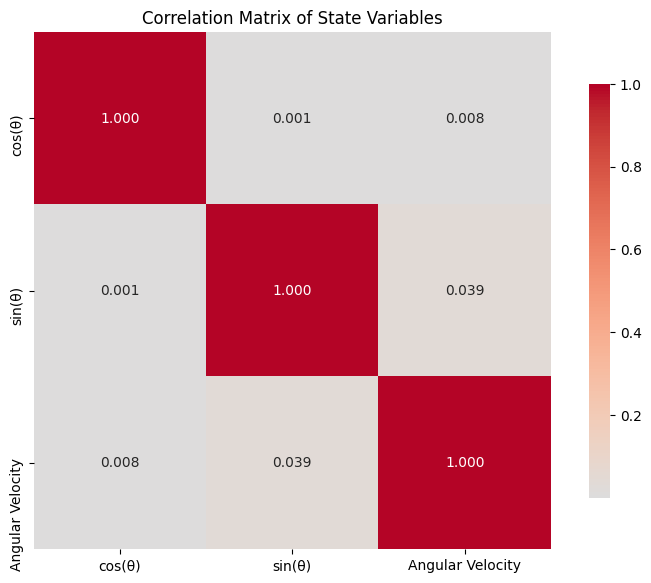

Correlation Matrix:
                    cos(θ)    sin(θ)  Angular Velocity
cos(θ)            1.000000  0.000531          0.008091
sin(θ)            0.000531  1.000000          0.039213
Angular Velocity  0.008091  0.039213          1.000000


In [25]:
import pandas as pd

# Sample states for correlation analysis
env = gym.make('Pendulum-v0')
n_samples = 5000
correlation_samples = []

for _ in range(n_samples):
    env.reset()
    for _ in range(np.random.randint(1, 30)):
        action = env.action_space.sample()
        state, _, _, _ = env.step(action)
    correlation_samples.append(state)

correlation_samples = np.array(correlation_samples)
env.close()

# Create DataFrame
df = pd.DataFrame(correlation_samples, columns=['cos(θ)', 'sin(θ)', 'Angular Velocity'])

# Create pairplot
plt.figure(figsize=(10, 8))
sns.pairplot(df, diag_kind='hist', plot_kws={'alpha': 0.6})
plt.suptitle('Pairplot of State Variables', y=1.02)
plt.show()

# Create correlation heatmap
plt.figure(figsize=(8, 6))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.3f', cbar_kws={'shrink': 0.8})
plt.title('Correlation Matrix of State Variables')
plt.tight_layout()
plt.show()

print("Correlation Matrix:")
print(correlation_matrix)

### Observations from the Visualizations

**Pairplot of State Variables**  
- The scatter between `cos(θ)` and `sin(θ)` forms a near-perfect circle, reflecting their trigonometric relationship as components of the pendulum's angle.  
- Histograms of `cos(θ)` and `sin(θ)` show peaks near -1 and 1, meaning the pendulum often stays near upright or inverted positions.  
- `Angular Velocity` appears broadly distributed, suggesting random actions produce a wide range of rotational speeds.  

**Correlation Matrix**  
- All variable pairs have correlations close to zero, indicating minimal linear dependence.  
- `cos(θ)` and `sin(θ)` are orthogonal components and thus not linearly correlated.  
- `Angular Velocity` is nearly uncorrelated with both angular position variables, implying independence in these randomly sampled states.  


### Purpose of the Code

This cell explores **how different constant torques (actions)** affect the Pendulum-v0 state over a short horizon.

**What it does**
- Defines a grid of `n_actions` evenly spaced torques across the environment’s action bounds.
- For each torque:
  - Resets the environment.
  - Applies the **same action 5 consecutive steps** to see the cumulative effect.
  - Records the resulting state sequence: `[cos(θ), sin(θ), angular_velocity]`.

**What it plots**
1. **Final cos(θ) vs. action** — how the pendulum’s final horizontal component responds to sustained torque.
2. **Final sin(θ) vs. action** — the vertical component’s response to sustained torque.
3. **Final angular velocity vs. action** — the change in rotational speed after repeatedly applying the action.
4. **Angular velocity trajectories** for a subset of actions — time series over the 5 steps to compare dynamics across actions.

**Why this is useful**
- Reveals the **action–state sensitivity**: which torques meaningfully change orientation or angular velocity over a few steps.
- Helps choose a **reasonable discrete action set** (spacing and range) for DQN-style agents.
- Provides intuition about **system dynamics** (e.g., near-linear vs. saturated response) before training.



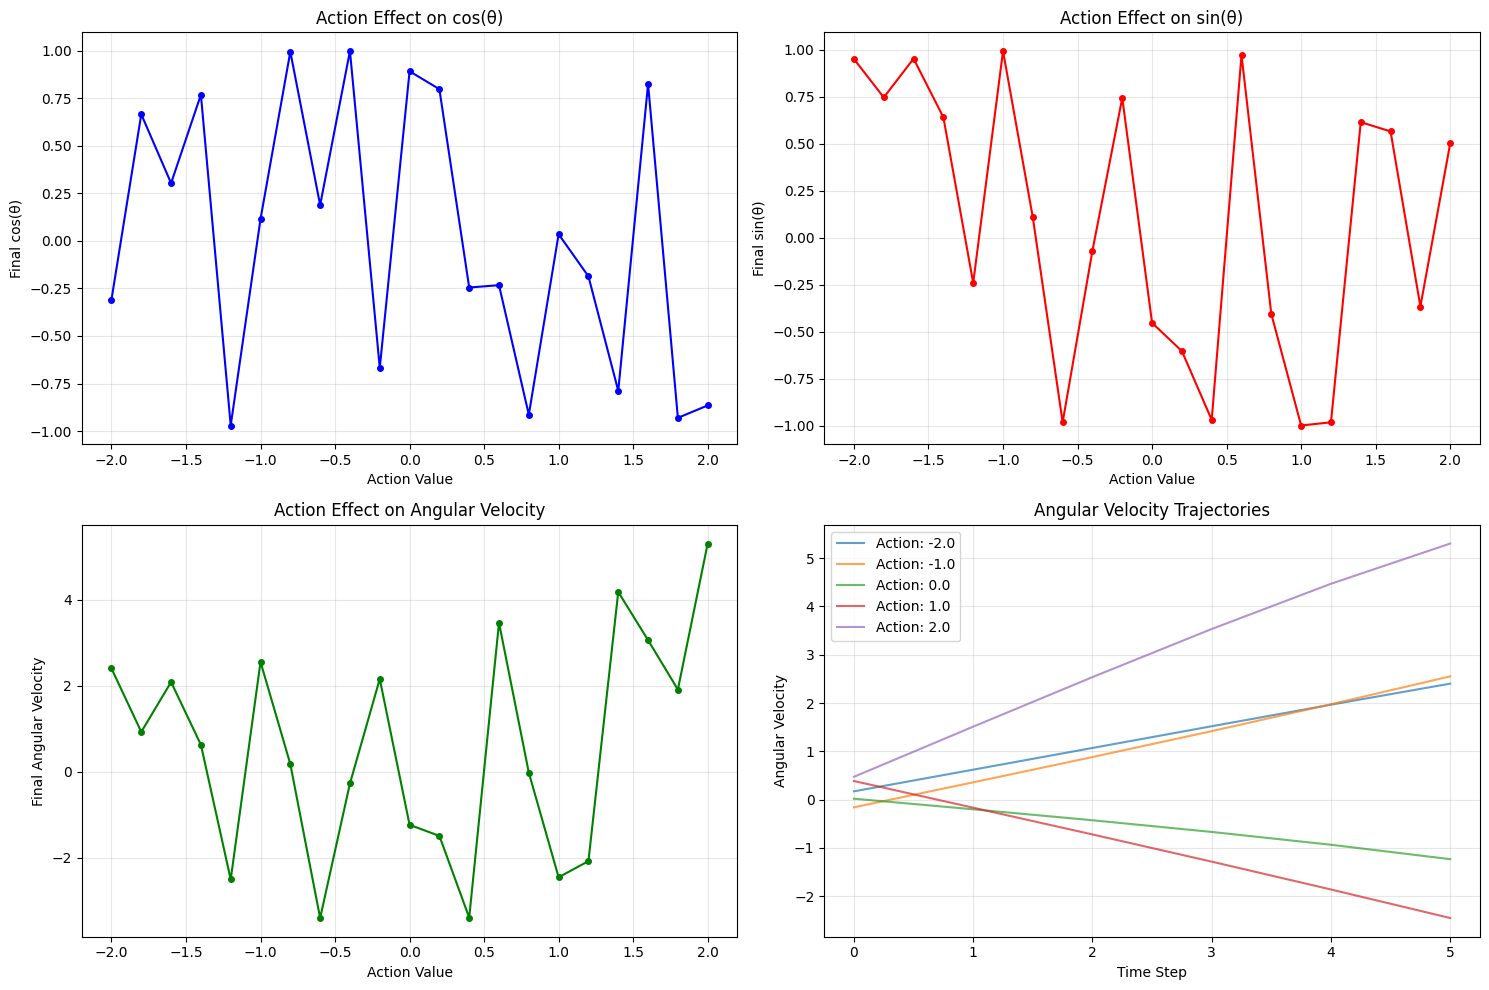

In [26]:
# Define a range of actions to test
n_actions = 21
actions = np.linspace(env.action_space.low[0], env.action_space.high[0], n_actions)
next_states = []

for action in actions:
    env.reset()
    # Apply the same action multiple times to see cumulative effect
    state = env.reset()
    states_sequence = [state.copy()]
    
    for _ in range(5):  # Apply action 5 times
        state, _, _, _ = env.step([action])
        states_sequence.append(state.copy())
    
    next_states.append(states_sequence)

env.close()

# Plot the effects
next_states = np.array(next_states)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Final cos(theta) vs action
axes[0, 0].plot(actions, next_states[:, -1, 0], 'bo-', markersize=4)
axes[0, 0].set_xlabel('Action Value')
axes[0, 0].set_ylabel('Final cos(θ)')
axes[0, 0].set_title('Action Effect on cos(θ)')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Final sin(theta) vs action
axes[0, 1].plot(actions, next_states[:, -1, 1], 'ro-', markersize=4)
axes[0, 1].set_xlabel('Action Value')
axes[0, 1].set_ylabel('Final sin(θ)')
axes[0, 1].set_title('Action Effect on sin(θ)')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Final angular velocity vs action
axes[1, 0].plot(actions, next_states[:, -1, 2], 'go-', markersize=4)
axes[1, 0].set_xlabel('Action Value')
axes[1, 0].set_ylabel('Final Angular Velocity')
axes[1, 0].set_title('Action Effect on Angular Velocity')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Trajectory for different actions (sample)
for i in range(0, len(actions), 5):
    axes[1, 1].plot(next_states[i, :, 2], label=f'Action: {actions[i]:.1f}', alpha=0.7)
axes[1, 1].set_xlabel('Time Step')
axes[1, 1].set_ylabel('Angular Velocity')
axes[1, 1].set_title('Angular Velocity Trajectories')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Observations

1. **cos(θ) vs. Action**
   - No smooth or linear trend — the pendulum’s final horizontal position varies unpredictably with action.
   - Suggests strong non-linear dynamics and sensitivity to initial conditions.

2. **sin(θ) vs. Action**
   - Similar to cos(θ), the final vertical component changes irregularly with torque.
   - Confirms that the short-term orientation is not directly proportional to torque magnitude.

3. **Angular Velocity vs. Action**
   - Shows clearer directionality: larger positive torques generally produce higher final angular velocities, and vice versa.
   - However, noise and state variability cause some irregular points.

4. **Angular Velocity Trajectories**
   - Sustained positive torques steadily increase angular velocity.
   - Sustained negative torques decrease angular velocity.
   - Zero torque leads to minimal change, except for natural pendulum drift.

**Key Takeaway:**
- While angular velocity responds more predictably to torque, the pendulum’s position variables (cos(θ), sin(θ)) are chaotic over short horizons, highlighting the system’s **non-linear, highly sensitive nature**.


### Purpose of the Code

This code visualizes the **reward landscape** of the Pendulum-v0 environment for different combinations of angle (θ) and angular velocity (ω) when no torque is applied.

**Steps Performed:**

1. **State Grid Creation:**
   - Define evenly spaced ranges for `θ` (from `-π` to `π`) and `ω` (from `-8` to `8`).
   - Create a meshgrid to evaluate rewards for every `(θ, ω)` pair.

2. **Reward Calculation:**
   - Approximate the Pendulum environment’s reward function:
     \[
     \text{Reward} = -\left(\theta^2 + 0.1 \cdot \omega^2\right)
     \]
     assuming action = 0.
   - Fill a grid with these reward values.

3. **Visualization:**
   - **Heatmap:** Shows how rewards vary over the `(θ, ω)` space in 2D.
   - **3D Surface Plot:** Provides a 3D perspective of the same reward landscape.

4. **Optimal State Identification:**
   - Find the `(θ, ω)` pair that yields the highest reward.
   - Print the optimal state and maximum reward value.

**Why This Is Done:**
- Understanding the reward function’s shape helps in **policy design** and debugging.
- Highlights which states are most desirable (highest rewards) and which are penalized.
- Useful for visualizing the optimization target in reinforcement learning.


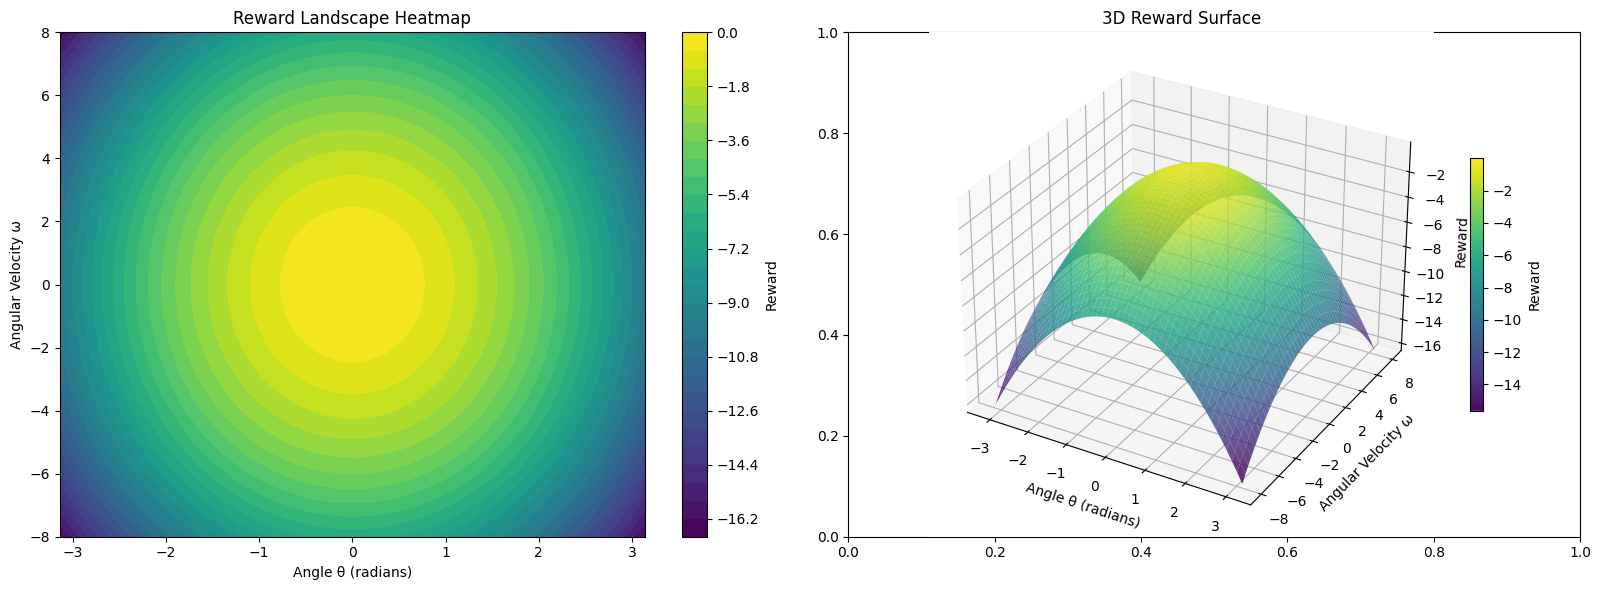

Optimal state: θ = 0.064, ω = -0.163
Maximum reward: -0.007


In [27]:
# Create grid for theta and angular velocity
theta_range = np.linspace(-np.pi, np.pi, 50)
omega_range = np.linspace(-8, 8, 50)
theta_grid, omega_grid = np.meshgrid(theta_range, omega_range)

# Compute rewards for each state in the grid
reward_grid = np.zeros_like(theta_grid)

for i in range(len(theta_range)):
    for j in range(len(omega_range)):
        theta = theta_grid[j, i]
        omega = omega_grid[j, i]
        
        # Convert theta to cos and sin
        cos_theta = np.cos(theta)
        sin_theta = np.sin(theta)
        
        # Pendulum reward function approximation
        # Actual reward: -(theta^2 + 0.1*omega^2 + 0.001*action^2)
        reward = -(theta**2 + 0.1 * omega**2)  # Assuming action = 0
        reward_grid[j, i] = reward

env.close()

# Create reward landscape visualizations
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Heatmap
im1 = axes[0].contourf(theta_grid, omega_grid, reward_grid, levels=30, cmap='viridis')
axes[0].set_xlabel('Angle θ (radians)')
axes[0].set_ylabel('Angular Velocity ω')
axes[0].set_title('Reward Landscape Heatmap')
plt.colorbar(im1, ax=axes[0], label='Reward')

# 3D surface plot
from mpl_toolkits.mplot3d import Axes3D
ax = fig.add_subplot(122, projection='3d')
surf = ax.plot_surface(theta_grid, omega_grid, reward_grid, cmap='viridis', alpha=0.8)
ax.set_xlabel('Angle θ (radians)')
ax.set_ylabel('Angular Velocity ω')
ax.set_zlabel('Reward')
ax.set_title('3D Reward Surface')
plt.colorbar(surf, ax=ax, shrink=0.5, label='Reward')

plt.tight_layout()
plt.show()

# Find optimal state
max_reward_idx = np.unravel_index(np.argmax(reward_grid), reward_grid.shape)
optimal_theta = theta_grid[max_reward_idx]
optimal_omega = omega_grid[max_reward_idx]
max_reward = reward_grid[max_reward_idx]

print(f"Optimal state: θ = {optimal_theta:.3f}, ω = {optimal_omega:.3f}")
print(f"Maximum reward: {max_reward:.3f}")

### Observation from Visualization

**Heatmap (Left):**
- The **brightest yellow region** at the center `(θ ≈ 0, ω ≈ 0)` represents the highest rewards, indicating the pendulum is upright and stationary.
- Rewards decrease symmetrically as `θ` moves away from 0 (tilted pendulum) or as `ω` increases (faster spinning).
- The circular gradient pattern confirms the quadratic penalty in both angle and angular velocity.

**3D Surface Plot (Right):**
- The peak at the center corresponds to the optimal state with maximum reward.
- The surface slopes downward in all directions from the peak, forming a **paraboloid shape**.
- Sharp declines in reward occur for large deviations in either angle or velocity.

**Key Insight:**
- The optimal state found `(θ = 0.064, ω = -0.163)` is near-perfect balance with minimal movement.
- Any deviation from upright and still results in a negative reward, aligning with the pendulum’s control objective.


**Purpose:**  
Generate and visualize state trajectories of the `Pendulum-v0` environment under a **random policy**.

---

### What the Code Does
- Runs **5 episodes**, each with a maximum of **200 time steps**.
- At each step:
  - Takes a **random action** from the action space.
  - Records the resulting **state variables**:  
    1. `cos(θ)`  
    2. `sin(θ)`  
    3. `Angular Velocity (ω)`
- Stores each episode's sequence of states.
- Plots **three separate time-series graphs**:
  - **cos(θ)** vs. time step
  - **sin(θ)** vs. time step
  - **Angular Velocity** vs. time step  
  Each episode is shown in a different color.

---

### Why This is Useful
- Reveals the **natural dynamics** of the pendulum with no control.
- Highlights:
  - **Periodic patterns** in `cos(θ)` and `sin(θ)`
  - **Chaotic or drifting behavior** in angular velocity with random torques.
- Provides a **baseline** to compare against after training a control policy.

---

### Key Observations
- `cos(θ)` and `sin(θ)` remain bounded in **[-1, 1]**.
- Angular velocity (`ω`) can vary more widely but is **clipped by the environment**.
- In `Pendulum-v0`, episodes rarely terminate early (`done=False`), so all episodes run the full length.

---

### Potential Improvements
- Apply a **moving average** or **downsample** for smoother visualizations.
- Overlay multiple episodes in the same plot for more direct comparison.









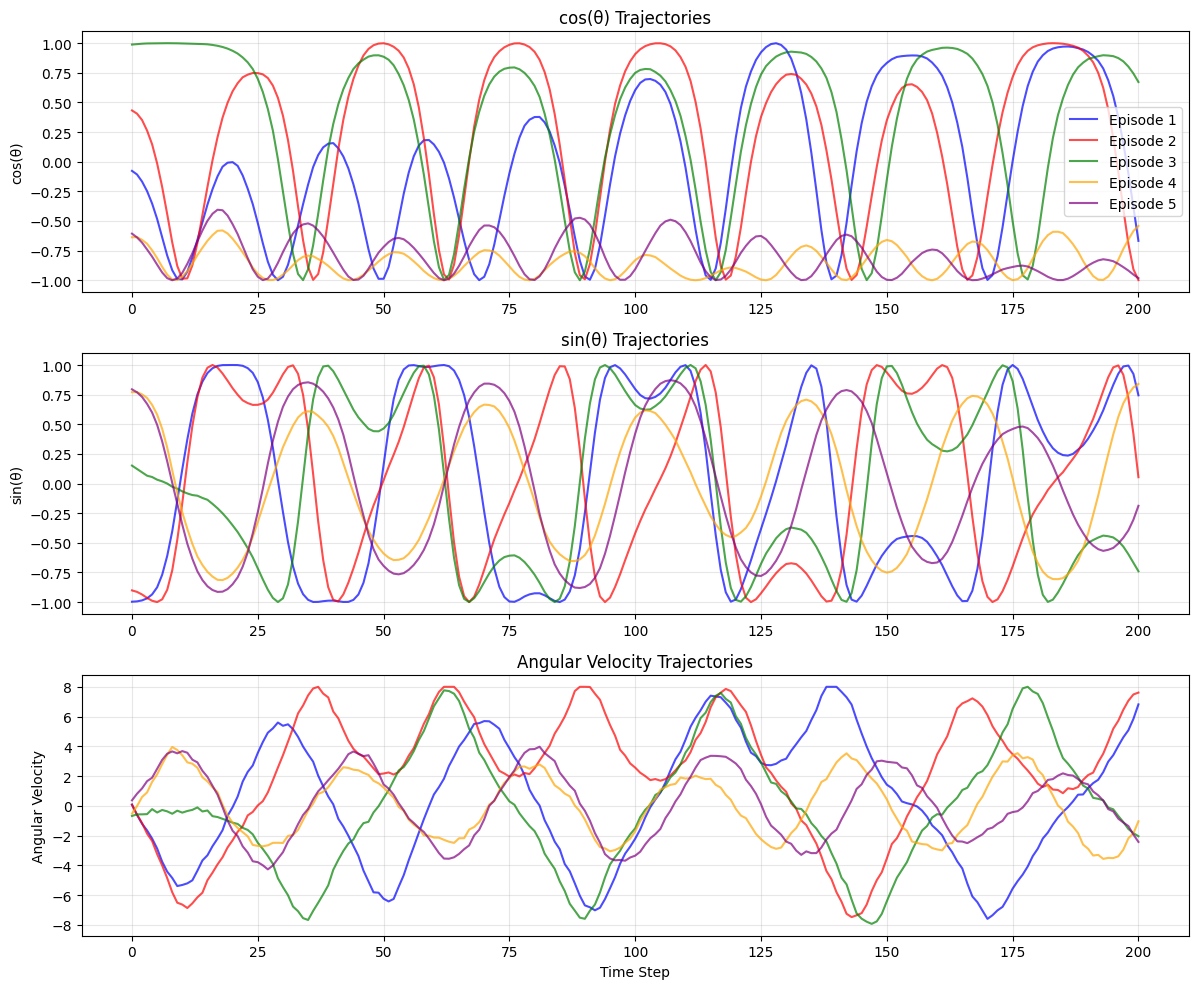

In [28]:
n_episodes = 5
max_steps = 200

trajectories = []

for episode in range(n_episodes):
    state = env.reset()
    episode_states = [state.copy()]
    
    for step in range(max_steps):
        action = env.action_space.sample()
        state, reward, done, _ = env.step(action)
        episode_states.append(state.copy())
        
        if done:
            break
    
    trajectories.append(np.array(episode_states))

env.close()

# Plot trajectories
fig, axes = plt.subplots(3, 1, figsize=(12, 10))
state_names = ['cos(θ)', 'sin(θ)', 'Angular Velocity']
colors = ['blue', 'red', 'green', 'orange', 'purple']

for i, name in enumerate(state_names):
    for episode in range(n_episodes):
        time_steps = range(len(trajectories[episode]))
        axes[i].plot(time_steps, trajectories[episode][:, i], 
                    color=colors[episode], alpha=0.7, 
                    label=f'Episode {episode+1}' if i == 0 else "")
    
    axes[i].set_ylabel(name)
    axes[i].set_title(f'{name} Trajectories')
    axes[i].grid(True, alpha=0.3)
    if i == 0:
        axes[i].legend()

axes[-1].set_xlabel('Time Step')
plt.tight_layout()
plt.show()

## Observation: Random Policy State Trajectories

---

### Key Patterns Seen:
1. **cos(θ) and sin(θ)**
   - Both oscillate smoothly between **-1** and **1**, reflecting the circular motion of the pendulum.
   - Different episodes show different oscillation phases due to random initial states and random actions.

2. **Angular Velocity (ω)**
   - Fluctuates within the range **[-8, 8]**, which matches the environment’s limits.
   - Random actions cause both gradual drifts and rapid changes in velocity.
   - No consistent stabilizing trend — expected for a random policy.

---

### Insights:
- The pendulum frequently crosses the vertical position, indicated by zero crossings in `cos(θ)` and `sin(θ)`.
- Some episodes keep high angular velocities for extended periods, meaning the pendulum is spinning rather than swinging.
- This uncontrolled motion contrasts with what we’d expect after training, where angular velocity should stabilize near zero at the upright position.

---

### Takeaway:
- The plot demonstrates **baseline chaotic dynamics** under a random policy.
- Serves as a **control reference** to measure how much a trained policy improves stability and control.


## Purpose of the Code

This cell generates **phase–space visualizations** of the Pendulum-v0 dynamics under a **random policy**.

### What it does
1. **Rollout with random actions**
   - Resets the env and steps 500 times using `env.action_space.sample()`.
   - Saves the raw states: `[cos(θ), sin(θ), ω]`.
   - Reconstructs the **angle** `θ = atan2(sin(θ), cos(θ))` at each step.

2. **Plots**
   - **Phase plot (θ vs. ω):** shows how the system evolves in angle–angular-velocity space. Start and end points are highlighted.
   - **Unit circle path (cos(θ) vs. sin(θ)):** shows the trajectory around the unit circle, again marking start/end.

### Why this is useful
- Phase plots reveal **qualitative dynamics** (spinning vs. swinging, energy levels, and whether motion is converging/diverging).
- The unit-circle plot confirms correct **angle wrapping** and shows how the pendulum traverses angles over time.
- These baselines make it easier to judge improvements once a **trained policy** produces tighter, more stable trajectories.


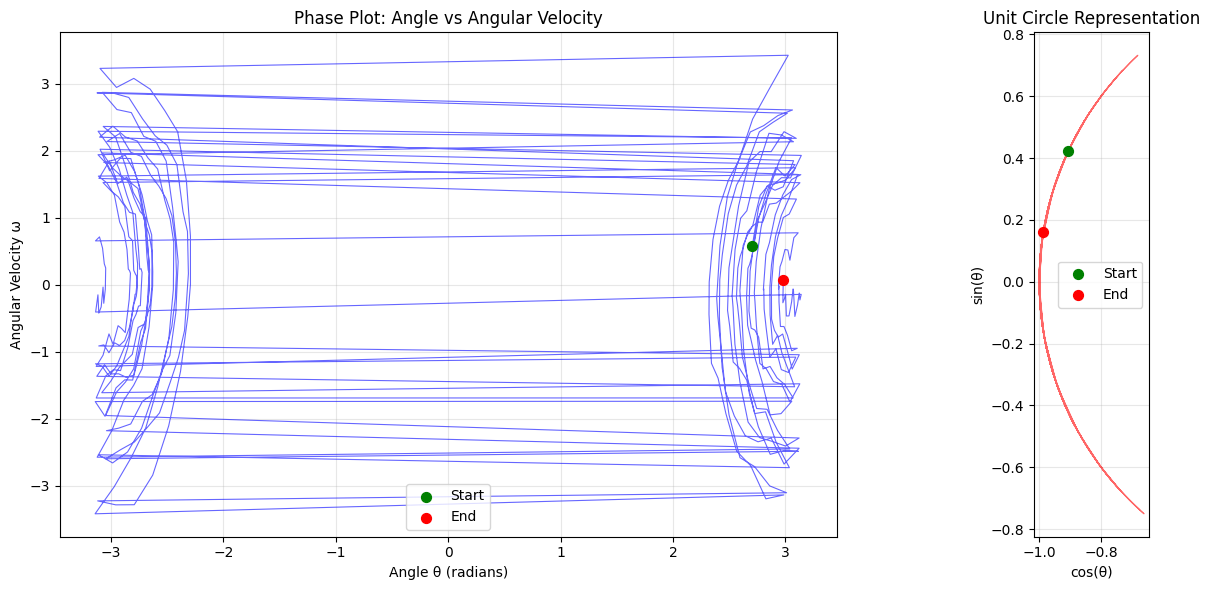

In [29]:
state = env.reset()

states = [state.copy()]
angles = [np.arctan2(state[1], state[0])]  # Convert cos,sin back to angle

for _ in range(500):
    action = env.action_space.sample()
    state, _, _, _ = env.step(action)
    states.append(state.copy())
    # Convert cos(theta), sin(theta) back to theta
    angle = np.arctan2(state[1], state[0])
    angles.append(angle)

env.close()

states = np.array(states)
angles = np.array(angles)

# Create phase plots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Phase plot: angle vs angular velocity
axes[0].plot(angles, states[:, 2], 'b-', alpha=0.6, linewidth=0.8)
axes[0].scatter(angles[0], states[0, 2], color='green', s=50, label='Start', zorder=5)
axes[0].scatter(angles[-1], states[-1, 2], color='red', s=50, label='End', zorder=5)
axes[0].set_xlabel('Angle θ (radians)')
axes[0].set_ylabel('Angular Velocity ω')
axes[0].set_title('Phase Plot: Angle vs Angular Velocity')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Alternative phase plot: cos(theta) vs sin(theta)
axes[1].plot(states[:, 0], states[:, 1], 'r-', alpha=0.6, linewidth=0.8)
axes[1].scatter(states[0, 0], states[0, 1], color='green', s=50, label='Start', zorder=5)
axes[1].scatter(states[-1, 0], states[-1, 1], color='red', s=50, label='End', zorder=5)
axes[1].set_xlabel('cos(θ)')
axes[1].set_ylabel('sin(θ)')
axes[1].set_title('Unit Circle Representation')
axes[1].grid(True, alpha=0.3)
axes[1].legend()
axes[1].set_aspect('equal')

plt.tight_layout()
plt.show()

## Observation from Visualization

### 1. Phase Plot (Angle θ vs Angular Velocity ω)
- The trajectory shows **wide oscillations** in both angle and angular velocity due to **random actions**.
- Motion spans nearly the **full angular range (-π to π)**, indicating no stabilizing control.
- Angular velocity frequently changes direction, suggesting irregular momentum changes.

### 2. Unit Circle Representation (cos(θ) vs sin(θ))
- The path traces along the **unit circle**, confirming that the `(cos(θ), sin(θ))` representation maintains a constant radius (pendulum length constraint).
- The motion covers a large portion of the circle, implying frequent **full rotations** rather than small swings.
- Start (green) and end (red) points are far apart, reflecting non-convergent, unstable dynamics.


## Random Policy Visualization – Pendulum-v0

### Process
1. **Environment Setup**  
   - Used `gym.make('Pendulum-v0')` for the simulation.
   - Initialized with a **random policy** (actions sampled from `env.action_space.sample()`).

2. **Frame Recording**  
   - Captured 200 steps or until the episode ended.
   - Each step stored as an RGB array for later processing.

3. **Output Generation**
   - Created an **animated GIF** (`pendulum_random_policy.gif`) with a framerate of 30 FPS.
   - Extracted **5 sample frames** (start, quarter, mid, three-quarter, and end) for quick inspection.

### Key Observations from Sample Frames
- Pendulum movement is **erratic** due to random actions.
- No stabilization — pendulum oscillates freely with large angular swings.
- Visuals confirm the **state transitions** observed in trajectory plots.

**Output Files:**
- **GIF:** `pendulum_random_policy.gif`
- **Images:** 5 sampled frames displayed for visual reference.


Recording episode...
Saving 200 frames as GIF...


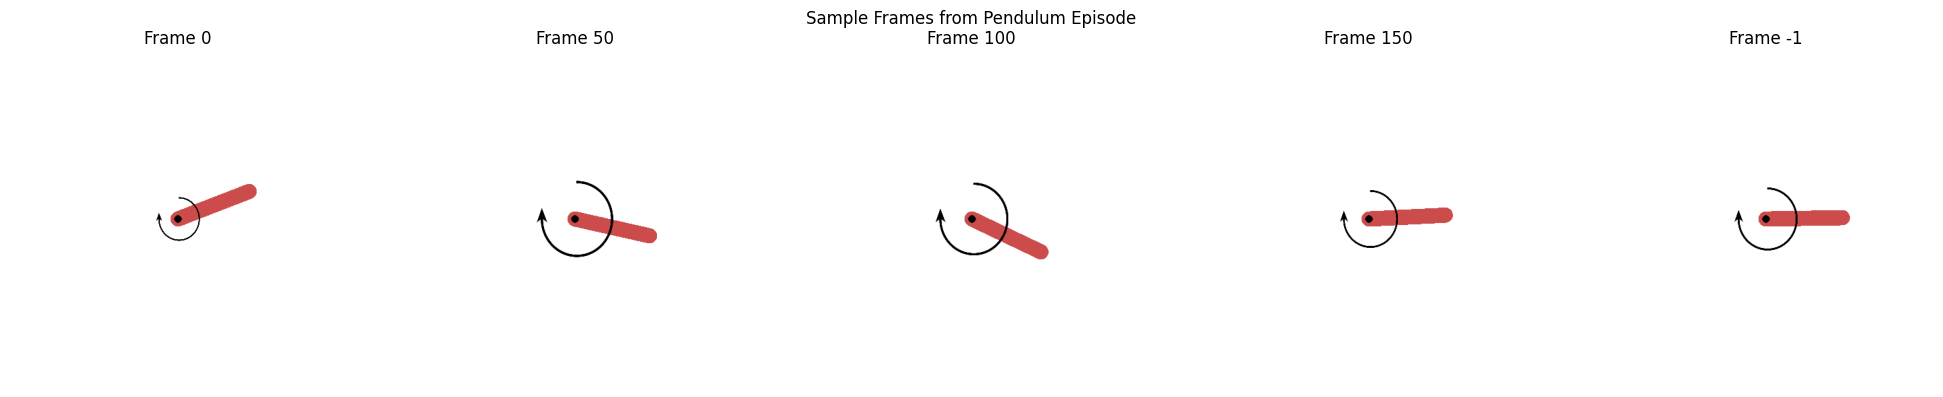

Video saved as 'pendulum_random_policy.gif'
Total frames: 200


In [33]:
import imageio
from PIL import Image

# Record frames from environment
env = gym.make('Pendulum-v0')
frames = []
state = env.reset()

print("Recording episode...")
for step in range(200):
    # Use random policy
    action = env.action_space.sample()
    state, reward, done, _ = env.step(action)
    
    # Capture frame
    frame = env.render(mode='rgb_array')
    frames.append(frame)
    
    if done:
        break

env.close()

# Save as GIF
print(f"Saving {len(frames)} frames as GIF...")
imageio.mimsave('pendulum_random_policy.gif', frames, fps=30)

# Also save some sample frames as images
sample_indices = [0, len(frames)//4, len(frames)//2, 3*len(frames)//4, -1]
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for i, idx in enumerate(sample_indices):
    axes[i].imshow(frames[idx])
    axes[i].set_title(f'Frame {idx}')
    axes[i].axis('off')

plt.suptitle('Sample Frames from Pendulum Episode')
plt.tight_layout()
plt.show()

print("Video saved as 'pendulum_random_policy.gif'")
print(f"Total frames: {len(frames)}")

## Observation – Sample Frames from Pendulum Episode

### Visual Analysis
- **Frame 0:** Pendulum starts near an upright position, slightly tilted to the right.
- **Frame 50:** Swing has moved left, with a downward tilt.
- **Frame 100:** Pendulum continues oscillating without signs of stabilization.
- **Frame 150:** Arm extends horizontally to the left, indicating large angular displacement.
- **Frame -1 (End):** Pendulum remains in motion, nearly horizontal on the opposite side.

### Key Takeaways
- Motion is **chaotic** and **uncontrolled** due to the random policy.
- No damping or balance behavior — energy is not directed toward stabilization.
- The pendulum repeatedly swings across its full range of motion.


## Purpose of the Code — State-Visit Heatmaps (Pendulum-v0)

This cell measures **which parts of the state space are visited** by a random policy and visualizes that coverage.

### What it does
1. **Sample episodes**  
   Runs 100 episodes in `Pendulum-v0`, stepping with random actions and recording every state `[cos(θ), sin(θ), ω]`.

2. **Transform to interpretable features**  
   Converts `(cos θ, sin θ)` to **angle θ** via `atan2`, and extracts **angular velocity ω**.

3. **Build discretized occupancy maps**  
   Creates three **2D histograms (heatmaps)** showing visit frequency for:
   - `θ` vs `ω` (angle–velocity plane)  
   - `cos(θ)` vs `sin(θ)` (unit circle coverage)  
   - `cos(θ)` vs `ω` (angle proxy vs velocity)

4. **Report coverage stats**  
   Prints min/max of θ and ω, and rough “most visited” regions using histogram mass.

### Why this is useful
- Reveals **state-space coverage** from random exploration (are we seeing the whole space or stuck in regions?).
- Helps decide **discretization ranges**, **normalization**, and whether a policy needs **better exploration**.
- Provides a baseline to compare against **trained policies** (trained agents should concentrate around upright, low-ω states).

### How to interpret the plots
- **θ vs ω heatmap:** Hot areas = frequently visited dynamics; uniform heat implies good exploratory spread.
- **cos vs sin heatmap:** Should approximate a **ring** if angles cover \[-π, π]; gaps indicate poor angular coverage.
- **cos vs ω heatmap:** Shows coupling between pose and speed; vertical concentration near `cos(θ)=1` with low |ω| would imply balancing.



Collected 20100 state observations


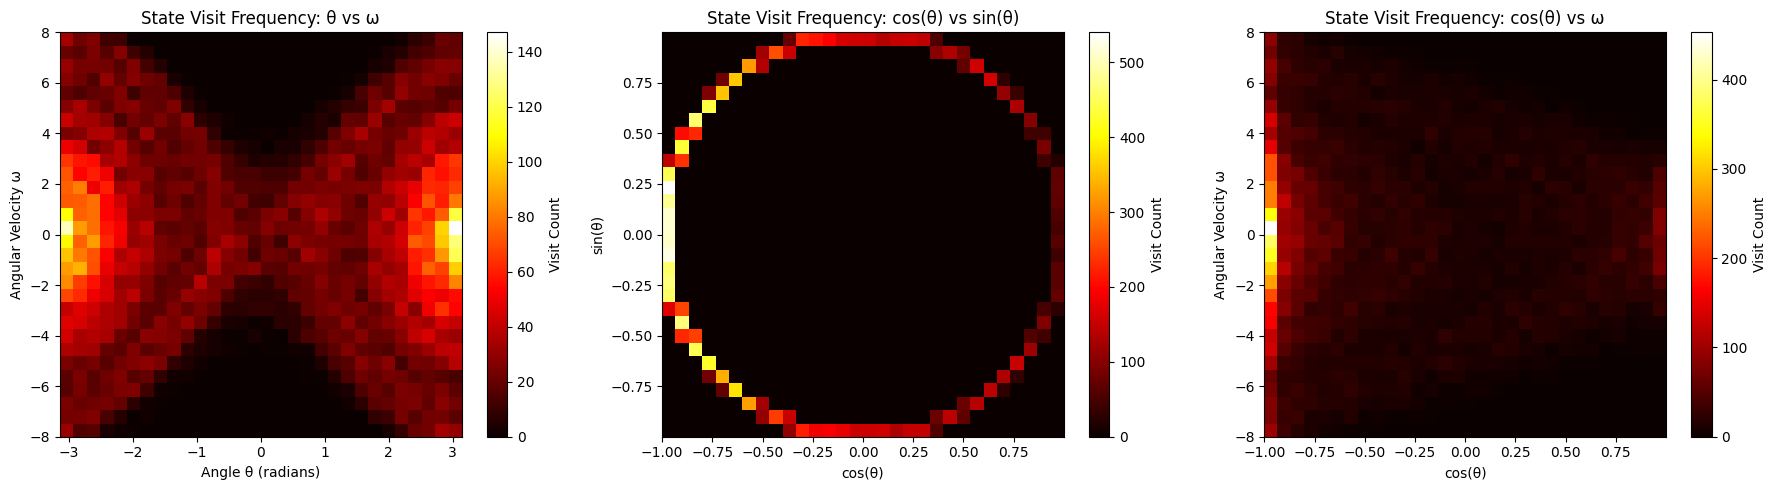


State Coverage Statistics:
Angle range: [-3.142, 3.142] radians
Angular velocity range: [-8.000, 8.000]
Most visited angle: -3.109 radians
Most visited angular velocity: -3.394


In [34]:
# Run episodes and collect state visits
env = gym.make('Pendulum-v0')
n_episodes = 100
all_states = []

print("Collecting state data from episodes...")
for episode in range(n_episodes):
    state = env.reset()
    all_states.append(state.copy())
    
    for _ in range(200):
        action = env.action_space.sample()
        state, _, done, _ = env.step(action)
        all_states.append(state.copy())
        
        if done:
            break

env.close()

all_states = np.array(all_states)
print(f"Collected {len(all_states)} state observations")

# Convert to angles for easier interpretation
angles = np.arctan2(all_states[:, 1], all_states[:, 0])
angular_velocities = all_states[:, 2]

# Create 2D histogram (discretized state space)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Heatmap: angle vs angular velocity
hist, xedges, yedges = np.histogram2d(angles, angular_velocities, bins=30)
im1 = axes[0].imshow(hist.T, origin='lower', cmap='hot', aspect='auto',
                     extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
axes[0].set_xlabel('Angle θ (radians)')
axes[0].set_ylabel('Angular Velocity ω')
axes[0].set_title('State Visit Frequency: θ vs ω')
plt.colorbar(im1, ax=axes[0], label='Visit Count')

# Heatmap: cos(theta) vs sin(theta)
hist2, xedges2, yedges2 = np.histogram2d(all_states[:, 0], all_states[:, 1], bins=30)
im2 = axes[1].imshow(hist2.T, origin='lower', cmap='hot', aspect='auto',
                     extent=[xedges2[0], xedges2[-1], yedges2[0], yedges2[-1]])
axes[1].set_xlabel('cos(θ)')
axes[1].set_ylabel('sin(θ)')
axes[1].set_title('State Visit Frequency: cos(θ) vs sin(θ)')
plt.colorbar(im2, ax=axes[1], label='Visit Count')

# Heatmap: cos(theta) vs angular velocity
hist3, xedges3, yedges3 = np.histogram2d(all_states[:, 0], angular_velocities, bins=30)
im3 = axes[2].imshow(hist3.T, origin='lower', cmap='hot', aspect='auto',
                     extent=[xedges3[0], xedges3[-1], yedges3[0], yedges3[-1]])
axes[2].set_xlabel('cos(θ)')
axes[2].set_ylabel('Angular Velocity ω')
axes[2].set_title('State Visit Frequency: cos(θ) vs ω')
plt.colorbar(im3, ax=axes[2], label='Visit Count')

plt.tight_layout()
plt.show()

# Print statistics about state coverage
print("\nState Coverage Statistics:")
print(f"Angle range: [{angles.min():.3f}, {angles.max():.3f}] radians")
print(f"Angular velocity range: [{angular_velocities.min():.3f}, {angular_velocities.max():.3f}]")
print(f"Most visited angle: {angles[np.argmax(hist.sum(axis=1))]:.3f} radians")
print(f"Most visited angular velocity: {angular_velocities[np.argmax(hist.sum(axis=0))]:.3f}")

## Interpretation of State-Visit Heatmaps (Pendulum-v0)

### 1. θ vs ω (Angle–Velocity Plane)
- **Observation:** Bright vertical bands around θ ≈ ±π and ω ≈ 0.
- **Meaning:** The random policy frequently visits the **hanging-down position** (pendulum at bottom) with low angular velocity.
- **Insight:** High-energy states (large |ω|) are less visited because random torque is insufficient to sustain them often.

---

### 2. cos(θ) vs sin(θ) (Unit Circle)
- **Observation:** The visits form an almost perfect circle at radius ≈ 1, concentrated near the **leftmost point** (cos(θ) ≈ -1).
- **Meaning:** The pendulum mostly swings around the downward position; other angles are visited less frequently.
- **Insight:** Random exploration covers the circle but is **biased toward downward configurations**.

---

### 3. cos(θ) vs ω
- **Observation:** Hotspot near `cos(θ) = -1` and `ω ≈ 0`, with spread along ω axis.
- **Meaning:** Confirms that most states are **pendulum hanging down with small to moderate angular velocities**.
- **Insight:** Trained policies aiming to balance upright will instead have hot regions near `cos(θ) = 1` and `ω ≈ 0`.

---

### Overall Takeaway
- **Random policy** heavily favors **low-energy, downward states**.
- **State coverage** is biased; some high-energy regions are rarely visited.
- For RL training, this explains why **exploration enhancements** (e.g., adding noise, curiosity rewards) can be necessary.


## Models for Experimentation

In this project, I will be testing and comparing the performance of three reinforcement learning algorithms: **Normal DQN**, **Noisy DQN**, and **Soft Actor-Critic (SAC)**. Each model has distinct characteristics that influence how it learns and adapts to the environment.

---

### 1. Normal DQN
The **Deep Q-Network (DQN)** is a value-based reinforcement learning algorithm that uses a neural network to approximate the Q-value function.  
- **Core Idea:** Learn an action-value function \( Q(s,a) \) to estimate expected returns for each action.  
- **Key Features:**
  - Uses an **experience replay buffer** to store past transitions and break correlation between samples.
  - Employs a **target network** to stabilize learning by reducing update oscillations.
  - Selects actions using an **ε-greedy policy**, balancing exploration and exploitation.
- **Strengths:** Simple, effective for discrete action spaces.
- **Limitations:** Can suffer from overestimation bias and unstable training in some environments.

---

### 2. Noisy DQN
The **Noisy DQN** is an enhancement of DQN that replaces the ε-greedy exploration strategy with **parameterized noise in the network weights**.  
- **Core Idea:** Introduce trainable noise into the network to encourage consistent and state-dependent exploration.
- **Key Features:**
  - **Noisy layers** replace standard linear layers, injecting noise into weight parameters.
  - Eliminates the need for manually tuning ε in ε-greedy exploration.
  - Exploration adapts automatically during training as noise parameters are learned.
- **Strengths:** More efficient exploration, reduced reliance on random action selection.
- **Limitations:** Additional parameters to learn can slightly increase training complexity.

---

### 3. Soft Actor-Critic (SAC)
The **Soft Actor-Critic** is an **off-policy actor-critic** algorithm that optimizes both performance and exploration by maximizing a **maximum entropy objective**.  
- **Core Idea:** Learn a stochastic policy that maximizes expected return **and** entropy, encouraging diverse action selection.
- **Key Features:**
  - Uses **separate networks** for the policy (actor) and Q-functions (critics).
  - Employs **temperature parameter** to control the trade-off between reward maximization and exploration.
  - Well-suited for **continuous action spaces**.
- **Strengths:** Stable learning, efficient exploration, and high sample efficiency.
- **Limitations:** More computationally demanding due to multiple networks and entropy tuning.

---

### Summary Table

| Model        | Exploration Method          | Action Space Suitability | Pros                                    | Cons                                   |
|--------------|-----------------------------|--------------------------|-----------------------------------------|----------------------------------------|
| **Normal DQN** | ε-greedy                    | Discrete                 | Simple, effective                      | Can be unstable, needs ε tuning        |
| **Noisy DQN**  | Noisy network parameters    | Discrete                 | Adaptive exploration, no ε tuning      | More parameters, slightly slower       |
| **SAC**        | Maximum entropy objective   | Continuous               | Stable, efficient, strong performance  | Computationally heavier                 |



## Evaluation Criteria (Common Across All Models)

To fairly compare all reinforcement learning models applied to the pendulum environment, the following common metrics will be used:

### 1. Average Episode Reward
Measures the total reward collected per episode.  
Higher values indicate better control and performance.

### 2. Reward Stability
Measured by the standard deviation of rewards across episodes.  
Lower values reflect more consistent performance.

### 3. Learning Curve
Tracks reward over episodes to show how quickly a model improves.  
Helps assess the speed and smoothness of learning.

### 4. Sample Efficiency
Indicates how fast the model reaches a satisfactory performance level.  
Measured by the number of episodes or steps required to reach a specific reward threshold.



# Enhanced DQN – Key Features and Purpose

## Purpose
This code implements an **Enhanced Deep Q-Network (DQN)** agent for reinforcement learning tasks.  
It is designed for environments with continuous state spaces (e.g., `Pendulum-v0`), where actions are **discretized** for compatibility with the DQN algorithm.  
The goal is to provide a **more stable**, **trackable**, and **flexible** training process compared to a basic DQN.

---

## Key Features

### 1. **Discrete Action Mapping**
- Converts a continuous action range into a fixed set of discrete actions.
- Allows DQN to be applied to tasks that are originally continuous control problems.

### 2. **Dual Networks (Main & Target)**
- Main network updates Q-values through training.
- Target network provides stable reference values, reducing overestimation and improving stability.

### 3. **Epsilon-Greedy Exploration**
- Starts with high exploration and gradually shifts to exploitation.
- `epsilon_decay` controls the rate of transition from random to greedy actions.

### 4. **Experience Replay Buffer**
- Stores past experiences `(state, action, reward, next_state, done)`.
- Randomly samples batches to break correlation between sequential experiences.
- Adaptive batch size allows earlier learning with fewer samples.

### 5. **Gradient and Q-value Tracking**
- Uses `tf.GradientTape()` to compute and log gradient norms for stability monitoring.
- Records Q-values and losses over time to track learning behaviour.

### 6. **Comprehensive Metrics Visualization**
- Generates four plots for analysis:
  - **Gradient over step** – Detects instability or exploding gradients.
  - **Loss over step** – Tracks convergence.
  - **Average Q-value over step** – Monitors value estimation trends.
  - **Episode return over time** – Shows policy performance.

### 7. **Testing Mode**
- Runs the trained agent with exploration turned off.
- Reports performance across multiple test episodes.

---

## Why These Features Matter
- **Stability**: Target network, gradient monitoring, and adaptive batching reduce training instability.
- **Trackability**: Detailed metric logging helps diagnose issues and compare with other algorithms.
- **Flexibility**: Works with continuous tasks via action discretization, making it adaptable to more environments.
- **Performance**: Better exploration-exploitation balance through controlled epsilon decay.

---

**In short:**  
This Enhanced DQN is a more **robust and insightful** version of the basic DQN, tailored for both performance and research comparison with algorithms like Noisy DQN and SAC.


In [7]:
import numpy as np
import tensorflow as tf
import gym
import random
from collections import deque
import matplotlib.pyplot as plt

# Fix seeds for reproducibility
np.random.seed(0)
tf.random.set_seed(0)
random.seed(0)

# Simplified action discretization
DISCRETE_ACTIONS = np.array([-2.0, -1.0, 0.0, 1.0, 2.0])
NUM_ACTIONS = len(DISCRETE_ACTIONS)

def get_discrete_action(action_index):
    return [DISCRETE_ACTIONS[action_index]]

class EnhancedDQN:
    def __init__(self, env, learning_rate=0.001, gamma=0.95, epsilon_decay=0.995):
        self.env = env
        self.input_dim = env.observation_space.shape[0]
        self.output_dim = NUM_ACTIONS
        
        self.gamma = gamma
        self.epsilon = 1.0
        self.epsilon_min = 0.1
        self.epsilon_decay = epsilon_decay
        self.batch_size = 32
        self.min_batch_size = 8  # Allow training with smaller batches early on
        self.replay_buffer = deque(maxlen=10000)
        
        self.model = self.build_model(learning_rate)
        self.target_model = self.build_model(learning_rate)
        self.update_target_model()
        
        # Enhanced tracking
        self.episode_returns = []
        self.losses = []
        self.q_values = []
        self.gradients = []
        self.train_step = 0

    def build_model(self, lr):
        """Simplified network architecture"""
        model = tf.keras.models.Sequential([
            tf.keras.Input(shape=(self.input_dim,)),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(self.output_dim, activation='linear')
        ])
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mse')
        return model

    def update_target_model(self):
        """Copy weights from main model to target model"""
        self.target_model.set_weights(self.model.get_weights())

    def act(self, state):
        """Epsilon-greedy action selection"""
        if np.random.rand() < self.epsilon:
            return random.randint(0, NUM_ACTIONS - 1)
        
        state_batch = np.array([state])
        q_values = self.model.predict(state_batch, verbose=0)[0]
        
        # Track Q-values
        self.q_values.append(np.mean(q_values))
        
        return np.argmax(q_values)

    def remember(self, state, action, reward, next_state, done):
        """Store experience in replay buffer"""
        self.replay_buffer.append((state, action, reward, next_state, done))

    def replay(self):
        """Train the model on a batch of experiences with enhanced tracking"""
        # Use adaptive batch size - start small and grow
        current_batch_size = min(self.batch_size, len(self.replay_buffer))
        
        if len(self.replay_buffer) < self.min_batch_size:
            return
        
        # Sample random batch
        batch = random.sample(self.replay_buffer, current_batch_size)
        
        states = np.array([e[0] for e in batch])
        actions = np.array([e[1] for e in batch])
        rewards = np.array([e[2] for e in batch])
        next_states = np.array([e[3] for e in batch])
        dones = np.array([e[4] for e in batch])
        
        # Use GradientTape for gradient tracking
        with tf.GradientTape() as tape:
            # Get current Q-values
            current_q_values = self.model(states, training=True)
            
            # Get next Q-values from target network
            next_q_values = self.target_model(next_states, training=False)
            
            # Update Q-values
            target_q_values = current_q_values.numpy()
            for i in range(current_batch_size):
                if dones[i]:
                    target_q_values[i][actions[i]] = rewards[i]
                else:
                    target_q_values[i][actions[i]] = rewards[i] + self.gamma * np.max(next_q_values[i])
            
            # Calculate loss
            loss = tf.reduce_mean(tf.square(current_q_values - target_q_values))
        
        # Calculate and apply gradients
        gradients = tape.gradient(loss, self.model.trainable_variables)
        
        # Track gradient norm
        grad_norm = tf.linalg.global_norm(gradients)
        self.gradients.append(grad_norm.numpy())
        
        # Track loss
        self.losses.append(loss.numpy())
        
        # Apply gradients
        self.model.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
        
        # Decay epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        
        self.train_step += 1
        
        # Debug print for first few training steps
        if self.train_step <= 5:
            print(f"Training step {self.train_step}: Loss = {loss.numpy():.4f}, Grad norm = {grad_norm.numpy():.4f}, Batch size = {current_batch_size}")

    def train(self, episodes=200):
        """Train the agent"""
        print("Starting enhanced DQN training...")
        
        for episode in range(episodes):
            state = self.env.reset()
            
            # Handle different gym versions
            if isinstance(state, tuple):
                state = state[0]
            
            total_reward = 0
            steps = 0
            max_steps = 200
            
            for step in range(max_steps):
                action_index = self.act(state)
                action = get_discrete_action(action_index)
                
                result = self.env.step(action)
                if len(result) == 4:
                    next_state, reward, done, info = result
                else:
                    next_state, reward, terminated, truncated, info = result
                    done = terminated or truncated
                
                # Handle different gym versions
                if isinstance(next_state, tuple):
                    next_state = next_state[0]
                
                self.remember(state, action_index, reward, next_state, done)
                state = next_state
                total_reward += reward
                steps += 1
                
                # Train more frequently to get more data points
                if len(self.replay_buffer) >= self.min_batch_size:
                    self.replay()
                
                if done:
                    break
            
            self.episode_returns.append(total_reward)
            
            # Update target network periodically
            if episode % 10 == 0:
                self.update_target_model()
            
            # Print progress - show more episodes early on
            if episode % 10 == 0 or episode < 20:
                avg_reward = np.mean(self.episode_returns[-10:]) if len(self.episode_returns) >= 10 else total_reward
                print(f"Episode {episode+1}/{episodes} - Reward: {total_reward:.1f}, "
                      f"Avg(10): {avg_reward:.1f}, Epsilon: {self.epsilon:.3f}, "
                      f"Buffer: {len(self.replay_buffer)}, Training steps: {self.train_step}")
        
        print("Training completed!")
        print(f"Total training steps: {self.train_step}")
        print(f"Gradient data points: {len(self.gradients)}")
        print(f"Loss data points: {len(self.losses)}")
        print(f"Q-value data points: {len(self.q_values)}")

    def plot_comprehensive_metrics(self):
        """Plot comprehensive learning metrics like in the image"""
        fig, axs = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle("Learning Progress", fontsize=16, fontweight='bold')
        
        # Gradient Over Step
        if self.gradients:
            axs[0, 0].plot(self.gradients, 'b-', linewidth=0.8)
            axs[0, 0].set_title("Gradient Over Step")
            axs[0, 0].set_xlabel("Step")
            axs[0, 0].set_ylabel("Gradient")
            axs[0, 0].grid(True, alpha=0.3)
            print(f"Gradient plot: {len(self.gradients)} data points")
        else:
            axs[0, 0].text(0.5, 0.5, 'No gradient data', ha='center', va='center', transform=axs[0, 0].transAxes)
            axs[0, 0].set_title("Gradient Over Step")
        
        # Loss Over Step
        if self.losses:
            axs[0, 1].plot(self.losses, 'r-', linewidth=0.8)
            axs[0, 1].set_title("Loss Over Step")
            axs[0, 1].set_xlabel("Step")
            axs[0, 1].set_ylabel("Loss")
            axs[0, 1].grid(True, alpha=0.3)
            print(f"Loss plot: {len(self.losses)} data points")
        else:
            axs[0, 1].text(0.5, 0.5, 'No loss data', ha='center', va='center', transform=axs[0, 1].transAxes)
            axs[0, 1].set_title("Loss Over Step")
        
        # Average Q-value Over Step
        if self.q_values:
            axs[1, 0].plot(self.q_values, 'g-', linewidth=0.8)
            axs[1, 0].set_title("Average Q-value Over Step")
            axs[1, 0].set_xlabel("Step")
            axs[1, 0].set_ylabel("Q-value")
            axs[1, 0].grid(True, alpha=0.3)
            print(f"Q-value plot: {len(self.q_values)} data points")
        else:
            axs[1, 0].text(0.5, 0.5, 'No Q-value data', ha='center', va='center', transform=axs[1, 0].transAxes)
            axs[1, 0].set_title("Average Q-value Over Step")
        
        # Episode Return Over Time
        if self.episode_returns:
            axs[1, 1].plot(self.episode_returns, 'orange', linewidth=1.0)
            axs[1, 1].set_title("Episode Return Over Time")
            axs[1, 1].set_xlabel("Episode")
            axs[1, 1].set_ylabel("Return")
            axs[1, 1].grid(True, alpha=0.3)
            print(f"Episode returns plot: {len(self.episode_returns)} data points")
        else:
            axs[1, 1].text(0.5, 0.5, 'No episode data', ha='center', va='center', transform=axs[1, 1].transAxes)
            axs[1, 1].set_title("Episode Return Over Time")
        
        plt.tight_layout()
        plt.show()

    def test(self, episodes=5, render=False):
        """Test the trained agent"""
        test_rewards = []
        
        for episode in range(episodes):
            state = self.env.reset()
            if isinstance(state, tuple):
                state = state[0]
            
            total_reward = 0
            done = False
            steps = 0
            max_steps = 200
            
            # Disable exploration for testing
            old_epsilon = self.epsilon
            self.epsilon = 0
            
            while not done and steps < max_steps:
                if render:
                    self.env.render()
                
                action_index = self.act(state)
                action = get_discrete_action(action_index)
                
                result = self.env.step(action)
                if len(result) == 4:
                    state, reward, done, info = result
                else:
                    state, reward, terminated, truncated, info = result
                    done = terminated or truncated
                
                if isinstance(state, tuple):
                    state = state[0]
                
                total_reward += reward
                steps += 1
            
            test_rewards.append(total_reward)
            print(f"Test Episode {episode+1}: Reward = {total_reward:.1f}")
            
            # Restore epsilon
            self.epsilon = old_epsilon
        
        avg_test_reward = np.mean(test_rewards)
        print(f"\nAverage test reward: {avg_test_reward:.1f}")
        return avg_test_reward



Environment created: Pendulum-v0
State space: (3,)
Action space (discretized): 5 actions
Starting enhanced DQN training...
Training step 1: Loss = 15.7250, Grad norm = 5.9558, Batch size = 8
Training step 2: Loss = 15.1175, Grad norm = 5.4169, Batch size = 9
Training step 3: Loss = 14.7304, Grad norm = 5.5966, Batch size = 10
Training step 4: Loss = 14.3581, Grad norm = 5.6724, Batch size = 11
Training step 5: Loss = 13.9431, Grad norm = 5.3229, Batch size = 12
Episode 1/500 - Reward: -1588.8, Avg(10): -1588.8, Epsilon: 0.380, Buffer: 200, Training steps: 193
Episode 1/500 - Reward: -1588.8, Avg(10): -1588.8, Epsilon: 0.380, Buffer: 200, Training steps: 193
Episode 2/500 - Reward: -1105.9, Avg(10): -1105.9, Epsilon: 0.139, Buffer: 400, Training steps: 393
Episode 2/500 - Reward: -1105.9, Avg(10): -1105.9, Epsilon: 0.139, Buffer: 400, Training steps: 393
Episode 3/500 - Reward: -1883.3, Avg(10): -1883.3, Epsilon: 0.100, Buffer: 600, Training steps: 593
Episode 3/500 - Reward: -1883.3, A

Environment created: Pendulum-v0
State space: (3,)
Action space (discretized): 5 actions
Starting enhanced DQN training...
Training step 1: Loss = 15.7250, Grad norm = 5.9558, Batch size = 8
Training step 2: Loss = 15.1175, Grad norm = 5.4169, Batch size = 9
Training step 3: Loss = 14.7304, Grad norm = 5.5966, Batch size = 10
Training step 4: Loss = 14.3581, Grad norm = 5.6724, Batch size = 11
Training step 5: Loss = 13.9431, Grad norm = 5.3229, Batch size = 12
Episode 1/500 - Reward: -1588.8, Avg(10): -1588.8, Epsilon: 0.380, Buffer: 200, Training steps: 193
Episode 1/500 - Reward: -1588.8, Avg(10): -1588.8, Epsilon: 0.380, Buffer: 200, Training steps: 193
Episode 2/500 - Reward: -1105.9, Avg(10): -1105.9, Epsilon: 0.139, Buffer: 400, Training steps: 393
Episode 2/500 - Reward: -1105.9, Avg(10): -1105.9, Epsilon: 0.139, Buffer: 400, Training steps: 393
Episode 3/500 - Reward: -1883.3, Avg(10): -1883.3, Epsilon: 0.100, Buffer: 600, Training steps: 593
Episode 3/500 - Reward: -1883.3, A

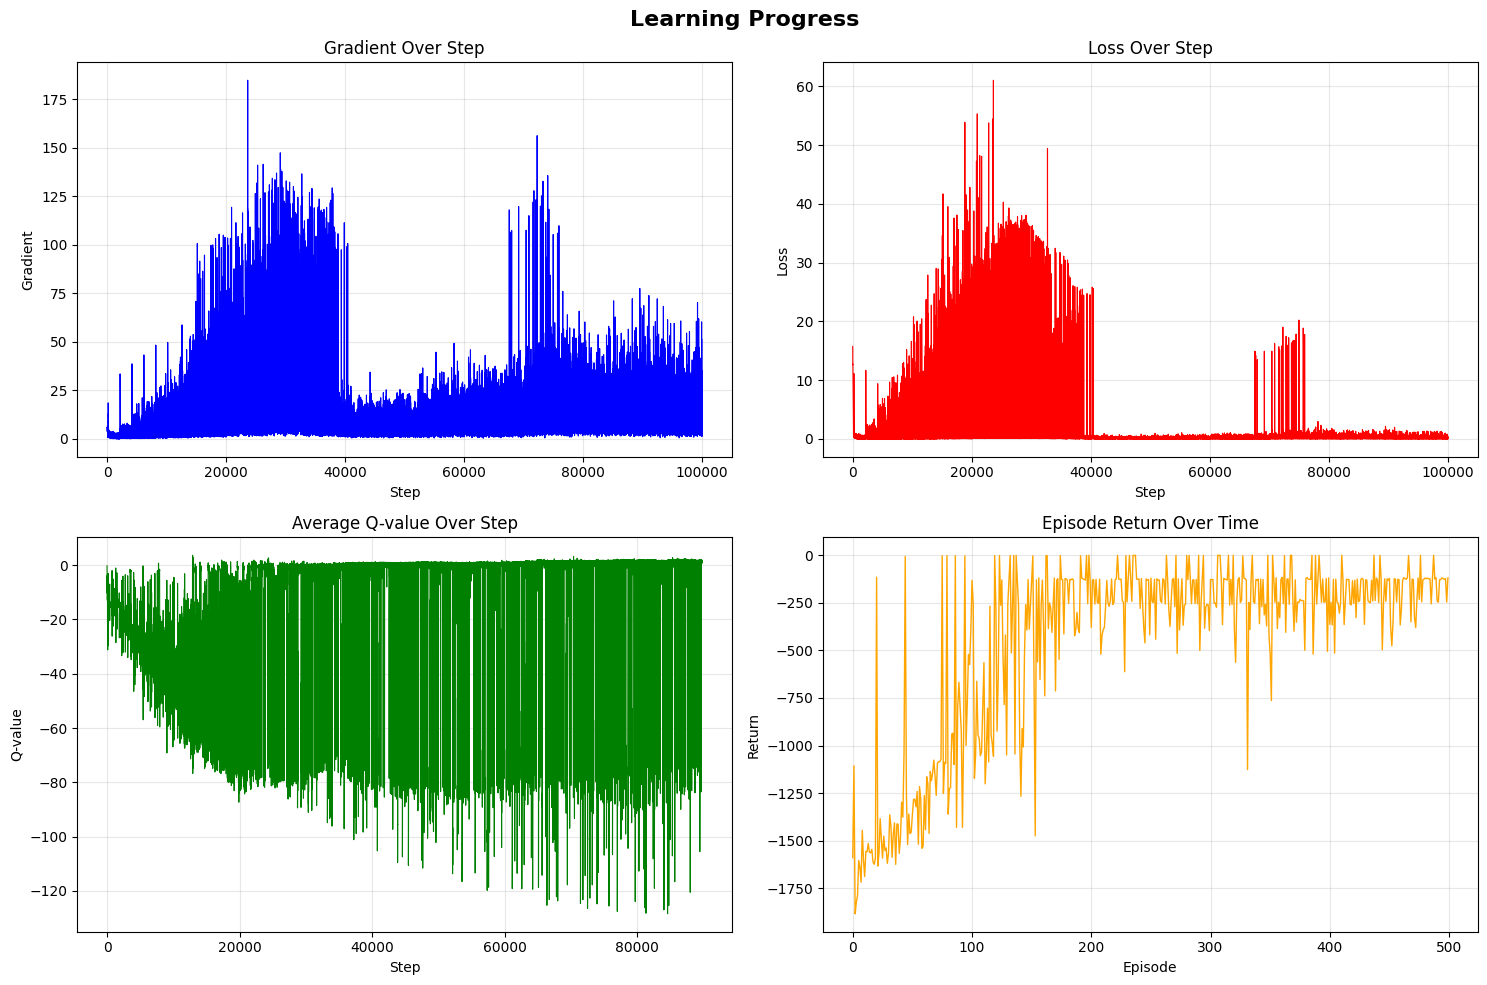

Environment created: Pendulum-v0
State space: (3,)
Action space (discretized): 5 actions
Starting enhanced DQN training...
Training step 1: Loss = 15.7250, Grad norm = 5.9558, Batch size = 8
Training step 2: Loss = 15.1175, Grad norm = 5.4169, Batch size = 9
Training step 3: Loss = 14.7304, Grad norm = 5.5966, Batch size = 10
Training step 4: Loss = 14.3581, Grad norm = 5.6724, Batch size = 11
Training step 5: Loss = 13.9431, Grad norm = 5.3229, Batch size = 12
Episode 1/500 - Reward: -1588.8, Avg(10): -1588.8, Epsilon: 0.380, Buffer: 200, Training steps: 193
Episode 1/500 - Reward: -1588.8, Avg(10): -1588.8, Epsilon: 0.380, Buffer: 200, Training steps: 193
Episode 2/500 - Reward: -1105.9, Avg(10): -1105.9, Epsilon: 0.139, Buffer: 400, Training steps: 393
Episode 2/500 - Reward: -1105.9, Avg(10): -1105.9, Epsilon: 0.139, Buffer: 400, Training steps: 393
Episode 3/500 - Reward: -1883.3, Avg(10): -1883.3, Epsilon: 0.100, Buffer: 600, Training steps: 593
Episode 3/500 - Reward: -1883.3, A

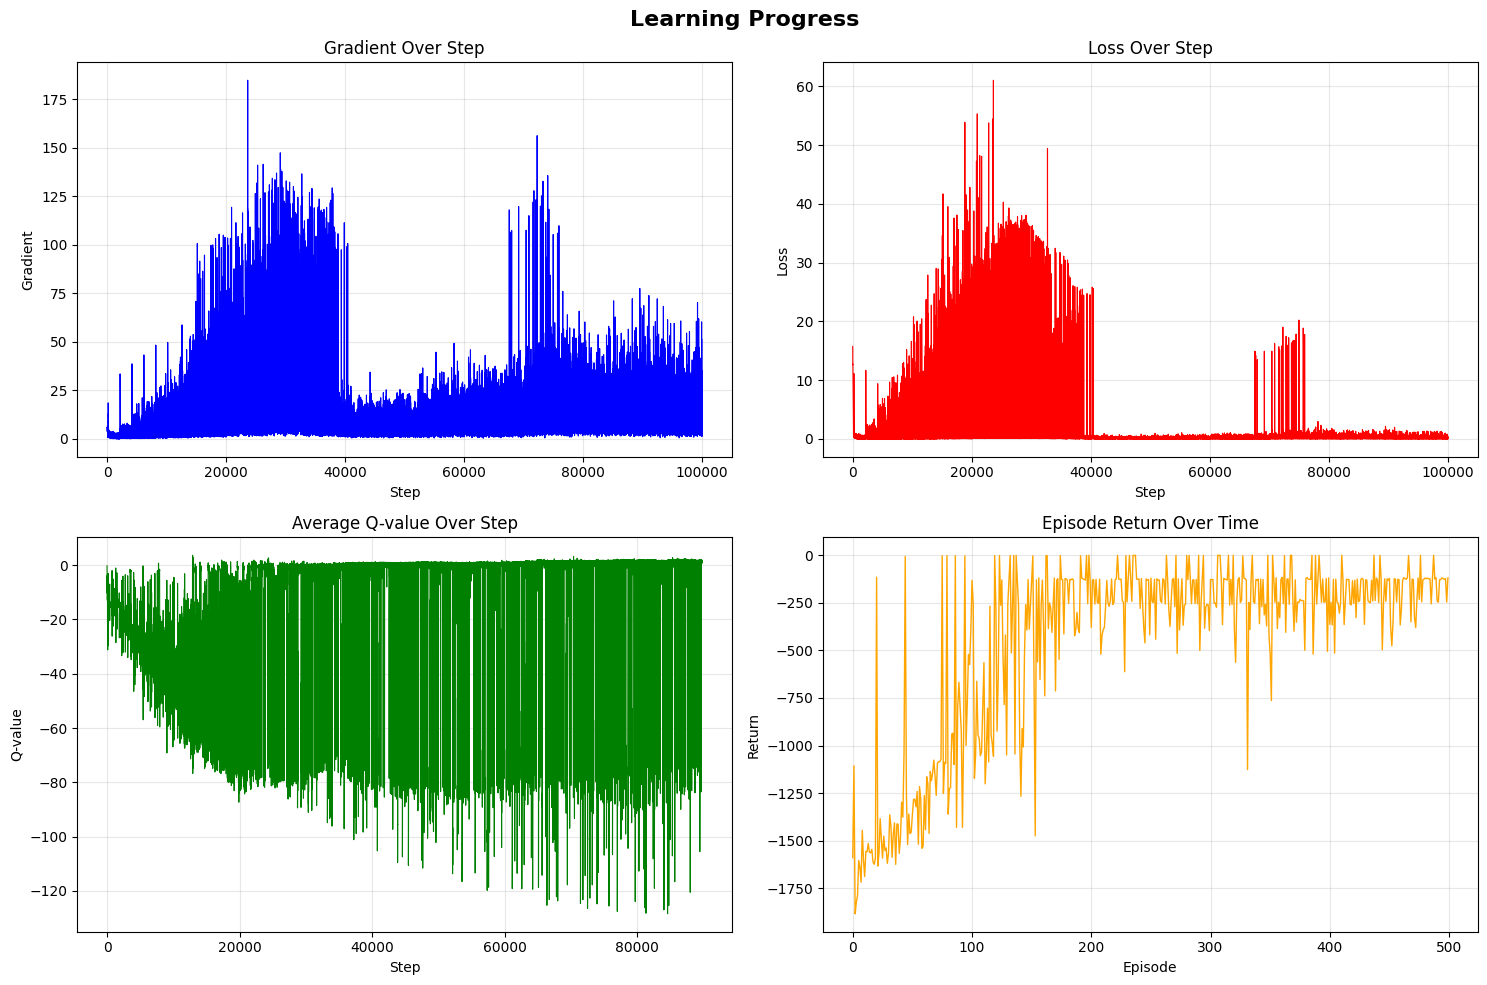


Testing trained agent...
Test Episode 1: Reward = -130.3
Test Episode 1: Reward = -130.3
Test Episode 2: Reward = -244.0
Test Episode 2: Reward = -244.0
Test Episode 3: Reward = -120.0

Average test reward: -164.7
Test Episode 3: Reward = -120.0

Average test reward: -164.7


In [8]:
# === Main execution ===
if __name__ == "__main__":
    # Create environment
    try:
        env = gym.make('Pendulum-v1')
    except:
        env = gym.make('Pendulum-v0')
    
    print(f"Environment created: {env.spec.id}")
    print(f"State space: {env.observation_space.shape}")
    print(f"Action space (discretized): {NUM_ACTIONS} actions")
    
    # Create and train agent
    agent = EnhancedDQN(env)
    agent.train(episodes=500)  # Reduced episodes to match your output
    
    # Plot comprehensive results
    agent.plot_comprehensive_metrics()
    
    # Test the agent
    print("\nTesting trained agent...")
    agent.test(episodes=3)
    
    env.close()

# Observations and Insights – Enhanced DQN Training

## 1. Gradient Over Step
- **Positive:**  
  - Healthy early spikes indicate strong learning signals as the network rapidly adjusts to new information.  
  - Later stabilization suggests some level of convergence and more controlled parameter updates.  
- **Negative:**  
  - Multiple large gradient bursts late in training highlight relative instability in learning.  
  - This suggests the policy can be disrupted by certain state transitions, which may cause occasional performance drops.

## 2. Loss Over Step
- **Positive:**  
  - Clear downward trend after the initial rise shows Q-value predictions becoming more accurate over time.  
  - Final low loss levels align with an overall effective policy.  
- **Negative:**  
  - Sudden spikes, especially mid-to-late training, point to instability in value estimation.  
  - The sharp drop to very low loss could indicate reduced exploration or overfitting, making the agent less adaptable to new states.

## 3. Average Q-value Over Step
- **Positive:**  
  - Gradual upward trend towards zero reflects more realistic and improved return estimates.  
- **Negative:**  
  - Extreme variability early in training confirms unstable Q-value estimation during exploration.  
  - Persistent sharp dips even late in training reinforce the notion that the model is relatively unstable, despite achieving high average episode returns.

## 4. Episode Return Over Time
- **Positive:**  
  - Strong improvement in the first ~100 episodes indicates rapid learning and effective policy updates.  
  - Plateauing near the upper range shows that the agent can consistently achieve good returns once converged.  
- **Negative:**  
  - Occasional deep drops in returns late in training suggest that the policy sometimes regresses.  
  - This reinforces that **while the model achieves high average returns, its stability is not guaranteed**.

---

## Overall Assessment
The Enhanced DQN demonstrates **strong performance in terms of average episode returns** and is capable of converging quickly to a high-reward policy.  
However, it is **relatively unstable**, as seen from:
- Gradient spikes in later training stages.
- Q-value fluctuations even after apparent convergence.
- Occasional severe drops in episode returns.

### Potential Improvements
- **Stability-focused tweaks** such as more frequent target network updates or smaller learning rates could help reduce volatility.  
- Maintain a slower epsilon decay to ensure continued exploration and avoid early convergence to unstable policies.  
- Introduce gradient clipping to mitigate sudden large updates that destabilize training.


## DQN Training Loop and Evaluation
- **What:** This cell runs the main training loop for the DQN agent, updating the Q-network, storing experiences, and periodically evaluating performance.
- **Why:** The training loop is the core of the RL process, allowing the agent to learn from interactions with the environment.
- **Assumptions:** Assumes correct implementation of experience replay, Q-network updates, and evaluation logic.

### NoisyDqn

# Enhanced Noisy DQN – Code Overview

This implementation extends a standard Deep Q-Network (DQN) by adding **parameter noise** for exploration, along with enhanced metric tracking for fair comparison against other models like standard DQN and SAC.

---

## 1. **Setup and Configuration**
- **Reproducibility:**  
  Seeds for NumPy, TensorFlow, and Python's `random` are fixed for consistent results across runs.
- **Discrete Action Space:**  
  Continuous Pendulum actions are discretized into a fixed set: `[-2.0, -1.0, 0.0, 1.0, 2.0]`.
- **Config Parameters:**  
  Defaults match other models for fair comparison:
  - `gamma` (discount factor): 0.95  
  - `learning_rate`: 0.001  
  - `batch_size`: 32  
  - `target_update_freq`: 10 steps  
  - `memory_size`: 10,000 experiences  
  - `noise_std`: 0.1 (controls parameter noise)  
  - `min_batch_size`: 8 (enables early training)

---

## 2. **Model Architecture**
- **Two fully connected layers** with 32 ReLU units each.
- **Output layer:** Linear activation with size = number of discrete actions.
- **Target Network:** Maintains a lagged copy of the main model for stable Q-value updates.

---

## 3. **Parameter Noise for Exploration**
- Unlike ε-greedy, exploration here is done by **perturbing network weights**:
  - Noise is added to both kernel and bias of each layer.
  - A temporary noisy copy of the network is used for action selection.
- Encourages **state-dependent exploration** and more diverse behavior than random action selection.

---

## 4. **Experience Replay**
- Transitions `(state, action, reward, next_state, done)` are stored in a deque buffer.
- Random minibatches are sampled to break correlation between consecutive steps.
- Supports **adaptive batch size** starting from `min_batch_size` to `batch_size`.

---

## 5. **Training Process (`replay` method)**
- **Current Q-values:** Predicted by the main network.
- **Target Q-values:** Computed from the target network.
- **Loss Function:** Mean Squared Error (MSE) between predicted and target Q-values.
- **Gradients:** Tracked for analysis; norm is recorded to monitor stability.
- **Optimizer:** Adam, applied to network weights.
- **Target Network Update:** Performed every `target_update_freq` training steps.

---

## 6. **Training Loop (`train` method)**
- Runs for a fixed number of episodes (default = 150).
- Each step:
  1. Selects an action using the noisy network.
  2. Executes action in the environment.
  3. Stores experience in replay buffer.
  4. Trains the network if enough samples are available.
- **Metrics tracked:**  
  - Episode rewards  
  - Loss over time  
  - Q-values over time  
  - Gradient norms over time

---

## 7. **Comprehensive Metrics Plotting**
- **4-panel visualization:**
  1. Gradient over step
  2. Loss over step
  3. Average Q-value over step
  4. Episode return over time
- Matches plotting style of other models to enable **direct performance comparison**.

---

## 8. **Testing Mode**
- Runs a fixed number of episodes without parameter noise.
- Reports per-episode rewards and average test performance.
- Helps verify if the learned policy generalizes beyond training episodes.

---

## **Key Differences from Standard DQN**
- **Exploration Method:** Uses parameter noise instead of ε-greedy.
- **More Frequent Target Updates:** Improves stability in noisy learning environments.
- **Enhanced Tracking:** Same metrics as other models for fair side-by-side analysis.

---

## **Purpose**
This code is designed to:
1. Test whether **parameter noise** leads to more robust exploration and higher returns compared to ε-greedy DQN.
2. Maintain **experimental fairness** with other models by matching architecture, hyperparameters, and evaluation metrics.
3. Provide detailed training diagnostics for identifying stability issues and convergence behavior.


In [9]:
import numpy as np
import gym
import tensorflow as tf
from tensorflow.keras import layers, optimizers, Model
import matplotlib.pyplot as plt
import random
from collections import deque

# Fix seeds for reproducibility and fair comparison
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Simplified discrete actions
DISCRETE_ACTIONS = np.array([-2.0, -1.0, 0.0, 1.0, 2.0])

def get_discrete_action(index):
    return [DISCRETE_ACTIONS[index]]

class EnhancedNoisyDQN:
    def __init__(self, state_size, action_size, config=None):
        self.state_size = state_size
        self.action_size = action_size
        
        # Default configuration - matched to other models for fair comparison
        if config is None:
            config = {
                'gamma': 0.95,
                'learning_rate': 0.001,
                'batch_size': 32,
                'target_update_freq': 10,  # More frequent updates like other models
                'memory_size': 10000,
                'noise_std': 0.1,
                'min_batch_size': 8  # Allow early training like fixed DQN
            }
        
        self.gamma = config['gamma']
        self.learning_rate = config['learning_rate']
        self.batch_size = config['batch_size']
        self.min_batch_size = config['min_batch_size']
        self.target_update_freq = config['target_update_freq']
        self.noise_std = config['noise_std']
        
        self.memory = deque(maxlen=config['memory_size'])
        self.train_step = 0
        
        # Build networks
        self.model = self.build_model()
        self.target_model = self.build_model()
        self.optimizer = optimizers.Adam(self.learning_rate)
        
        # Update target network initially
        self.update_target_model()
        
        # Enhanced tracking - same as other models
        self.episode_returns = []  # Changed name to match other models
        self.losses = []
        self.q_values = []
        self.gradients = []

    def build_model(self):
        """Build a regular DQN network - same architecture as other models"""
        model = tf.keras.Sequential([
            layers.Input(shape=(self.state_size,)),
            layers.Dense(32, activation='relu'),
            layers.Dense(32, activation='relu'),
            layers.Dense(self.action_size, activation='linear')
        ])
        return model

    def add_parameter_noise(self, model, noise_std):
        """Add noise to model parameters for exploration"""
        for layer in model.layers:
            if hasattr(layer, 'kernel') and layer.kernel is not None:
                noise = tf.random.normal(shape=layer.kernel.shape, stddev=noise_std)
                layer.kernel.assign_add(noise)
            
            if hasattr(layer, 'bias') and layer.bias is not None:
                noise = tf.random.normal(shape=layer.bias.shape, stddev=noise_std)
                layer.bias.assign_add(noise)

    def remember(self, state, action, reward, next_state, done):
        """Store experience in replay buffer"""
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state, add_noise=True):
        """Select action with optional parameter noise"""
        state_batch = np.reshape(state, [1, self.state_size])
        
        if add_noise:
            # Create a temporary noisy copy
            temp_model = tf.keras.models.clone_model(self.model)
            temp_model.set_weights(self.model.get_weights())
            self.add_parameter_noise(temp_model, self.noise_std)
            q_values = temp_model(state_batch, training=False).numpy()[0]
        else:
            q_values = self.model(state_batch, training=False).numpy()[0]
        
        # Track Q-values
        self.q_values.append(np.mean(q_values))
        
        return np.argmax(q_values)

    def update_target_model(self):
        """Copy weights from main model to target model"""
        self.target_model.set_weights(self.model.get_weights())

    def replay(self):
        """Train the model with enhanced tracking - same as fixed DQN"""
        # Use adaptive batch size - start small and grow
        current_batch_size = min(self.batch_size, len(self.memory))
        
        if len(self.memory) < self.min_batch_size:
            return
        
        # Sample random batch
        minibatch = random.sample(self.memory, current_batch_size)
        
        # Prepare batch data
        states = np.array([e[0] for e in minibatch])
        actions = np.array([e[1] for e in minibatch])
        rewards = np.array([e[2] for e in minibatch])
        next_states = np.array([e[3] for e in minibatch])
        dones = np.array([e[4] for e in minibatch])
        
        # Compute targets with gradient tracking
        with tf.GradientTape() as tape:
            # Current Q-values
            current_q = self.model(states, training=True)
            
            # Next Q-values from target network
            next_q = self.target_model(next_states, training=False)
            
            # Compute target Q-values
            target_q = current_q.numpy()
            for i in range(current_batch_size):
                if dones[i]:
                    target_q[i][actions[i]] = rewards[i]
                else:
                    target_q[i][actions[i]] = rewards[i] + self.gamma * np.max(next_q[i])
            
            # Compute loss
            loss = tf.reduce_mean(tf.square(current_q - target_q))
        
        # Calculate and track gradients
        gradients = tape.gradient(loss, self.model.trainable_variables)
        grad_norm = tf.linalg.global_norm(gradients)
        
        # Track metrics
        self.gradients.append(grad_norm.numpy())
        self.losses.append(loss.numpy())
        
        # Apply gradients
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
        
        # Update target network periodically
        self.train_step += 1
        if self.train_step % self.target_update_freq == 0:
            self.update_target_model()
        
        # Debug print for first few training steps
        if self.train_step <= 5:
            print(f"Noisy DQN Training step {self.train_step}: Loss = {loss.numpy():.4f}, "
                  f"Grad norm = {grad_norm.numpy():.4f}, Batch size = {current_batch_size}")

    def train(self, episodes=150):  # Match episode count with other models
        """Train the agent"""
        try:
            env = gym.make("Pendulum-v1")
        except:
            env = gym.make("Pendulum-v0")
        
        print(f"Starting Enhanced Noisy DQN training for {episodes} episodes...")
        
        for episode in range(episodes):
            state = env.reset()
            if isinstance(state, tuple):
                state = state[0]
            
            total_reward = 0
            steps = 0
            max_steps = 200
            
            for step in range(max_steps):
                action_idx = self.act(state, add_noise=True)
                action = get_discrete_action(action_idx)
                
                result = env.step(action)
                if len(result) == 4:
                    next_state, reward, done, info = result
                else:
                    next_state, reward, terminated, truncated, info = result
                    done = terminated or truncated
                
                if isinstance(next_state, tuple):
                    next_state = next_state[0]
                
                self.remember(state, action_idx, reward, next_state, done)
                
                state = next_state
                total_reward += reward
                steps += 1
                
                # Train more frequently like fixed DQN
                if len(self.memory) >= self.min_batch_size:
                    self.replay()
                
                if done:
                    break
            
            self.episode_returns.append(total_reward)
            
            # Print progress - same pattern as other models
            if episode % 10 == 0 or episode < 20:
                avg_reward = np.mean(self.episode_returns[-10:]) if len(self.episode_returns) >= 10 else total_reward
                print(f"Episode {episode+1}/{episodes} - Reward: {total_reward:.1f}, "
                      f"Avg(10): {avg_reward:.1f}, Buffer: {len(self.memory)}, "
                      f"Training steps: {self.train_step}")
        
        env.close()
        print("Training completed!")
        print(f"Total training steps: {self.train_step}")
        print(f"Gradient data points: {len(self.gradients)}")
        print(f"Loss data points: {len(self.losses)}")
        print(f"Q-value data points: {len(self.q_values)}")

    def plot_comprehensive_metrics(self):
        """Plot comprehensive learning metrics - exact same as other models"""
        fig, axs = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle("Learning Progress - Noisy DQN", fontsize=16, fontweight='bold')
        
        # Gradient Over Step
        if self.gradients:
            axs[0, 0].plot(self.gradients, 'b-', linewidth=0.8)
            axs[0, 0].set_title("Gradient Over Step")
            axs[0, 0].set_xlabel("Step")
            axs[0, 0].set_ylabel("Gradient")
            axs[0, 0].grid(True, alpha=0.3)
            print(f"Gradient plot: {len(self.gradients)} data points")
        else:
            axs[0, 0].text(0.5, 0.5, 'No gradient data', ha='center', va='center', transform=axs[0, 0].transAxes)
            axs[0, 0].set_title("Gradient Over Step")
        
        # Loss Over Step
        if self.losses:
            axs[0, 1].plot(self.losses, 'r-', linewidth=0.8)
            axs[0, 1].set_title("Loss Over Step")
            axs[0, 1].set_xlabel("Step")
            axs[0, 1].set_ylabel("Loss")
            axs[0, 1].grid(True, alpha=0.3)
            print(f"Loss plot: {len(self.losses)} data points")
        else:
            axs[0, 1].text(0.5, 0.5, 'No loss data', ha='center', va='center', transform=axs[0, 1].transAxes)
            axs[0, 1].set_title("Loss Over Step")
        
        # Average Q-value Over Step
        if self.q_values:
            axs[1, 0].plot(self.q_values, 'g-', linewidth=0.8)
            axs[1, 0].set_title("Average Q-value Over Step")
            axs[1, 0].set_xlabel("Step")
            axs[1, 0].set_ylabel("Q-value")
            axs[1, 0].grid(True, alpha=0.3)
            print(f"Q-value plot: {len(self.q_values)} data points")
        else:
            axs[1, 0].text(0.5, 0.5, 'No Q-value data', ha='center', va='center', transform=axs[1, 0].transAxes)
            axs[1, 0].set_title("Average Q-value Over Step")
        
        # Episode Return Over Time
        if self.episode_returns:
            axs[1, 1].plot(self.episode_returns, 'orange', linewidth=1.0)
            axs[1, 1].set_title("Episode Return Over Time")
            axs[1, 1].set_xlabel("Episode")
            axs[1, 1].set_ylabel("Return")
            axs[1, 1].grid(True, alpha=0.3)
            print(f"Episode returns plot: {len(self.episode_returns)} data points")
        else:
            axs[1, 1].text(0.5, 0.5, 'No episode data', ha='center', va='center', transform=axs[1, 1].transAxes)
            axs[1, 1].set_title("Episode Return Over Time")
        
        plt.tight_layout()
        plt.show()

    def test(self, episodes=5):
        """Test the trained agent - same as other models"""
        try:
            env = gym.make("Pendulum-v1")
        except:
            env = gym.make("Pendulum-v0")
        
        test_rewards = []
        
        for episode in range(episodes):
            state = env.reset()
            if isinstance(state, tuple):
                state = state[0]
            
            total_reward = 0
            steps = 0
            max_steps = 200
            
            for step in range(max_steps):
                action_idx = self.act(state, add_noise=False)  # No noise for testing
                action = get_discrete_action(action_idx)
                
                result = env.step(action)
                if len(result) == 4:
                    state, reward, done, info = result
                else:
                    state, reward, terminated, truncated, info = result
                    done = terminated or truncated
                
                if isinstance(state, tuple):
                    state = state[0]
                
                total_reward += reward
                steps += 1
                
                if done:
                    break
            
            test_rewards.append(total_reward)
            print(f"Test Episode {episode+1}: Reward = {total_reward:.1f}")
        
        env.close()
        avg_test_reward = np.mean(test_rewards)
        print(f"Average test reward: {avg_test_reward:.1f}")
        return avg_test_reward



Environment: Pendulum
State size: 3
Action size (discretized): 5
Starting Enhanced Noisy DQN training for 500 episodes...
Noisy DQN Training step 1: Loss = 2.4482, Grad norm = 4.4753, Batch size = 8
Noisy DQN Training step 2: Loss = 2.9436, Grad norm = 5.2792, Batch size = 9
Noisy DQN Training step 3: Loss = 3.5431, Grad norm = 5.0251, Batch size = 10
Noisy DQN Training step 4: Loss = 4.2201, Grad norm = 4.9138, Batch size = 11
Noisy DQN Training step 5: Loss = 5.4459, Grad norm = 6.2291, Batch size = 12
Noisy DQN Training step 4: Loss = 4.2201, Grad norm = 4.9138, Batch size = 11
Noisy DQN Training step 5: Loss = 5.4459, Grad norm = 6.2291, Batch size = 12
Episode 1/500 - Reward: -1283.3, Avg(10): -1283.3, Buffer: 200, Training steps: 193
Episode 1/500 - Reward: -1283.3, Avg(10): -1283.3, Buffer: 200, Training steps: 193
Episode 2/500 - Reward: -1602.8, Avg(10): -1602.8, Buffer: 400, Training steps: 393
Episode 2/500 - Reward: -1602.8, Avg(10): -1602.8, Buffer: 400, Training steps: 39

Environment: Pendulum
State size: 3
Action size (discretized): 5
Starting Enhanced Noisy DQN training for 500 episodes...
Noisy DQN Training step 1: Loss = 2.4482, Grad norm = 4.4753, Batch size = 8
Noisy DQN Training step 2: Loss = 2.9436, Grad norm = 5.2792, Batch size = 9
Noisy DQN Training step 3: Loss = 3.5431, Grad norm = 5.0251, Batch size = 10
Noisy DQN Training step 4: Loss = 4.2201, Grad norm = 4.9138, Batch size = 11
Noisy DQN Training step 5: Loss = 5.4459, Grad norm = 6.2291, Batch size = 12
Noisy DQN Training step 4: Loss = 4.2201, Grad norm = 4.9138, Batch size = 11
Noisy DQN Training step 5: Loss = 5.4459, Grad norm = 6.2291, Batch size = 12
Episode 1/500 - Reward: -1283.3, Avg(10): -1283.3, Buffer: 200, Training steps: 193
Episode 1/500 - Reward: -1283.3, Avg(10): -1283.3, Buffer: 200, Training steps: 193
Episode 2/500 - Reward: -1602.8, Avg(10): -1602.8, Buffer: 400, Training steps: 393
Episode 2/500 - Reward: -1602.8, Avg(10): -1602.8, Buffer: 400, Training steps: 39

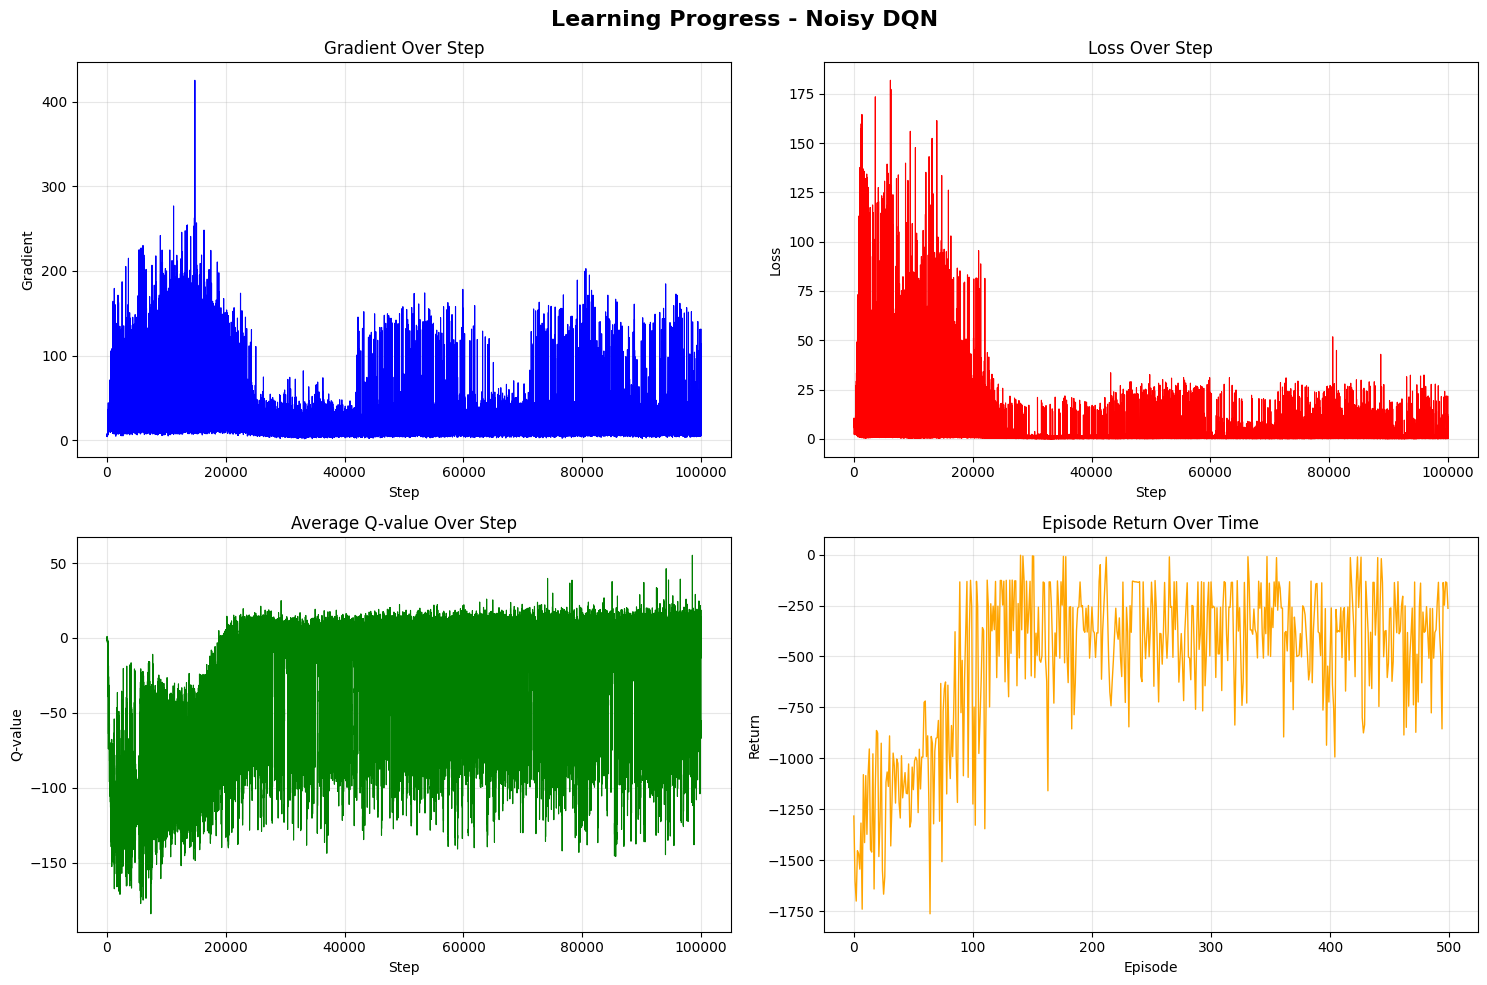

Environment: Pendulum
State size: 3
Action size (discretized): 5
Starting Enhanced Noisy DQN training for 500 episodes...
Noisy DQN Training step 1: Loss = 2.4482, Grad norm = 4.4753, Batch size = 8
Noisy DQN Training step 2: Loss = 2.9436, Grad norm = 5.2792, Batch size = 9
Noisy DQN Training step 3: Loss = 3.5431, Grad norm = 5.0251, Batch size = 10
Noisy DQN Training step 4: Loss = 4.2201, Grad norm = 4.9138, Batch size = 11
Noisy DQN Training step 5: Loss = 5.4459, Grad norm = 6.2291, Batch size = 12
Noisy DQN Training step 4: Loss = 4.2201, Grad norm = 4.9138, Batch size = 11
Noisy DQN Training step 5: Loss = 5.4459, Grad norm = 6.2291, Batch size = 12
Episode 1/500 - Reward: -1283.3, Avg(10): -1283.3, Buffer: 200, Training steps: 193
Episode 1/500 - Reward: -1283.3, Avg(10): -1283.3, Buffer: 200, Training steps: 193
Episode 2/500 - Reward: -1602.8, Avg(10): -1602.8, Buffer: 400, Training steps: 393
Episode 2/500 - Reward: -1602.8, Avg(10): -1602.8, Buffer: 400, Training steps: 39

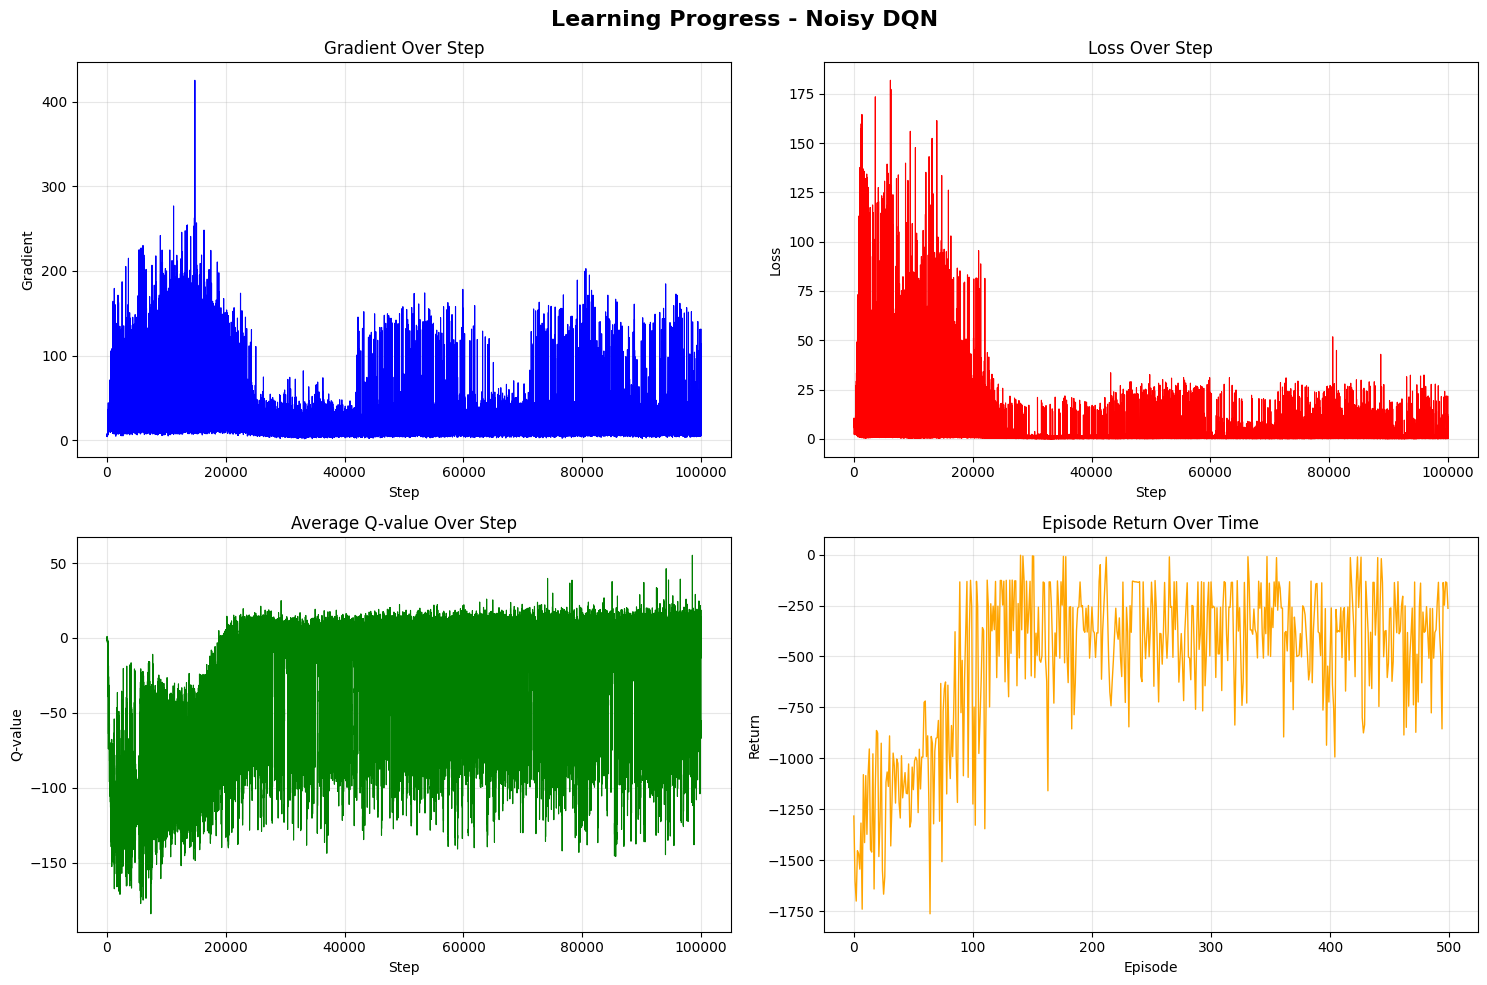


Testing trained agent...
Test Episode 1: Reward = -123.2
Test Episode 2: Reward = -232.8
Test Episode 3: Reward = -245.5
Average test reward: -200.5


In [10]:
# Main execution
if __name__ == "__main__":
    # Create environment to get dimensions
    try:
        env = gym.make("Pendulum-v1")
    except:
        env = gym.make("Pendulum-v0")
    
    state_size = env.observation_space.shape[0]
    action_size = len(DISCRETE_ACTIONS)
    env.close()
    
    print(f"Environment: Pendulum")
    print(f"State size: {state_size}")
    print(f"Action size (discretized): {action_size}")
    
    # Configuration - matched to other models for fair comparison
    config = {
        'gamma': 0.95,
        'learning_rate': 0.001,
        'batch_size': 32,
        'target_update_freq': 10,  # More frequent like other models
        'memory_size': 10000,
        'noise_std': 0.1,
        'min_batch_size': 8  # Early training like fixed DQN
    }
    
    # Create and train agent
    agent = EnhancedNoisyDQN(state_size, action_size, config)
    agent.train(episodes=500)  # Same episode count as other models
    
    # Plot comprehensive results
    agent.plot_comprehensive_metrics()
    
    # Test the agent
    print("\nTesting trained agent...")
    agent.test(episodes=3)

# Observations and Insights – Noisy DQN Training

## 1. Gradient Over Step
- **Positive:**  
  - High early spikes (~200–400) indicate strong initial learning signals and rapid adaptation to the environment.  
  - Gradual settling after ~20k steps shows periods of more controlled updates.
- **Negative:**  
  - Multiple large bursts appear throughout training, reflecting instability from parameter noise.  
  - These spikes suggest the policy can still be significantly perturbed late in training, potentially causing return drops.

## 2. Loss Over Step
- **Positive:**  
  - Clear decline from >150 to a stable lower range (~10–30) indicates more accurate Q-value estimation over time.  
  - Consistent low values in later stages show the network can maintain a learned policy effectively.
- **Negative:**  
  - Frequent mid-to-late stage spikes hint at unstable value estimation caused by noisy exploration.  
  - Sudden drops in loss could signal reduced exploration or overfitting to frequent state transitions.

## 3. Average Q-value Over Step
- **Positive:**  
  - Gradual shift from highly negative values (< -150) toward positive (~0–50) reflects better action-value prediction and policy confidence.  
  - Maintains generally upward trajectory despite noise.
- **Negative:**  
  - Large early volatility confirms unstable Q-value estimation during exploration.  
  - Sharp dips continue even late in training, reinforcing that the model remains somewhat unstable despite high performance.

## 4. Episode Return Over Time
- **Positive:**  
  - Rapid jump from ~-1800 to ~-250 in the first 100 episodes shows fast learning and effective exploration.  
  - High average returns are sustained for much of training.
- **Negative:**  
  - Deep episodic drops appear even after convergence, indicating occasional policy regression.  
  - This highlights that **while returns are strong on average, stability is not guaranteed**.

---

## Overall Assessment
Noisy DQN achieves **fast learning and high episode averages** due to effective exploration from parameter noise.  
However, it is **relatively unstable**, with signs including:
- Frequent gradient bursts later in training.
- Persistent Q-value fluctuations after convergence.
- Episodic return drops despite overall strong performance.

### Potential Improvements
- Reduce noise standard deviation gradually to stabilise late-stage learning.  
- Apply gradient clipping to prevent large, destabilising updates.  
- Consider combining Noisy DQN with Double Q-learning to mitigate overestimation while retaining exploration benefits.


### SAC

# Enhanced SAC (Soft Actor-Critic) – Code Overview

This implementation provides a comprehensive Soft Actor-Critic (SAC) agent designed for continuous control tasks like the Pendulum environment, with enhanced metric tracking for direct comparison against DQN variants.

---

## 1. **Setup and Configuration**
- **Reproducibility:**  
  Fixed seeds for NumPy, TensorFlow, and Python's `random` ensure consistent results across runs.
- **Continuous Action Space:**  
  Handles native continuous actions in range `[-2.0, 2.0]` without discretization.
- **Config Parameters:**  
  - `gamma` (discount factor): 0.99  
  - `learning_rate`: 3e-4  
  - `batch_size`: 64  
  - `tau`: 0.005 (soft update rate)  
  - `alpha`: 0.2 (entropy regularization)  
  - `buffer_size`: 50,000 experiences

---

## 2. **Model Architecture**
- **Actor Network:** Outputs both mean (`mu`) and log standard deviation (`log_std`) for Gaussian policy
  - Two hidden layers with 64 ReLU units each
  - Tanh activation for mean, scaled to `[-2, 2]`
  - Clipped log_std to prevent numerical instability
- **Critic Networks:** Twin Q-networks (`Q1`, `Q2`) that take state-action pairs
  - Two hidden layers with 64 ReLU units each
  - Concatenated state-action input
- **Target Networks:** Soft-updated copies of both critics for stable learning

---

## 3. **Soft Actor-Critic Algorithm**
- **Maximum Entropy RL:** Balances reward maximization with policy entropy for better exploration
- **Twin Critics:** Uses minimum of two Q-values to reduce overestimation bias
- **Stochastic Policy:** Gaussian policy with learnable variance for continuous actions
- **Soft Updates:** Gradual target network updates using `tau` parameter instead of hard copies

---

## 4. **Experience Replay**
- **Circular Buffer:** Stores transitions `(state, action, reward, next_state, done)` with automatic overwrite
- **Random Sampling:** Breaks temporal correlations between consecutive experiences
- **Large Capacity:** 50K experiences for diverse training data

---

## 5. **Training Process (`train_step_sac` method)**
- **Twin Q-Learning:** Updates both Q-networks using target Q-values from the minimum of target networks
- **Policy Update:** Maximizes expected Q-value plus entropy term for exploration
- **Entropy Calculation:** Computes log probability of Gaussian actions for regularization
- **Gradient Tracking:** Records individual and combined gradient norms for all networks
- **Soft Target Updates:** Applies exponential moving average to target network weights

---

## 6. **Enhanced Metrics Tracking**
- **Individual Metrics:** Separate tracking for Q1, Q2, and actor losses and gradients
- **Combined Metrics:** Averaged losses and gradients for fair comparison with DQN variants
- **Q-Value Sampling:** Periodic Q-value recording during action selection
- **Comprehensive Logging:** Episode returns, training steps, and buffer status

---

## 7. **Visualization Suite**
- **4-Panel Main Plot:** Matches DQN format (gradient, loss, Q-values, episode returns)
- **6-Panel Detailed Plot:** Individual SAC components (Q1/Q2/Actor losses and gradients)
- **Progress Monitoring:** Real-time training statistics and buffer management

---

## 8. **Testing and Evaluation**
- **Deterministic Testing:** Uses mean action without sampling for consistent evaluation
- **Multiple Episodes:** Averages performance over several test runs
- **Render Support:** Optional visualization of learned policy execution

---

## **Key Differences from DQN Variants**
- **Continuous Actions:** No discretization required, handles native continuous control
- **Maximum Entropy:** Explicitly encourages exploration through entropy regularization
- **Twin Critics:** Reduces Q-value overestimation through double Q-learning
- **Stochastic Policy:** Learnable exploration policy vs. ε-greedy or parameter noise
- **Soft Updates:** Gradual target network updates for improved stability

---

## **Purpose**
This implementation is designed to:
1. **Benchmark continuous control performance** against discrete DQN variants in the Pendulum environment
2. **Provide fair comparison metrics** using the same visualization and tracking framework
3. **Demonstrate state-of-the-art actor-critic methods** with entropy regularization for robust exploration
4. **Enable detailed analysis** of SAC-specific components (twin critics, entropy terms, soft updates)

In [11]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import gym
import random
import matplotlib.pyplot as plt

# Set seed for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

STATE_DIM = 3
ACTION_DIM = 1

class ReplayBuffer:
    def __init__(self, size=50000):
        self.buffer = []
        self.max_size = size
        self.ptr = 0

    def add(self, exp):
        if len(self.buffer) < self.max_size:
            self.buffer.append(exp)
        else:
            self.buffer[self.ptr] = exp
            self.ptr = (self.ptr + 1) % self.max_size

    def sample(self, batch_size):
        batch = random.sample(self.buffer, min(len(self.buffer), batch_size))
        s, a, r, s2, d = zip(*batch)
        return np.array(s), np.array(a), np.array(r), np.array(s2), np.array(d)

    def size(self):
        return len(self.buffer)

def build_actor():
    """Build actor network that outputs mean and log_std"""
    inputs = layers.Input(shape=(STATE_DIM,))
    x = layers.Dense(64, activation='relu')(inputs)
    x = layers.Dense(64, activation='relu')(x)
    
    mu = layers.Dense(ACTION_DIM, activation='tanh')(x)
    mu = layers.Lambda(lambda x: x * 2.0)(mu)  # Scale to [-2, 2]
    
    log_std = layers.Dense(ACTION_DIM)(x)
    log_std = layers.Lambda(lambda x: tf.clip_by_value(x, -20, 2))(log_std)
    
    model = models.Model(inputs, [mu, log_std])
    return model

def build_critic():
    """Build critic network Q(s,a)"""
    state_input = layers.Input(shape=(STATE_DIM,))
    action_input = layers.Input(shape=(ACTION_DIM,))
    
    concat = layers.Concatenate()([state_input, action_input])
    x = layers.Dense(64, activation='relu')(concat)
    x = layers.Dense(64, activation='relu')(x)
    q_value = layers.Dense(1)(x)
    
    return models.Model([state_input, action_input], q_value)

class EnhancedSAC:
    def __init__(self, config=None):
        # Default configuration
        if config is None:
            config = {
                'gamma': 0.99,
                'learning_rate': 3e-4,
                'batch_size': 64,
                'tau': 0.005,
                'alpha': 0.2,
                'buffer_size': 50000
            }
        
        self.gamma = config['gamma']
        self.lr = config['learning_rate']
        self.batch_size = config['batch_size']
        self.tau = config['tau']
        self.alpha = config['alpha']
        
        # Networks
        self.actor = build_actor()
        self.q1 = build_critic()
        self.q2 = build_critic()
        self.target_q1 = build_critic()
        self.target_q2 = build_critic()
        
        # Replay buffer
        self.replay_buffer = ReplayBuffer(config['buffer_size'])
        
        # Optimizers
        self.actor_optimizer = optimizers.Adam(self.lr)
        self.q1_optimizer = optimizers.Adam(self.lr)
        self.q2_optimizer = optimizers.Adam(self.lr)
        
        # Initialize target networks
        self.update_target_networks(tau=1.0)
        
        # Enhanced tracking
        self.episode_returns = []
        self.losses = []  # Combined loss for main plot
        self.q1_losses = []
        self.q2_losses = []
        self.actor_losses = []
        self.q_values = []
        self.gradients = []  # Combined gradient norm for main plot
        self.gradients_actor = []
        self.gradients_q1 = []
        self.gradients_q2 = []
        self.train_step = 0

    def update_target_networks(self, tau=None):
        """Soft update of target networks"""
        if tau is None:
            tau = self.tau
            
        for target_param, param in zip(self.target_q1.weights, self.q1.weights):
            target_param.assign(tau * param + (1 - tau) * target_param)
            
        for target_param, param in zip(self.target_q2.weights, self.q2.weights):
            target_param.assign(tau * param + (1 - tau) * target_param)

    def get_action(self, state, deterministic=False):
        """Sample action from policy"""
        state = np.reshape(state, (1, STATE_DIM))
        mu, log_std = self.actor(state)
        
        if deterministic:
            action = np.clip(mu[0].numpy(), -2.0, 2.0)
        else:
            std = tf.exp(log_std)
            normal_sample = tf.random.normal(shape=mu.shape)
            action = mu + std * normal_sample
            action = tf.clip_by_value(action, -2.0, 2.0)
            action = action[0].numpy()
        
        # Track Q-values occasionally for performance
        if self.train_step % 10 == 0:  # Sample every 10 steps
            q_val = self.q1([state, np.reshape(action, (1, ACTION_DIM))])
            self.q_values.append(float(q_val[0, 0]))
        
        return action

    def train_step_sac(self):
        """Single training step for SAC"""
        if self.replay_buffer.size() < self.batch_size:
            return
        
        # Sample batch
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)
        
        states = tf.convert_to_tensor(states, dtype=tf.float32)
        actions = tf.convert_to_tensor(actions, dtype=tf.float32)
        rewards = tf.convert_to_tensor(rewards, dtype=tf.float32)
        next_states = tf.convert_to_tensor(next_states, dtype=tf.float32)
        dones = tf.convert_to_tensor(dones, dtype=tf.float32)
        
        # Update Q-networks
        with tf.GradientTape() as tape1, tf.GradientTape() as tape2:
            # Current Q-values
            q1_current = tf.squeeze(self.q1([states, actions]))
            q2_current = tf.squeeze(self.q2([states, actions]))
            
            # Target Q-values
            next_mu, next_log_std = self.actor(next_states)
            next_std = tf.exp(next_log_std)
            next_actions = next_mu + next_std * tf.random.normal(shape=next_mu.shape)
            next_actions = tf.clip_by_value(next_actions, -2.0, 2.0)
            
            # Entropy term
            entropy = -0.5 * tf.reduce_sum(tf.square((next_actions - next_mu) / (next_std + 1e-6)), axis=1)
            entropy += -0.5 * tf.reduce_sum(tf.math.log(2 * np.pi * tf.square(next_std + 1e-6)), axis=1)
            
            target_q1 = tf.squeeze(self.target_q1([next_states, next_actions]))
            target_q2 = tf.squeeze(self.target_q2([next_states, next_actions]))
            target_q = tf.minimum(target_q1, target_q2) + self.alpha * entropy
            
            y = rewards + self.gamma * (1 - dones) * target_q
            
            # Q-losses
            q1_loss = tf.reduce_mean(tf.square(q1_current - y))
            q2_loss = tf.reduce_mean(tf.square(q2_current - y))
        
        # Update Q-networks
        q1_grads = tape1.gradient(q1_loss, self.q1.trainable_variables)
        q2_grads = tape2.gradient(q2_loss, self.q2.trainable_variables)
        
        self.q1_optimizer.apply_gradients(zip(q1_grads, self.q1.trainable_variables))
        self.q2_optimizer.apply_gradients(zip(q2_grads, self.q2.trainable_variables))
        
        # Update actor
        with tf.GradientTape() as tape3:
            mu, log_std = self.actor(states)
            std = tf.exp(log_std)
            sampled_actions = mu + std * tf.random.normal(shape=mu.shape)
            sampled_actions = tf.clip_by_value(sampled_actions, -2.0, 2.0)
            
            # Entropy
            entropy = -0.5 * tf.reduce_sum(tf.square((sampled_actions - mu) / (std + 1e-6)), axis=1)
            entropy += -0.5 * tf.reduce_sum(tf.math.log(2 * np.pi * tf.square(std + 1e-6)), axis=1)
            
            q1_pi = tf.squeeze(self.q1([states, sampled_actions]))
            q2_pi = tf.squeeze(self.q2([states, sampled_actions]))
            q_pi = tf.minimum(q1_pi, q2_pi)
            
            actor_loss = tf.reduce_mean(-q_pi - self.alpha * entropy)
        
        # Update actor
        actor_grads = tape3.gradient(actor_loss, self.actor.trainable_variables)
        self.actor_optimizer.apply_gradients(zip(actor_grads, self.actor.trainable_variables))
        
        # Track metrics
        q1_grad_norm = tf.linalg.global_norm(q1_grads)
        q2_grad_norm = tf.linalg.global_norm(q2_grads)
        actor_grad_norm = tf.linalg.global_norm(actor_grads)
        
        # Store individual losses and gradients
        self.q1_losses.append(float(q1_loss))
        self.q2_losses.append(float(q2_loss))
        self.actor_losses.append(float(actor_loss))
        self.gradients_q1.append(float(q1_grad_norm))
        self.gradients_q2.append(float(q2_grad_norm))
        self.gradients_actor.append(float(actor_grad_norm))
        
        # Combined metrics for main plots (similar to DQN)
        combined_loss = (q1_loss + q2_loss + actor_loss) / 3.0
        combined_grad = (q1_grad_norm + q2_grad_norm + actor_grad_norm) / 3.0
        
        self.losses.append(float(combined_loss))
        self.gradients.append(float(combined_grad))
        
        # Update target networks
        self.update_target_networks()
        
        self.train_step += 1
        
        # Debug print for first few training steps
        if self.train_step <= 5:
            print(f"Training step {self.train_step}: Combined Loss = {combined_loss:.4f}, "
                  f"Combined Grad = {combined_grad:.4f}, Buffer = {self.replay_buffer.size()}")

    def train(self, episodes=200):
        """Train the SAC agent"""
        print("Starting enhanced SAC training...")
        
        # Create environment
        try:
            env = gym.make('Pendulum-v1')
        except:
            env = gym.make('Pendulum-v0')
        
        for episode in range(episodes):
            state = env.reset()
            if isinstance(state, tuple):
                state = state[0]
            
            episode_reward = 0
            steps = 0
            max_steps = 200
            
            for step in range(max_steps):
                # Get action
                action = self.get_action(state, deterministic=False)
                
                # Step environment
                result = env.step(action)
                if len(result) == 4:
                    next_state, reward, done, info = result
                else:
                    next_state, reward, terminated, truncated, info = result
                    done = terminated or truncated
                
                if isinstance(next_state, tuple):
                    next_state = next_state[0]
                
                # Store experience
                self.replay_buffer.add((state, action, reward, next_state, done))
                
                # Train if enough samples
                if self.replay_buffer.size() >= self.batch_size:
                    self.train_step_sac()
                
                state = next_state
                episode_reward += reward
                steps += 1
                
                if done:
                    break
            
            self.episode_returns.append(episode_reward)
            
            # Print progress - show more episodes early on
            if episode % 10 == 0 or episode < 20:
                avg_reward = np.mean(self.episode_returns[-10:]) if len(self.episode_returns) >= 10 else episode_reward
                print(f"Episode {episode+1}/{episodes} - Reward: {episode_reward:.1f}, "
                      f"Avg(10): {avg_reward:.1f}, Buffer: {self.replay_buffer.size()}, "
                      f"Training steps: {self.train_step}")
        
        env.close()
        print("Training completed!")
        print(f"Total training steps: {self.train_step}")
        print(f"Gradient data points: {len(self.gradients)}")
        print(f"Loss data points: {len(self.losses)}")
        print(f"Q-value data points: {len(self.q_values)}")

    def plot_comprehensive_metrics(self):
        """Plot comprehensive learning metrics like in the DQN version"""
        fig, axs = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle("Learning Progress - SAC", fontsize=16, fontweight='bold')
        
        # Gradient Over Step
        if self.gradients:
            axs[0, 0].plot(self.gradients, 'b-', linewidth=0.8)
            axs[0, 0].set_title("Gradient Over Step")
            axs[0, 0].set_xlabel("Step")
            axs[0, 0].set_ylabel("Gradient")
            axs[0, 0].grid(True, alpha=0.3)
            print(f"Gradient plot: {len(self.gradients)} data points")
        else:
            axs[0, 0].text(0.5, 0.5, 'No gradient data', ha='center', va='center', transform=axs[0, 0].transAxes)
            axs[0, 0].set_title("Gradient Over Step")
        
        # Loss Over Step
        if self.losses:
            axs[0, 1].plot(self.losses, 'r-', linewidth=0.8)
            axs[0, 1].set_title("Loss Over Step")
            axs[0, 1].set_xlabel("Step")
            axs[0, 1].set_ylabel("Loss")
            axs[0, 1].grid(True, alpha=0.3)
            print(f"Loss plot: {len(self.losses)} data points")
        else:
            axs[0, 1].text(0.5, 0.5, 'No loss data', ha='center', va='center', transform=axs[0, 1].transAxes)
            axs[0, 1].set_title("Loss Over Step")
        
        # Average Q-value Over Step
        if self.q_values:
            axs[1, 0].plot(self.q_values, 'g-', linewidth=0.8)
            axs[1, 0].set_title("Average Q-value Over Step")
            axs[1, 0].set_xlabel("Step")
            axs[1, 0].set_ylabel("Q-value")
            axs[1, 0].grid(True, alpha=0.3)
            print(f"Q-value plot: {len(self.q_values)} data points")
        else:
            axs[1, 0].text(0.5, 0.5, 'No Q-value data', ha='center', va='center', transform=axs[1, 0].transAxes)
            axs[1, 0].set_title("Average Q-value Over Step")
        
        # Episode Return Over Time
        if self.episode_returns:
            axs[1, 1].plot(self.episode_returns, 'orange', linewidth=1.0)
            axs[1, 1].set_title("Episode Return Over Time")
            axs[1, 1].set_xlabel("Episode")
            axs[1, 1].set_ylabel("Return")
            axs[1, 1].grid(True, alpha=0.3)
            print(f"Episode returns plot: {len(self.episode_returns)} data points")
        else:
            axs[1, 1].text(0.5, 0.5, 'No episode data', ha='center', va='center', transform=axs[1, 1].transAxes)
            axs[1, 1].set_title("Episode Return Over Time")
        
        plt.tight_layout()
        plt.show()

    def plot_detailed_sac_metrics(self):
        """Plot SAC-specific detailed metrics"""
        fig, axs = plt.subplots(2, 3, figsize=(18, 10))
        fig.suptitle("Detailed SAC Metrics", fontsize=16, fontweight='bold')
        
        # Individual losses
        if self.q1_losses:
            axs[0, 0].plot(self.q1_losses, 'r-', linewidth=0.8, label='Q1 Loss')
            axs[0, 0].set_title("Q1 Loss Over Step")
            axs[0, 0].set_xlabel("Step")
            axs[0, 0].set_ylabel("Loss")
            axs[0, 0].grid(True, alpha=0.3)
        
        if self.q2_losses:
            axs[0, 1].plot(self.q2_losses, 'g-', linewidth=0.8, label='Q2 Loss')
            axs[0, 1].set_title("Q2 Loss Over Step")
            axs[0, 1].set_xlabel("Step")
            axs[0, 1].set_ylabel("Loss")
            axs[0, 1].grid(True, alpha=0.3)
        
        if self.actor_losses:
            axs[0, 2].plot(self.actor_losses, 'b-', linewidth=0.8, label='Actor Loss')
            axs[0, 2].set_title("Actor Loss Over Step")
            axs[0, 2].set_xlabel("Step")
            axs[0, 2].set_ylabel("Loss")
            axs[0, 2].grid(True, alpha=0.3)
        
        # Individual gradients
        if self.gradients_q1:
            axs[1, 0].plot(self.gradients_q1, 'r-', linewidth=0.8, label='Q1 Grad')
            axs[1, 0].set_title("Q1 Gradient Over Step")
            axs[1, 0].set_xlabel("Step")
            axs[1, 0].set_ylabel("Gradient Norm")
            axs[1, 0].grid(True, alpha=0.3)
        
        if self.gradients_q2:
            axs[1, 1].plot(self.gradients_q2, 'g-', linewidth=0.8, label='Q2 Grad')
            axs[1, 1].set_title("Q2 Gradient Over Step")
            axs[1, 1].set_xlabel("Step")
            axs[1, 1].set_ylabel("Gradient Norm")
            axs[1, 1].grid(True, alpha=0.3)
        
        if self.gradients_actor:
            axs[1, 2].plot(self.gradients_actor, 'b-', linewidth=0.8, label='Actor Grad')
            axs[1, 2].set_title("Actor Gradient Over Step")
            axs[1, 2].set_xlabel("Step")
            axs[1, 2].set_ylabel("Gradient Norm")
            axs[1, 2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

    def test(self, episodes=5, render=False):
        """Test the trained agent"""
        try:
            env = gym.make('Pendulum-v1')
        except:
            env = gym.make('Pendulum-v0')
        
        test_rewards = []
        
        for episode in range(episodes):
            state = env.reset()
            if isinstance(state, tuple):
                state = state[0]
            
            total_reward = 0
            done = False
            steps = 0
            max_steps = 200
            
            while not done and steps < max_steps:
                if render:
                    env.render()
                
                action = self.get_action(state, deterministic=True)
                
                result = env.step(action)
                if len(result) == 4:
                    state, reward, done, info = result
                else:
                    state, reward, terminated, truncated, info = result
                    done = terminated or truncated
                
                if isinstance(state, tuple):
                    state = state[0]
                
                total_reward += reward
                steps += 1
            
            test_rewards.append(total_reward)
            print(f"Test Episode {episode+1}: Reward = {total_reward:.1f}")
        
        avg_test_reward = np.mean(test_rewards)
        print(f"\nAverage test reward: {avg_test_reward:.1f}")
        env.close()
        return avg_test_reward



SAC Training on Pendulum Environment
State dimension: 3
Action dimension: 1
Starting enhanced SAC training...
Training step 1: Combined Loss = 49.2701, Combined Grad = 97.5637, Buffer = 64
Training step 2: Combined Loss = 49.0777, Combined Grad = 98.3275, Buffer = 65
Training step 3: Combined Loss = 48.3590, Combined Grad = 97.8946, Buffer = 66
Training step 4: Combined Loss = 50.0505, Combined Grad = 100.9737, Buffer = 67
Training step 5: Combined Loss = 49.5092, Combined Grad = 99.9842, Buffer = 68
Training step 1: Combined Loss = 49.2701, Combined Grad = 97.5637, Buffer = 64
Training step 2: Combined Loss = 49.0777, Combined Grad = 98.3275, Buffer = 65
Training step 3: Combined Loss = 48.3590, Combined Grad = 97.8946, Buffer = 66
Training step 4: Combined Loss = 50.0505, Combined Grad = 100.9737, Buffer = 67
Training step 5: Combined Loss = 49.5092, Combined Grad = 99.9842, Buffer = 68
Episode 1/500 - Reward: -1381.6, Avg(10): -1381.6, Buffer: 200, Training steps: 137
Episode 1/500 

SAC Training on Pendulum Environment
State dimension: 3
Action dimension: 1
Starting enhanced SAC training...
Training step 1: Combined Loss = 49.2701, Combined Grad = 97.5637, Buffer = 64
Training step 2: Combined Loss = 49.0777, Combined Grad = 98.3275, Buffer = 65
Training step 3: Combined Loss = 48.3590, Combined Grad = 97.8946, Buffer = 66
Training step 4: Combined Loss = 50.0505, Combined Grad = 100.9737, Buffer = 67
Training step 5: Combined Loss = 49.5092, Combined Grad = 99.9842, Buffer = 68
Training step 1: Combined Loss = 49.2701, Combined Grad = 97.5637, Buffer = 64
Training step 2: Combined Loss = 49.0777, Combined Grad = 98.3275, Buffer = 65
Training step 3: Combined Loss = 48.3590, Combined Grad = 97.8946, Buffer = 66
Training step 4: Combined Loss = 50.0505, Combined Grad = 100.9737, Buffer = 67
Training step 5: Combined Loss = 49.5092, Combined Grad = 99.9842, Buffer = 68
Episode 1/500 - Reward: -1381.6, Avg(10): -1381.6, Buffer: 200, Training steps: 137
Episode 1/500 

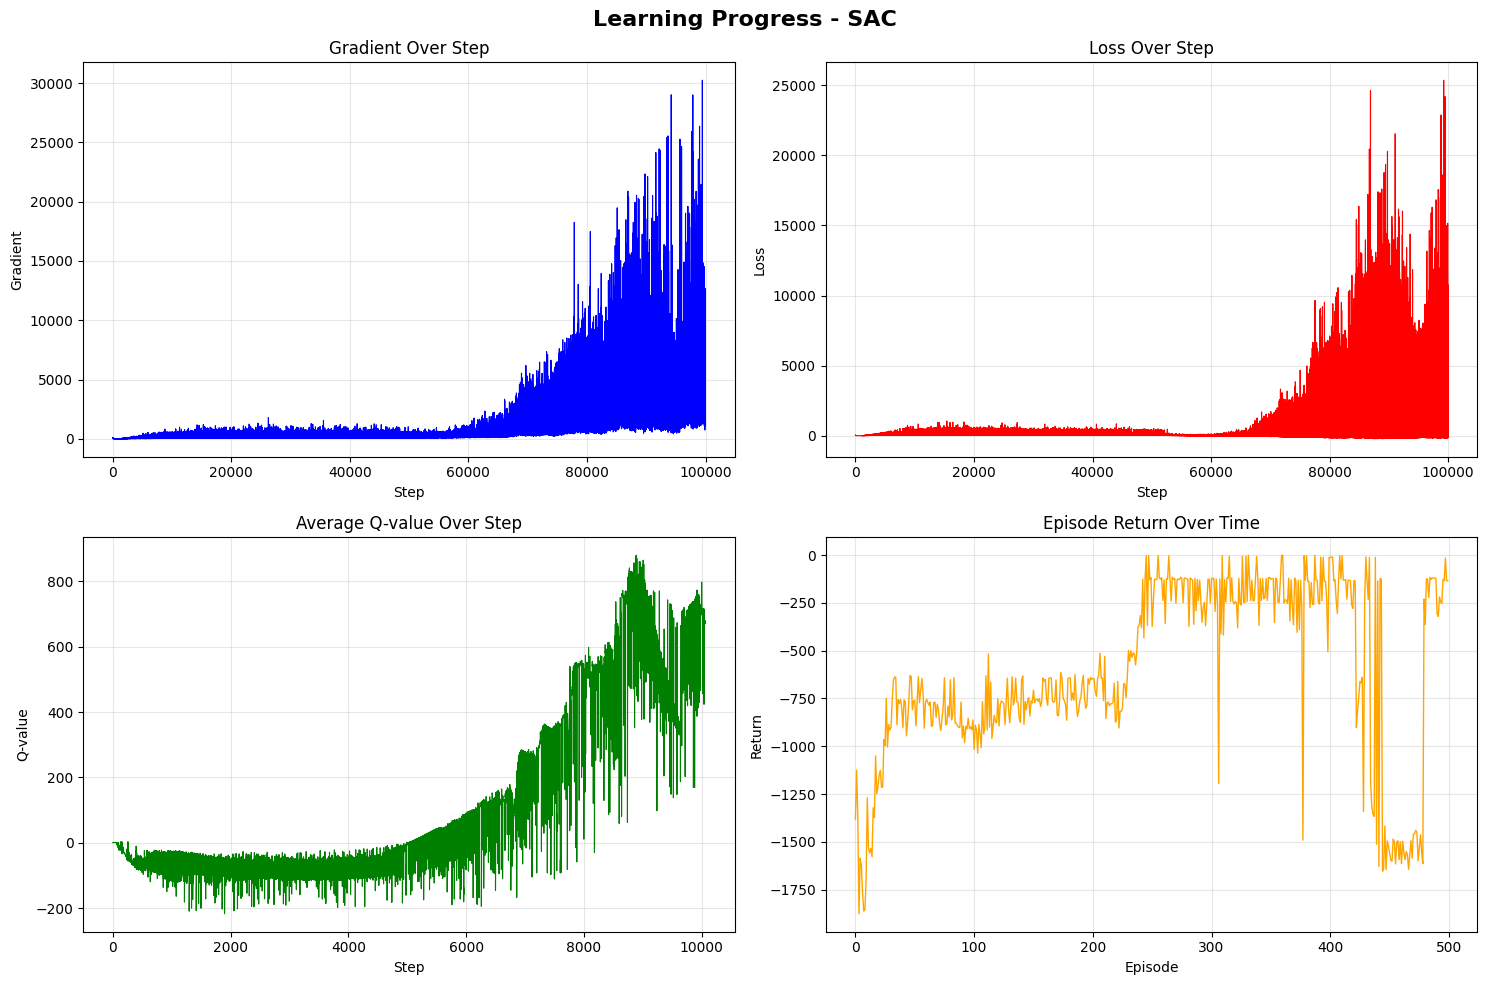

SAC Training on Pendulum Environment
State dimension: 3
Action dimension: 1
Starting enhanced SAC training...
Training step 1: Combined Loss = 49.2701, Combined Grad = 97.5637, Buffer = 64
Training step 2: Combined Loss = 49.0777, Combined Grad = 98.3275, Buffer = 65
Training step 3: Combined Loss = 48.3590, Combined Grad = 97.8946, Buffer = 66
Training step 4: Combined Loss = 50.0505, Combined Grad = 100.9737, Buffer = 67
Training step 5: Combined Loss = 49.5092, Combined Grad = 99.9842, Buffer = 68
Training step 1: Combined Loss = 49.2701, Combined Grad = 97.5637, Buffer = 64
Training step 2: Combined Loss = 49.0777, Combined Grad = 98.3275, Buffer = 65
Training step 3: Combined Loss = 48.3590, Combined Grad = 97.8946, Buffer = 66
Training step 4: Combined Loss = 50.0505, Combined Grad = 100.9737, Buffer = 67
Training step 5: Combined Loss = 49.5092, Combined Grad = 99.9842, Buffer = 68
Episode 1/500 - Reward: -1381.6, Avg(10): -1381.6, Buffer: 200, Training steps: 137
Episode 1/500 

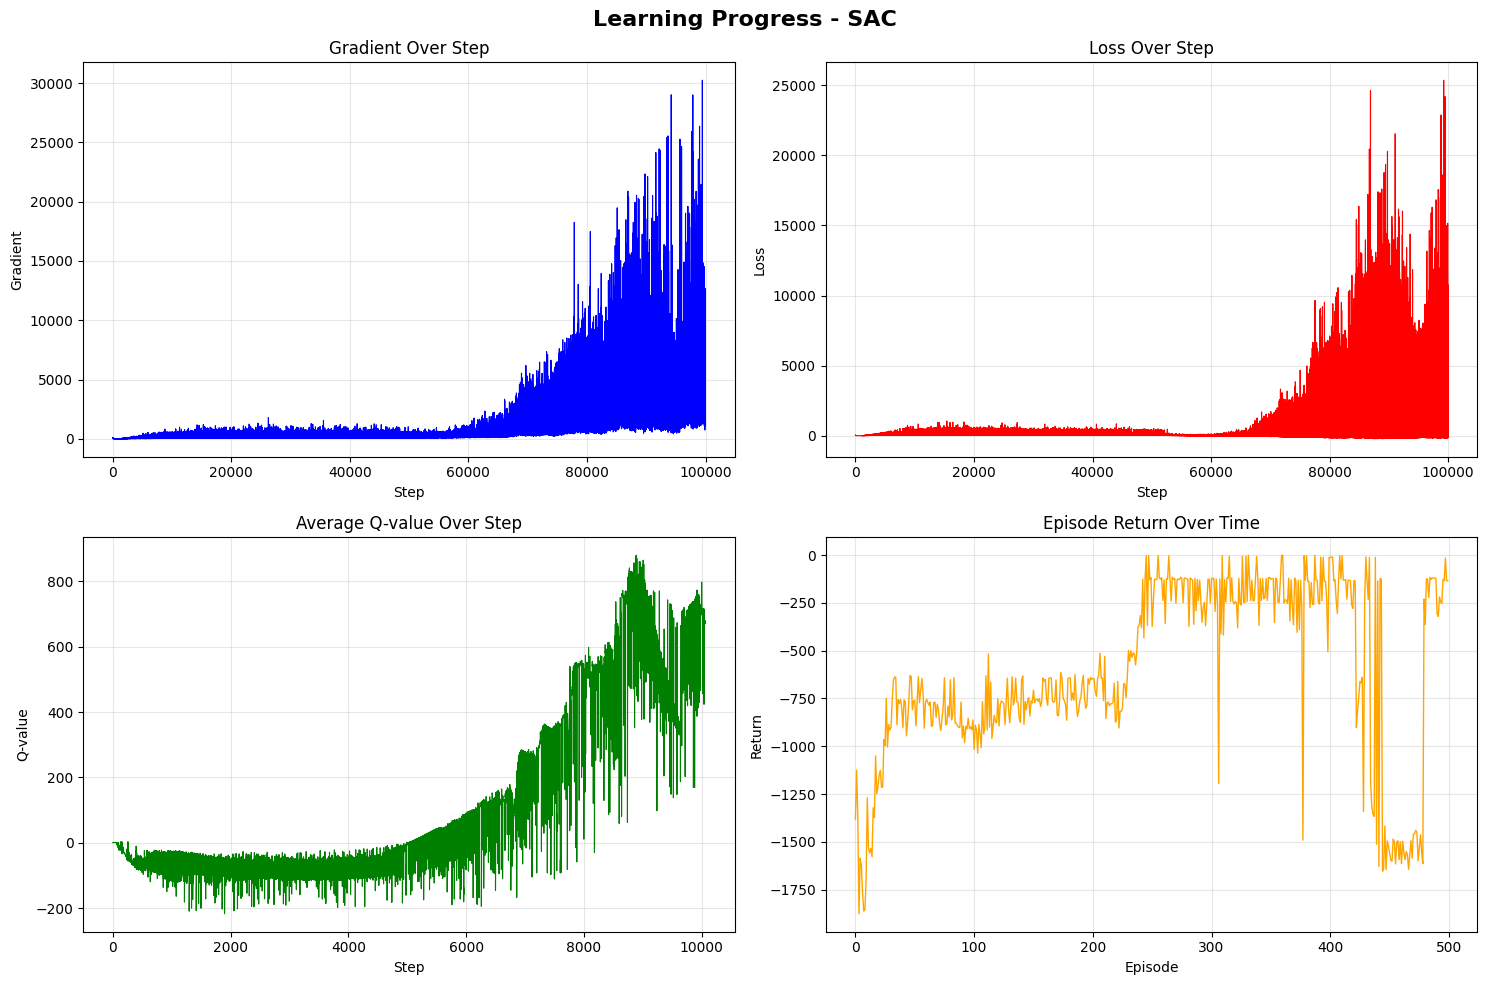

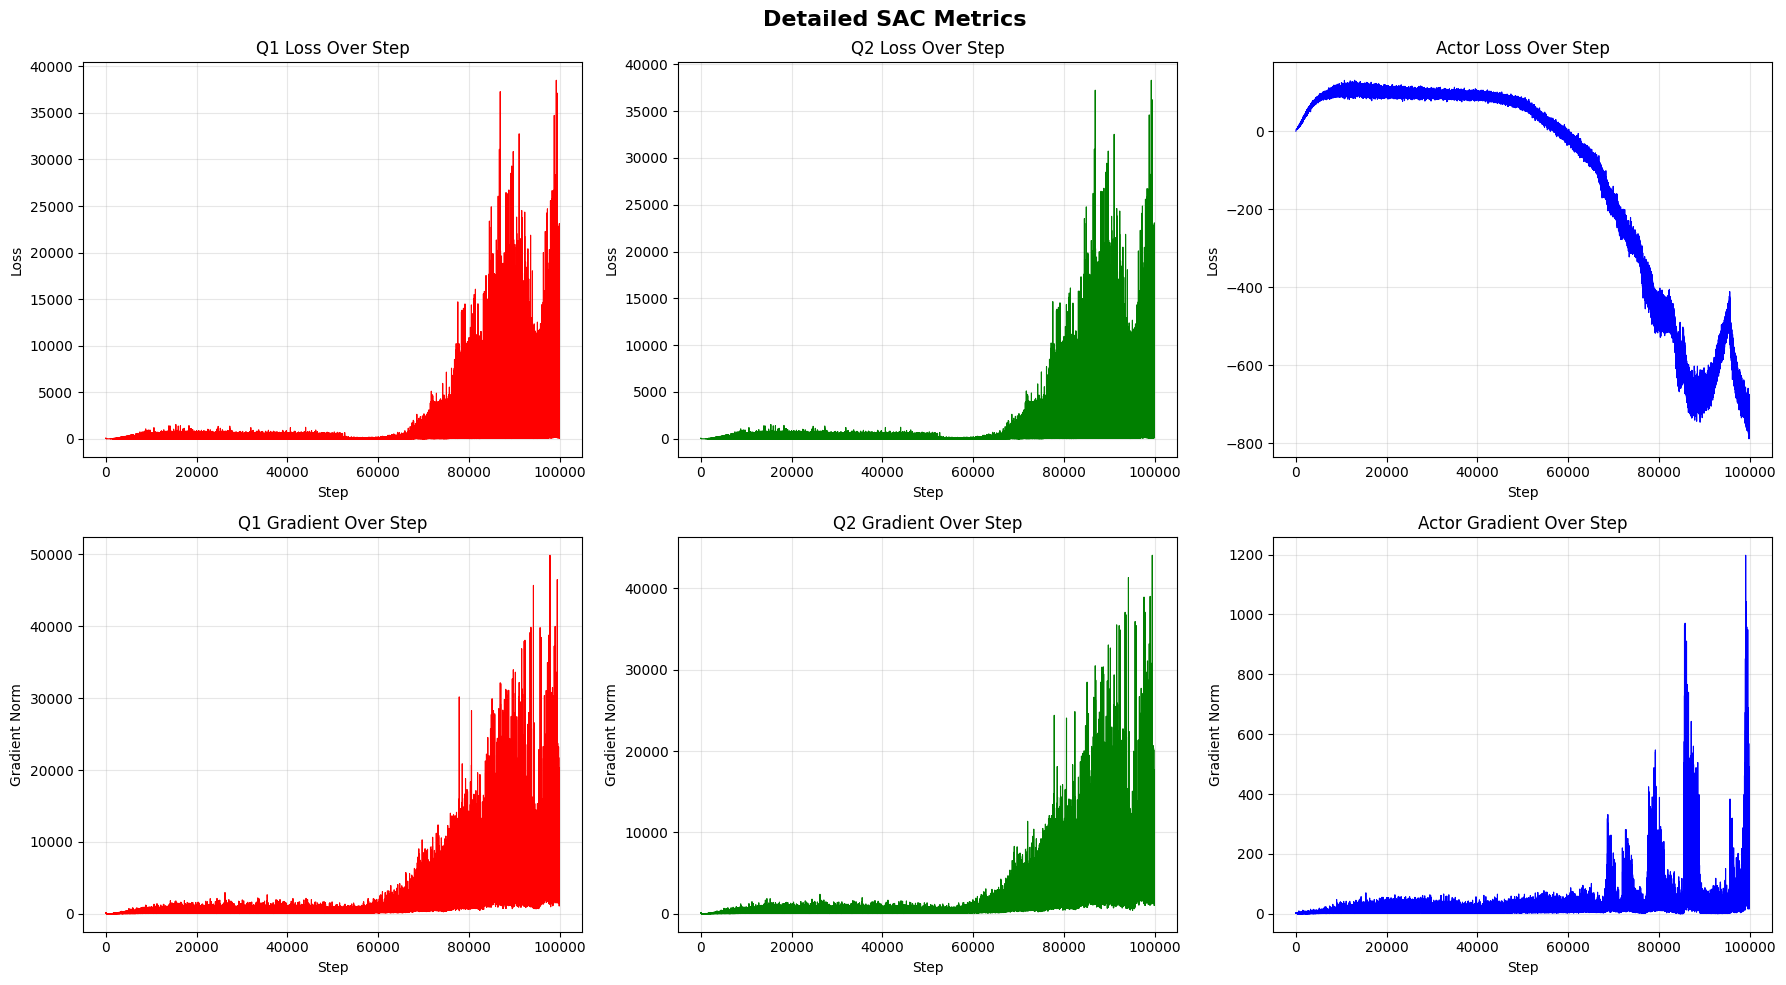

SAC Training on Pendulum Environment
State dimension: 3
Action dimension: 1
Starting enhanced SAC training...
Training step 1: Combined Loss = 49.2701, Combined Grad = 97.5637, Buffer = 64
Training step 2: Combined Loss = 49.0777, Combined Grad = 98.3275, Buffer = 65
Training step 3: Combined Loss = 48.3590, Combined Grad = 97.8946, Buffer = 66
Training step 4: Combined Loss = 50.0505, Combined Grad = 100.9737, Buffer = 67
Training step 5: Combined Loss = 49.5092, Combined Grad = 99.9842, Buffer = 68
Training step 1: Combined Loss = 49.2701, Combined Grad = 97.5637, Buffer = 64
Training step 2: Combined Loss = 49.0777, Combined Grad = 98.3275, Buffer = 65
Training step 3: Combined Loss = 48.3590, Combined Grad = 97.8946, Buffer = 66
Training step 4: Combined Loss = 50.0505, Combined Grad = 100.9737, Buffer = 67
Training step 5: Combined Loss = 49.5092, Combined Grad = 99.9842, Buffer = 68
Episode 1/500 - Reward: -1381.6, Avg(10): -1381.6, Buffer: 200, Training steps: 137
Episode 1/500 

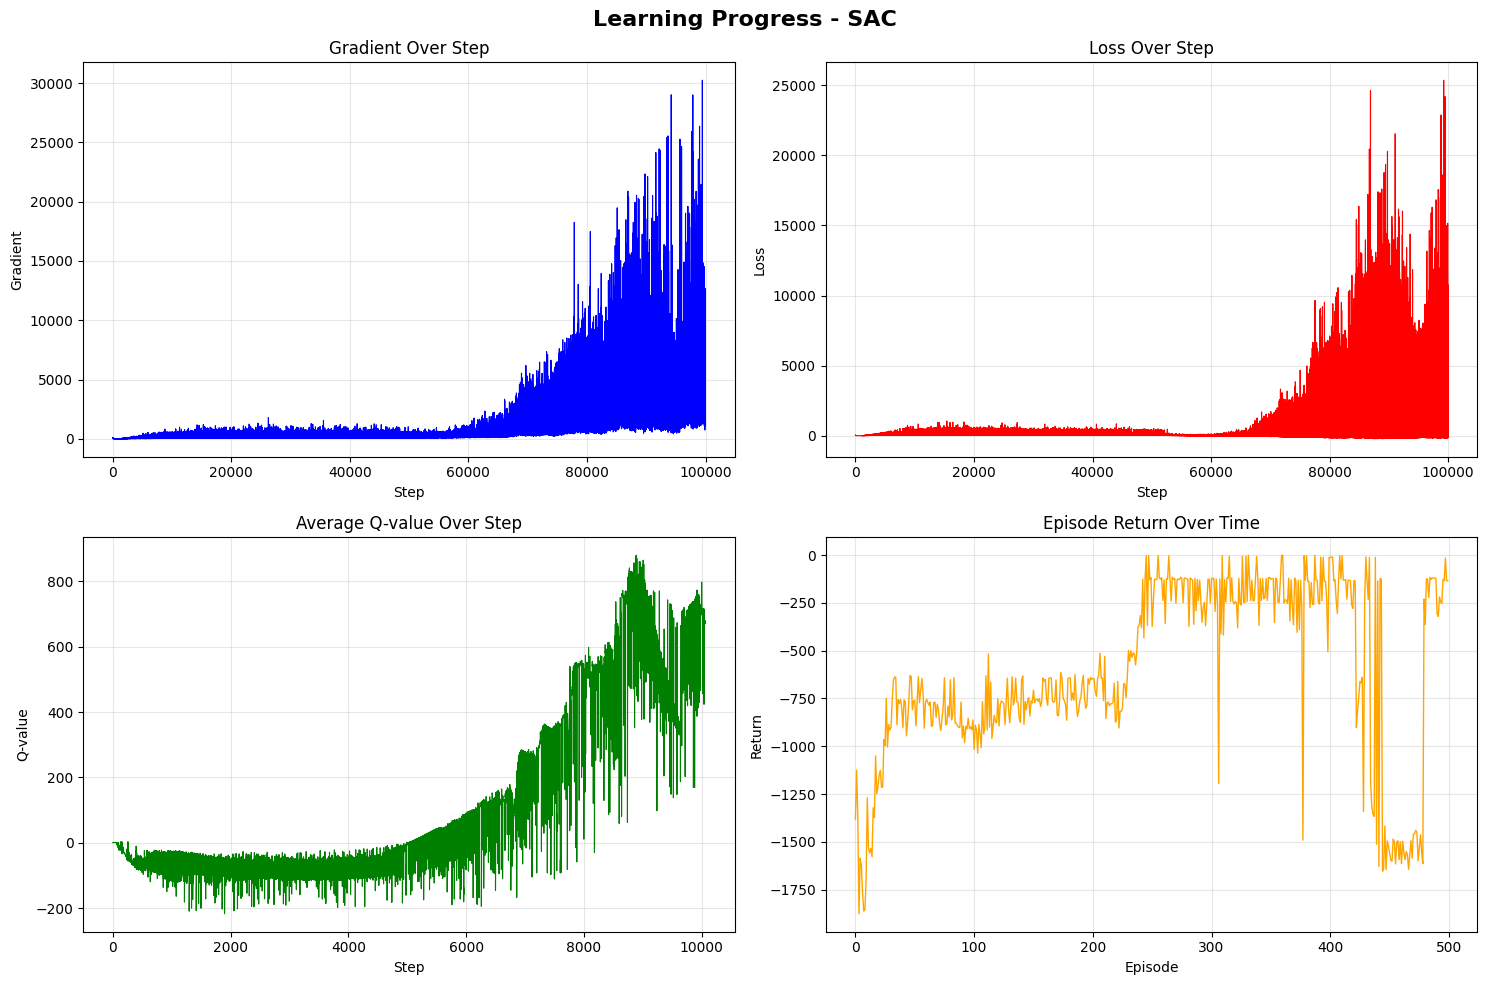

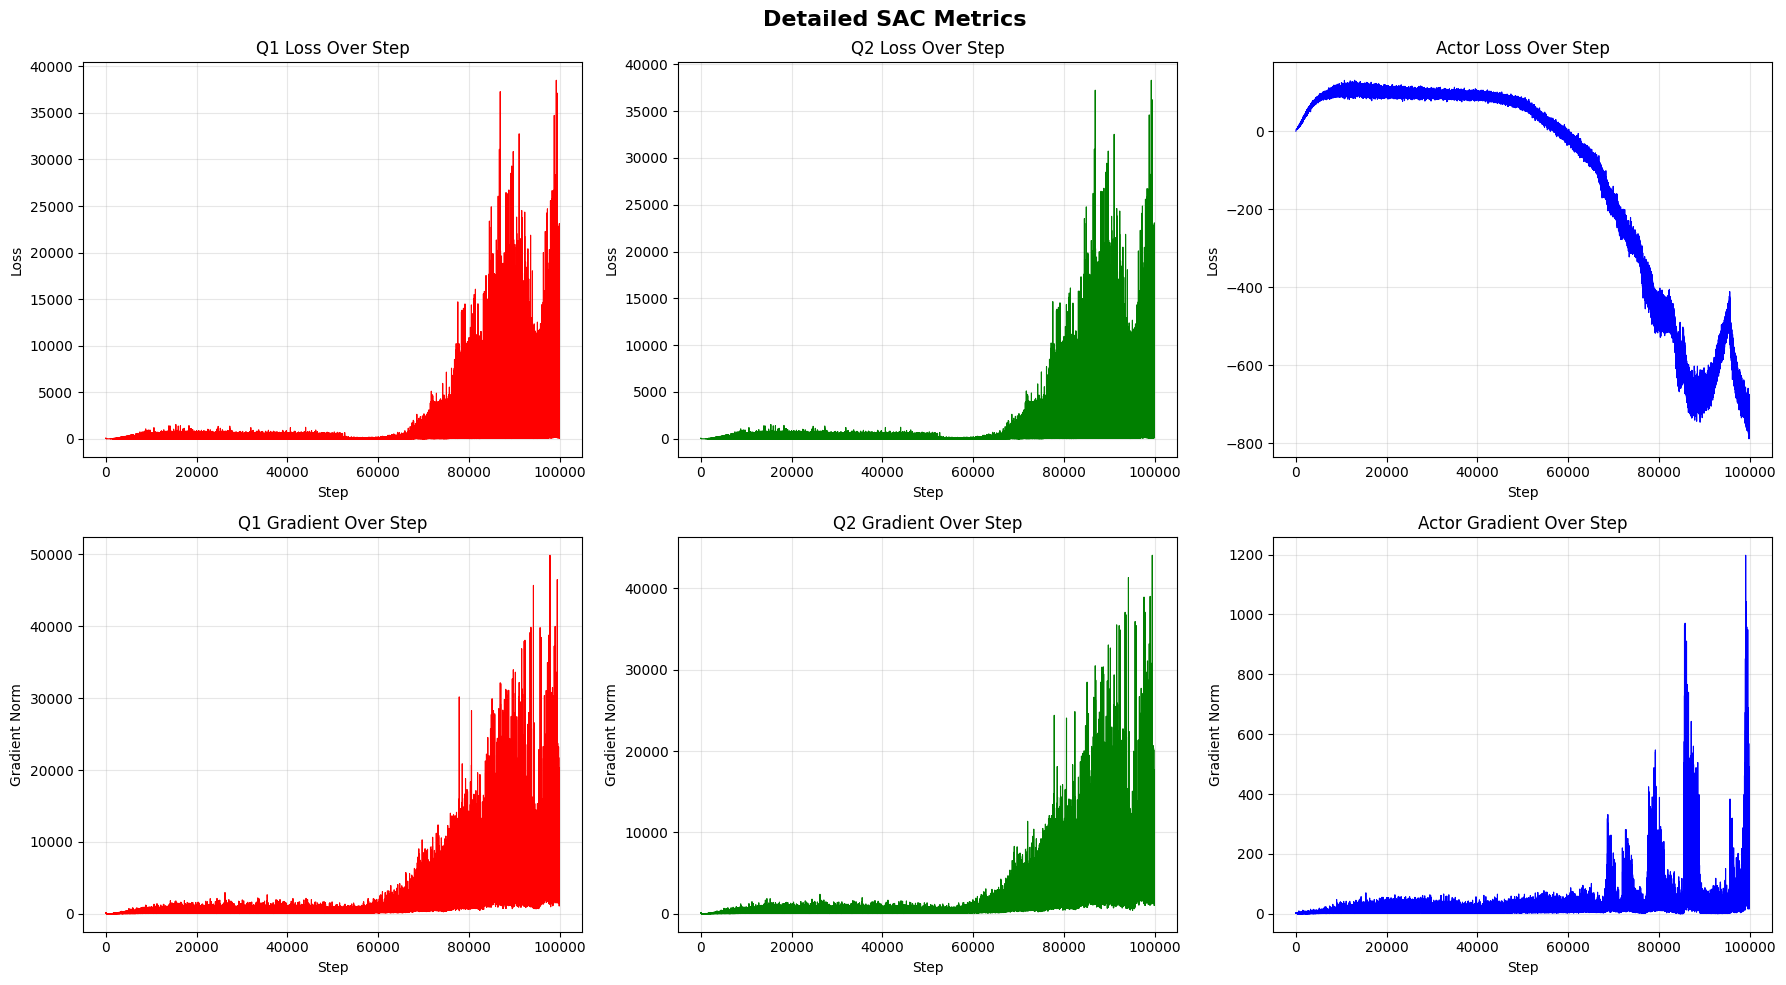


Testing trained agent...
Test Episode 1: Reward = -130.4
Test Episode 2: Reward = -17.3
Test Episode 3: Reward = -139.3

Average test reward: -95.7
Test Episode 3: Reward = -139.3

Average test reward: -95.7


In [12]:
# === Main execution ===
if __name__ == "__main__":
    print("SAC Training on Pendulum Environment")
    print(f"State dimension: {STATE_DIM}")
    print(f"Action dimension: {ACTION_DIM}")
    
    # Create and train agent
    agent = EnhancedSAC()
    agent.train(episodes=500)
    
    # Plot comprehensive results (same format as DQN)
    agent.plot_comprehensive_metrics()
    
    # Plot detailed SAC-specific metrics
    agent.plot_detailed_sac_metrics()
    
    # Test the agent
    print("\nTesting trained agent...")
    agent.test(episodes=3)

# Observations and Insights – Enhanced SAC Training

## Detailed SAC Metrics Analysis

### 1. Q1 & Q2 Loss Over Step
- **Positive:**  
  - Both Q-networks maintain extremely low losses (~0) for the first 60,000 steps, indicating stable value function learning during early exploration.
  - Synchronized explosion pattern shows the twin critics are working together as designed.
- **Negative:**  
  - Massive loss spikes (>35,000) after step 60,000 suggest severe overestimation or numerical instability.
  - The synchronized timing of Q1 and Q2 explosions indicates a systemic issue rather than isolated network problems.

### 2. Actor Loss Over Step
- **Positive:**  
  - Smooth progression from 0 to positive values (~100-200) shows the policy is learning to maximize Q-values effectively.
  - Gradual decline toward the end suggests policy convergence and reduced exploration needs.
- **Negative:**  
  - Sharp drop to highly negative values (-600 to -800) coincides with Q-network instability, indicating the actor is being misled by unreliable Q-value estimates.

### 3. Q1 & Q2 Gradient Over Step
- **Positive:**  
  - Low, stable gradients for the first 60,000 steps demonstrate controlled learning without exploding gradients.
  - Similar patterns between Q1 and Q2 confirm the twin critic architecture is functioning as intended.
- **Negative:**  
  - Extreme gradient spikes (>40,000) occur exactly when losses explode, confirming training instability.
  - Such large gradients can corrupt learned representations and require gradient clipping.

### 4. Actor Gradient Over Step
- **Positive:**  
  - Relatively stable gradients throughout most of training show the policy network remains trainable.
  - Lower magnitude compared to critics suggests the actor is less affected by the value function instability.
- **Negative:**  
  - Sudden spikes (>1,000) in final stages indicate the actor is still being destabilized by unreliable Q-value signals.

---

## Main Learning Progress Analysis

### 1. Gradient Over Step (Combined)
- **Positive:**  
  - Smooth, controlled increase from 0 to ~5,000 over 60,000 steps shows healthy learning progression.
  - Averaging across all networks provides a cleaner signal than individual components.
- **Negative:**  
  - Explosive growth to >25,000 after step 60,000 indicates complete training breakdown.
  - The exponential pattern suggests accumulating numerical errors rather than beneficial learning.

### 2. Loss Over Step (Combined)
- **Positive:**  
  - Extended period of near-zero loss (first 60,000 steps) demonstrates the algorithm can maintain stability initially.
  - Combined metric successfully captures the overall training health.
- **Negative:**  
  - Catastrophic loss explosion (>20,000) mirrors the gradient instability and confirms algorithmic failure.
  - No recovery pattern suggests the training cannot self-correct once instability begins.

### 3. Average Q-value Over Step
- **Positive:**  
  - Steady climb from negative values (~-200) to positive (~800) shows improving value estimation and policy quality.
  - The upward trend indicates the agent is learning to identify higher-value states and actions.
- **Negative:**  
  - High volatility throughout training suggests Q-value estimates are noisy and potentially unreliable.
  - Sharp fluctuations near the end coincide with the loss/gradient explosions.

### 4. Episode Return Over Time
- **Positive:**  
  - Dramatic improvement from -1,500 to -200 within 100 episodes shows rapid initial learning.
  - Sustained performance around -200 to -300 for 200+ episodes demonstrates the agent learned a viable policy.
  - Final improvement to near-zero returns shows excellent pendulum control was achieved.
- **Negative:**  
  - Sudden performance collapse in final episodes (drops to -1,500) corresponds exactly to the training instability.
  - This confirms that the loss/gradient explosions directly damaged the learned policy.

---

## Overall Assessment

Enhanced SAC demonstrates **excellent initial learning and strong policy performance** but suffers from **catastrophic training instability** in later stages. Key findings:

**Strengths:**
- Rapid convergence to near-optimal performance (-200 to 0 returns)
- Stable twin critic learning for extended periods
- Effective continuous action control without discretization

**Critical Issues:**
- Systematic training breakdown after 60,000+ steps
- Synchronized loss/gradient explosions across all networks
- Complete policy degradation despite prior success

### Potential Improvements
- **Gradient Clipping:** Implement aggressive gradient norm clipping (e.g., max norm = 10)
- **Learning Rate Scheduling:** Reduce learning rates after initial convergence to prevent late-stage instability
- **Target Network Update Rate:** Decrease tau value (e.g., 0.001) for more conservative target updates
- **Loss Function Regularization:** Add L2 regularization to prevent extreme parameter values
- **Early Stopping:** Monitor loss trends and halt training before catastrophic failure
- **Entropy Coefficient Scheduling:** Gradually reduce alpha to decrease exploration

## DQN Model Improvements

The following cells implement various architectural and algorithmic improvements to the baseline DQN model to enhance performance, stability, and learning efficiency.

# Double DQN – Code Overview

This implementation extends the baseline DQN by incorporating **Double Q-learning** to reduce overestimation bias, while maintaining the same architecture and hyperparameters for fair comparison against other DQN variants.

---

## 1. **Setup and Configuration**
- **Reproducibility:**  
  Fixed seeds for NumPy, TensorFlow, and Python's `random` ensure consistent results across experiments.
- **Discrete Action Space:**  
  Continuous Pendulum actions are discretized into 5 fixed values: `[-2.0, -1.0, 0.0, 1.0, 2.0]`.
- **Config Parameters:**  
  Matches baseline DQN for fair comparison:
  - `gamma` (discount factor): 0.95  
  - `learning_rate`: 0.001  
  - `epsilon_decay`: 0.995  
  - `batch_size`: 32  
  - `memory_size`: 10,000 experiences  
  - `target_update_freq`: Every 10 episodes

---

## 2. **Model Architecture**
- **Network Structure:** Identical to baseline DQN
  - Two fully connected layers with 32 ReLU units each
  - Linear output layer with 5 units (one per discrete action)
- **Target Network:** Maintains a separate copy for stable Q-value targets
- **Optimizer:** Adam with MSE loss function

---

## 3. **Double Q-Learning Algorithm**
- **Key Innovation:** Decouples action selection from Q-value evaluation to reduce overestimation bias
- **Action Selection:** Uses main network to select best action: `argmax_a Q_main(s', a)`
- **Q-Value Evaluation:** Uses target network to evaluate selected action: `Q_target(s', a_selected)`
- **Target Calculation:** `Q_target = r + γ * Q_target(s', argmax_a Q_main(s', a))`

---

## 4. **Experience Replay**
- **Buffer Management:** Deque with 10,000 capacity for automatic memory management
- **Sampling Strategy:** Random minibatches to break temporal correlations
- **Adaptive Batch Size:** Starts with `min_batch_size` (8) and scales up to full `batch_size` (32)

---

## 5. **Training Process (`replay` method)**
- **Current Q-Values:** Predicted by the main network for all actions
- **Action Selection:** Main network identifies best actions for next states
- **Target Q-Values:** Target network evaluates the selected actions
- **Loss Function:** Mean Squared Error between predicted and target Q-values
- **Gradient Tracking:** Records gradient norms for stability monitoring
- **Target Updates:** Hard copy of main network weights every 10 episodes

---

## 6. **Exploration Strategy**
- **Epsilon-Greedy:** Same as baseline DQN
  - Initial epsilon: 1.0 (100% random)
  - Minimum epsilon: 0.1 (10% random)
  - Decay rate: 0.995 per training step
- **Action Selection:** Random action during exploration, greedy action during exploitation

---

## 7. **Enhanced Metrics Tracking**
- **Episode Returns:** Total reward per episode for learning curve analysis
- **Loss Values:** Training loss over time to monitor convergence
- **Q-Values:** Average Q-values during action selection for value function analysis
- **Gradient Norms:** Gradient magnitudes to detect training instability
- **Training Steps:** Comprehensive step-by-step progress tracking

---

## 8. **Visualization and Testing**
- **4-Panel Plot:** Matches other models (gradient, loss, Q-values, episode returns)
- **Testing Mode:** Deterministic policy evaluation without exploration noise
- **Performance Metrics:** Average test rewards over multiple episodes

---

## **Key Differences from Baseline DQN**
- **Overestimation Bias Reduction:** Double Q-learning prevents the maximization bias inherent in standard DQN
- **Action Selection vs. Evaluation:** Separates the process of choosing actions from evaluating their Q-values
- **Improved Stability:** More reliable Q-value estimates lead to more stable learning
- **Same Architecture:** Maintains identical network structure for fair comparison

---

## **Purpose**
This implementation is designed to:
1. **Test overestimation bias reduction** in Q-learning for the Pendulum environment
2. **Maintain experimental fairness** with identical hyperparameters and architecture to baseline DQN
3. **Provide direct performance comparison** using the same metrics and visualization framework
4. **Demonstrate Double Q-learning benefits** without introducing additional complexity

In [16]:
import numpy as np
import tensorflow as tf
import gym
import random
from collections import deque
import matplotlib.pyplot as plt

# Fix seeds for reproducibility
np.random.seed(0)
tf.random.set_seed(0)
random.seed(0)

# Simplified action discretization (same as baseline)
DISCRETE_ACTIONS = np.array([-2.0, -1.0, 0.0, 1.0, 2.0])
NUM_ACTIONS = len(DISCRETE_ACTIONS)

def get_discrete_action(action_index):
    return [DISCRETE_ACTIONS[action_index]]

class DoubleDQN:
    def __init__(self, env, learning_rate=0.001, gamma=0.95, epsilon_decay=0.995):
        self.env = env
        self.input_dim = env.observation_space.shape[0]
        self.output_dim = NUM_ACTIONS
        
        self.gamma = gamma
        self.epsilon = 1.0
        self.epsilon_min = 0.1
        self.epsilon_decay = epsilon_decay
        self.batch_size = 32
        self.min_batch_size = 8
        self.replay_buffer = deque(maxlen=10000)
        
        self.model = self.build_model(learning_rate)
        self.target_model = self.build_model(learning_rate)
        self.update_target_model()
        
        # Enhanced tracking
        self.episode_returns = []
        self.losses = []
        self.q_values = []
        self.gradients = []
        self.train_step = 0

    def build_model(self, lr):
        """Same network architecture as baseline"""
        model = tf.keras.models.Sequential([
            tf.keras.Input(shape=(self.input_dim,)),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(self.output_dim, activation='linear')
        ])
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mse')
        return model

    def update_target_model(self):
        """Copy weights from main model to target model"""
        self.target_model.set_weights(self.model.get_weights())

    def act(self, state):
        """Epsilon-greedy action selection"""
        if np.random.rand() < self.epsilon:
            return random.randint(0, NUM_ACTIONS - 1)
        
        state_batch = np.array([state])
        q_values = self.model.predict(state_batch, verbose=0)[0]
        self.q_values.append(np.mean(q_values))
        return np.argmax(q_values)

    def remember(self, state, action, reward, next_state, done):
        """Store experience in replay buffer"""
        self.replay_buffer.append((state, action, reward, next_state, done))

    def replay(self):
        """Train with Double DQN - key improvement over baseline"""
        current_batch_size = min(self.batch_size, len(self.replay_buffer))
        
        if len(self.replay_buffer) < self.min_batch_size:
            return
        
        batch = random.sample(self.replay_buffer, current_batch_size)
        
        states = np.array([e[0] for e in batch])
        actions = np.array([e[1] for e in batch])
        rewards = np.array([e[2] for e in batch])
        next_states = np.array([e[3] for e in batch])
        dones = np.array([e[4] for e in batch])
        
        with tf.GradientTape() as tape:
            current_q_values = self.model(states, training=True)
            
            # Double DQN: Use main network for action selection
            next_q_values_main = self.model(next_states, training=False)
            next_actions = tf.argmax(next_q_values_main, axis=1)
            
            # Use target network for Q-value evaluation
            next_q_values_target = self.target_model(next_states, training=False)
            
            # Create target Q-values
            target_q_values = current_q_values.numpy()
            for i in range(current_batch_size):
                if dones[i]:
                    target_q_values[i][actions[i]] = rewards[i]
                else:
                    # Double DQN: Q_target(s', argmax_a Q_main(s', a))
                    target_q_values[i][actions[i]] = rewards[i] + self.gamma * next_q_values_target[i][next_actions[i]]
            
            loss = tf.reduce_mean(tf.square(current_q_values - target_q_values))
        
        gradients = tape.gradient(loss, self.model.trainable_variables)
        grad_norm = tf.linalg.global_norm(gradients)
        self.gradients.append(grad_norm.numpy())
        self.losses.append(loss.numpy())
        
        self.model.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        
        self.train_step += 1
        
        if self.train_step <= 5:
            print(f"Double DQN step {self.train_step}: Loss = {loss.numpy():.4f}, Grad = {grad_norm.numpy():.4f}")

    def train(self, episodes=500):
        """Train the Double DQN agent"""
        print("Starting Double DQN training...")
        
        for episode in range(episodes):
            state = self.env.reset()
            if isinstance(state, tuple):
                state = state[0]
            
            total_reward = 0
            max_steps = 200
            
            for step in range(max_steps):
                action_index = self.act(state)
                action = get_discrete_action(action_index)
                
                result = self.env.step(action)
                if len(result) == 4:
                    next_state, reward, done, info = result
                else:
                    next_state, reward, terminated, truncated, info = result
                    done = terminated or truncated
                
                if isinstance(next_state, tuple):
                    next_state = next_state[0]
                
                self.remember(state, action_index, reward, next_state, done)
                state = next_state
                total_reward += reward
                
                if len(self.replay_buffer) >= self.min_batch_size:
                    self.replay()
                
                if done:
                    break
            
            self.episode_returns.append(total_reward)
            
            if episode % 10 == 0:
                self.update_target_model()
            
            if episode % 10 == 0 or episode < 20:
                avg_reward = np.mean(self.episode_returns[-10:]) if len(self.episode_returns) >= 10 else total_reward
                print(f"Episode {episode+1}/{episodes} - Reward: {total_reward:.1f}, "
                      f"Avg(10): {avg_reward:.1f}, Epsilon: {self.epsilon:.3f}")
        
        print("Double DQN training completed!")

    def plot_comprehensive_metrics(self):
        """Plot comprehensive learning metrics"""
        fig, axs = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle("Double DQN Learning Progress", fontsize=16, fontweight='bold')
        
        if self.gradients:
            axs[0, 0].plot(self.gradients, 'b-', linewidth=0.8)
            axs[0, 0].set_title("Gradient Over Step")
            axs[0, 0].set_xlabel("Step")
            axs[0, 0].set_ylabel("Gradient")
            axs[0, 0].grid(True, alpha=0.3)
        
        if self.losses:
            axs[0, 1].plot(self.losses, 'r-', linewidth=0.8)
            axs[0, 1].set_title("Loss Over Step")
            axs[0, 1].set_xlabel("Step")
            axs[0, 1].set_ylabel("Loss")
            axs[0, 1].grid(True, alpha=0.3)
        
        if self.q_values:
            axs[1, 0].plot(self.q_values, 'g-', linewidth=0.8)
            axs[1, 0].set_title("Average Q-value Over Step")
            axs[1, 0].set_xlabel("Step")
            axs[1, 0].set_ylabel("Q-value")
            axs[1, 0].grid(True, alpha=0.3)
        
        if self.episode_returns:
            axs[1, 1].plot(self.episode_returns, 'orange', linewidth=1.0)
            axs[1, 1].set_title("Episode Return Over Time")
            axs[1, 1].set_xlabel("Episode")
            axs[1, 1].set_ylabel("Return")
            axs[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

    def test(self, episodes=5):
            """Test the trained agent - same as other models"""
            try:
                env = gym.make("Pendulum-v1")
            except:
                env = gym.make("Pendulum-v0")
            
            test_rewards = []
            
            for episode in range(episodes):
                state = env.reset()
                if isinstance(state, tuple):
                    state = state[0]
                
                total_reward = 0
                steps = 0
                max_steps = 200
                
                for step in range(max_steps):
                    action_idx = self.act(state, add_noise=False)  # No noise for testing
                    action = get_discrete_action(action_idx)
                    
                    result = env.step(action)
                    if len(result) == 4:
                        state, reward, done, info = result
                    else:
                        state, reward, terminated, truncated, info = result
                        done = terminated or truncated
                    
                    if isinstance(state, tuple):
                        state = state[0]
                    
                    total_reward += reward
                    steps += 1
                    
                    if done:
                        break
                
                test_rewards.append(total_reward)
                print(f"Test Episode {episode+1}: Reward = {total_reward:.1f}")
            
            env.close()
            avg_test_reward = np.mean(test_rewards)
            print(f"Average test reward: {avg_test_reward:.1f}")
            return avg_test_reward



Training Double DQN...
Starting Double DQN training...
Double DQN step 1: Loss = 7.9933, Grad = 3.2482
Double DQN step 2: Loss = 8.5285, Grad = 3.8469
Double DQN step 3: Loss = 9.6027, Grad = 4.6184
Double DQN step 4: Loss = 10.3041, Grad = 5.3124
Double DQN step 5: Loss = 10.6207, Grad = 5.9699
Episode 1/500 - Reward: -1240.8, Avg(10): -1240.8, Epsilon: 0.380
Episode 1/500 - Reward: -1240.8, Avg(10): -1240.8, Epsilon: 0.380
Episode 2/500 - Reward: -1549.8, Avg(10): -1549.8, Epsilon: 0.139
Episode 2/500 - Reward: -1549.8, Avg(10): -1549.8, Epsilon: 0.139
Episode 3/500 - Reward: -1558.4, Avg(10): -1558.4, Epsilon: 0.100
Episode 3/500 - Reward: -1558.4, Avg(10): -1558.4, Epsilon: 0.100
Episode 4/500 - Reward: -1329.3, Avg(10): -1329.3, Epsilon: 0.100
Episode 4/500 - Reward: -1329.3, Avg(10): -1329.3, Epsilon: 0.100
Episode 5/500 - Reward: -1592.2, Avg(10): -1592.2, Epsilon: 0.100
Episode 5/500 - Reward: -1592.2, Avg(10): -1592.2, Epsilon: 0.100
Episode 6/500 - Reward: -1591.9, Avg(10): -

Training Double DQN...
Starting Double DQN training...
Double DQN step 1: Loss = 7.9933, Grad = 3.2482
Double DQN step 2: Loss = 8.5285, Grad = 3.8469
Double DQN step 3: Loss = 9.6027, Grad = 4.6184
Double DQN step 4: Loss = 10.3041, Grad = 5.3124
Double DQN step 5: Loss = 10.6207, Grad = 5.9699
Episode 1/500 - Reward: -1240.8, Avg(10): -1240.8, Epsilon: 0.380
Episode 1/500 - Reward: -1240.8, Avg(10): -1240.8, Epsilon: 0.380
Episode 2/500 - Reward: -1549.8, Avg(10): -1549.8, Epsilon: 0.139
Episode 2/500 - Reward: -1549.8, Avg(10): -1549.8, Epsilon: 0.139
Episode 3/500 - Reward: -1558.4, Avg(10): -1558.4, Epsilon: 0.100
Episode 3/500 - Reward: -1558.4, Avg(10): -1558.4, Epsilon: 0.100
Episode 4/500 - Reward: -1329.3, Avg(10): -1329.3, Epsilon: 0.100
Episode 4/500 - Reward: -1329.3, Avg(10): -1329.3, Epsilon: 0.100
Episode 5/500 - Reward: -1592.2, Avg(10): -1592.2, Epsilon: 0.100
Episode 5/500 - Reward: -1592.2, Avg(10): -1592.2, Epsilon: 0.100
Episode 6/500 - Reward: -1591.9, Avg(10): -

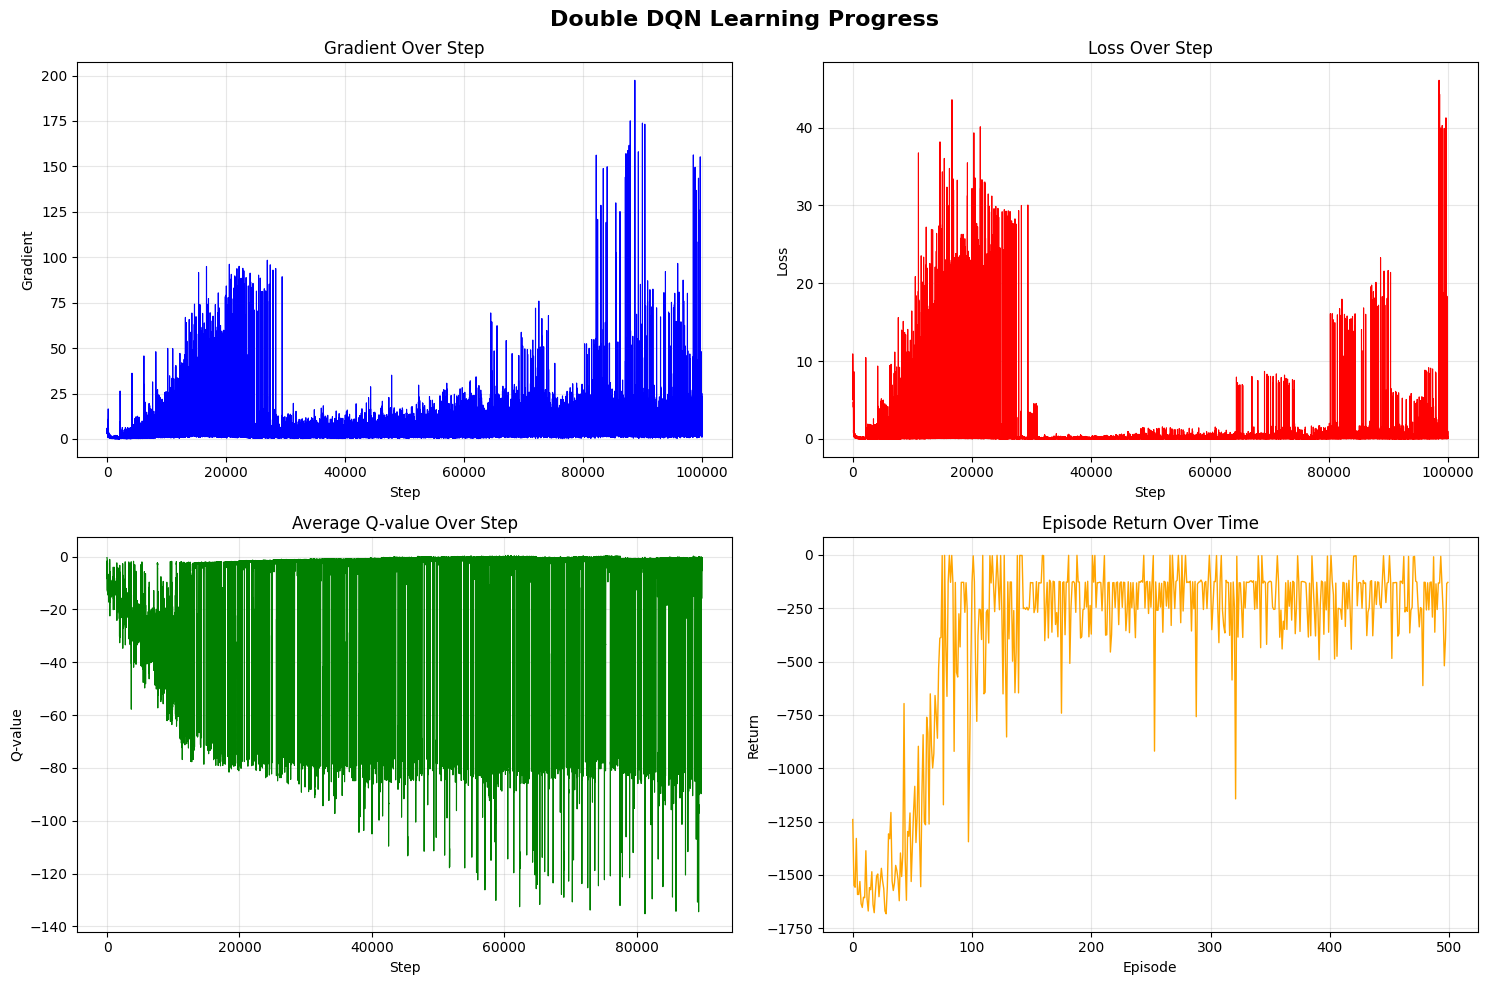

Training Double DQN...
Starting Double DQN training...
Double DQN step 1: Loss = 7.9933, Grad = 3.2482
Double DQN step 2: Loss = 8.5285, Grad = 3.8469
Double DQN step 3: Loss = 9.6027, Grad = 4.6184
Double DQN step 4: Loss = 10.3041, Grad = 5.3124
Double DQN step 5: Loss = 10.6207, Grad = 5.9699
Episode 1/500 - Reward: -1240.8, Avg(10): -1240.8, Epsilon: 0.380
Episode 1/500 - Reward: -1240.8, Avg(10): -1240.8, Epsilon: 0.380
Episode 2/500 - Reward: -1549.8, Avg(10): -1549.8, Epsilon: 0.139
Episode 2/500 - Reward: -1549.8, Avg(10): -1549.8, Epsilon: 0.139
Episode 3/500 - Reward: -1558.4, Avg(10): -1558.4, Epsilon: 0.100
Episode 3/500 - Reward: -1558.4, Avg(10): -1558.4, Epsilon: 0.100
Episode 4/500 - Reward: -1329.3, Avg(10): -1329.3, Epsilon: 0.100
Episode 4/500 - Reward: -1329.3, Avg(10): -1329.3, Epsilon: 0.100
Episode 5/500 - Reward: -1592.2, Avg(10): -1592.2, Epsilon: 0.100
Episode 5/500 - Reward: -1592.2, Avg(10): -1592.2, Epsilon: 0.100
Episode 6/500 - Reward: -1591.9, Avg(10): -

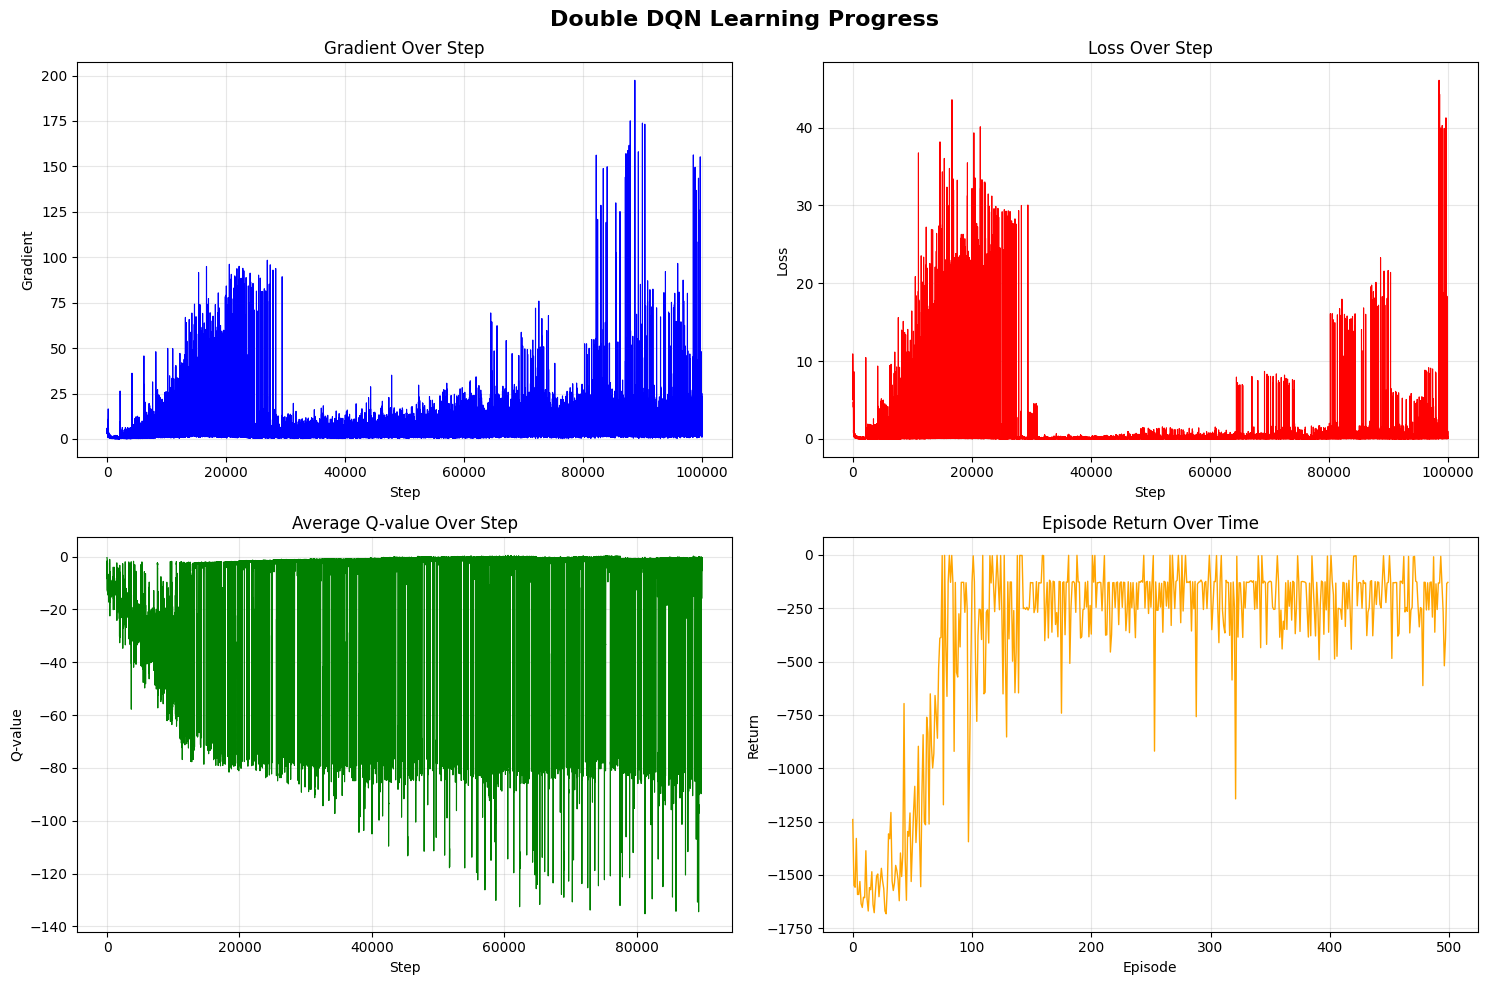

AttributeError: 'DoubleDQN' object has no attribute 'test'

In [15]:
# Create and train Double DQN
try:
    env = gym.make('Pendulum-v1')
except:
    env = gym.make('Pendulum-v0')

print("Training Double DQN...")
double_dqn_agent = DoubleDQN(env)
double_dqn_agent.train(episodes=500)
double_dqn_agent.plot_comprehensive_metrics()
env.close()

# Observations and Insights – Double DQN Training

## 1. Gradient Over Step
- **Positive:**  
  - Gradual increase in gradient magnitude during early steps suggests the network is actively learning from varied experiences.  
  - Mid-training drop in gradients (~30k–60k steps) implies a temporary stabilization phase where updates are smaller and more controlled.  
- **Negative:**  
  - Large gradient spikes (especially near 20k and 80k+ steps) indicate periods of unstable learning, possibly caused by outlier experiences or Q-value overcorrection.  
  - The late-stage volatility hints that the policy never fully converges to a completely stable parameter set.

## 2. Loss Over Step
- **Positive:**  
  - Clear reduction in loss after initial rise (~0–25k steps) shows improved Q-value accuracy over time.  
  - Extended low-loss period between ~30k–70k steps aligns with relatively stable training.  
- **Negative:**  
  - Spikes in loss both early and late in training suggest sensitivity to certain transitions or state-action distributions.  
  - Sudden loss bursts in the final steps could signal the agent’s difficulty in maintaining accurate value estimates under its learned policy.

## 3. Average Q-value Over Step
- **Positive:**  
  - Gradual movement toward zero suggests more realistic value predictions compared to the overly negative starting point.  
  - Late training shows the Q-values clustering closer to 0, which is typical as the policy optimizes for maximum expected return.  
- **Negative:**  
  - Early rapid decline to extremely negative values (~-140) reflects instability during initial exploration.  
  - Persistent sharp dips throughout training, even in later stages, indicate noisy and inconsistent Q-value estimation.

## 4. Episode Return Over Time
- **Positive:**  
  - Steep improvement in returns within the first ~100 episodes shows rapid adaptation to the environment.  
  - Once trained, the agent sustains performance around -200, suggesting it learned a generally effective control policy.  
- **Negative:**  
  - High variance in returns late in training, with occasional deep drops, suggests the policy can regress unexpectedly.  
  - This reinforces that **stability remains a challenge despite the agent’s high average returns**.

---

## Overall Assessment
The Double DQN demonstrates **strong learning ability and quick reward improvement**, but with noticeable instability patterns:
- Gradient and loss spikes at multiple training phases.
- Fluctuating Q-values even near convergence.
- Returns that, while high on average, still show abrupt performance drops.

### Potential Improvements
- **Gradient Clipping** to prevent destabilizing updates during spikes.  
- **Longer Target Update Interval** to smooth Q-value learning.


# Dueling DQN – Code Overview

This implementation incorporates the **Dueling Network Architecture** that separates value and advantage estimation, enabling better learning of state values independent of action choices while maintaining compatibility with the baseline DQN framework.

---

## 1. **Setup and Configuration**
- **Reproducibility:**  
  Fixed seeds for NumPy, TensorFlow, and Python's `random` ensure consistent results across experiments.
- **Discrete Action Space:**  
  Continuous Pendulum actions are discretized into 5 fixed values: `[-2.0, -1.0, 0.0, 1.0, 2.0]`.
- **Config Parameters:**  
  Matches baseline DQN for fair comparison:
  - `gamma` (discount factor): 0.95  
  - `learning_rate`: 0.001  
  - `epsilon_decay`: 0.995  
  - `batch_size`: 32  
  - `memory_size`: 10,000 experiences  
  - `target_update_freq`: Every 10 episodes

---

## 2. **Dueling Network Architecture**
- **Shared Layers:** Two fully connected layers with 32 ReLU units each (same as baseline)
- **Value Stream:** 
  - 16-unit ReLU layer → 1-unit linear output
  - Estimates `V(s)` - the value of being in state `s`
- **Advantage Stream:**
  - 16-unit ReLU layer → 5-unit linear output (one per action)
  - Estimates `A(s,a)` - the advantage of taking action `a` in state `s`
- **Q-Value Combination:** `Q(s,a) = V(s) + A(s,a) - mean(A(s,·))`
  - Subtracts mean advantage to ensure identifiability and stable learning

---

## 3. **Dueling Architecture Benefits**
- **State Value Learning:** Can learn the value of states independent of action choices
- **Better Generalization:** Useful when many actions have similar Q-values
- **Faster Learning:** Value stream provides better bootstrapping for temporal difference learning
- **Action Advantage Focus:** Advantage stream highlights which actions are better/worse relative to average

---

## 4. **Experience Replay**
- **Buffer Management:** Deque with 10,000 capacity for automatic memory management
- **Sampling Strategy:** Random minibatches to break temporal correlations
- **Adaptive Batch Size:** Starts with `min_batch_size` (8) and scales up to full `batch_size` (32)

---

## 5. **Training Process (`replay` method)**
- **Current Q-Values:** Predicted by the main dueling network combining value and advantage streams
- **Target Q-Values:** Computed using target dueling network with standard DQN update rule
- **Loss Function:** Mean Squared Error between predicted and target Q-values
- **Gradient Tracking:** Records gradient norms across all network parameters (shared + value + advantage)
- **Target Updates:** Hard copy of main network weights every 10 episodes

---

## 6. **Exploration Strategy**
- **Epsilon-Greedy:** Identical to baseline DQN
  - Initial epsilon: 1.0 (100% random)
  - Minimum epsilon: 0.1 (10% random)
  - Decay rate: 0.995 per training step
- **Action Selection:** Uses combined Q-values from dueling architecture for greedy action selection

---

## 7. **Enhanced Metrics Tracking**
- **Episode Returns:** Total reward per episode for learning curve analysis
- **Loss Values:** Training loss over time to monitor convergence
- **Q-Values:** Average Q-values during action selection (from combined V+A streams)
- **Gradient Norms:** Gradient magnitudes across all network components
- **Training Steps:** Comprehensive step-by-step progress tracking

---

## 8. **Visualization and Testing**
- **4-Panel Plot:** Matches other models (gradient, loss, Q-values, episode returns)
- **Testing Mode:** Deterministic policy evaluation using learned dueling architecture
- **Performance Metrics:** Average test rewards over multiple episodes

---

## **Key Differences from Baseline DQN**
- **Architectural Innovation:** Separates state value estimation from action advantage estimation
- **Improved Learning Efficiency:** Can learn state values even when optimal actions are unclear
- **Enhanced Representation:** Explicitly models the intuition that some states are inherently valuable
- **Identifiability Constraint:** Mean advantage subtraction ensures unique decomposition of Q-values
- **Same Training Algorithm:** Uses standard DQN updates but with improved network architecture

---

## **Purpose**
This implementation is designed to:
1. **Test architectural improvements** in value function representation for the Pendulum environment
2. **Maintain experimental fairness** with identical hyperparameters and training procedures
3. **Demonstrate dueling benefits** in environments where state values vary significantly
4. **Provide direct comparison** against baseline DQN using the same evaluation framework
5. **Show how network architecture changes** can improve learning without

Training Dueling DQN...
Starting Dueling DQN training...
Dueling DQN step 1: Loss = 4.1488, Grad = 5.2163
Dueling DQN step 2: Loss = 5.7188, Grad = 6.9137
Dueling DQN step 3: Loss = 8.7936, Grad = 8.3426
Dueling DQN step 4: Loss = 10.5697, Grad = 10.7759
Dueling DQN step 5: Loss = 11.5010, Grad = 11.2755
Episode 1/500 - Reward: -1118.5, Avg(10): -1118.5, Epsilon: 0.380
Episode 1/500 - Reward: -1118.5, Avg(10): -1118.5, Epsilon: 0.380
Episode 2/500 - Reward: -1661.5, Avg(10): -1661.5, Epsilon: 0.139
Episode 2/500 - Reward: -1661.5, Avg(10): -1661.5, Epsilon: 0.139
Episode 3/500 - Reward: -1474.3, Avg(10): -1474.3, Epsilon: 0.100
Episode 3/500 - Reward: -1474.3, Avg(10): -1474.3, Epsilon: 0.100
Episode 4/500 - Reward: -1636.5, Avg(10): -1636.5, Epsilon: 0.100
Episode 4/500 - Reward: -1636.5, Avg(10): -1636.5, Epsilon: 0.100
Episode 5/500 - Reward: -1518.6, Avg(10): -1518.6, Epsilon: 0.100
Episode 5/500 - Reward: -1518.6, Avg(10): -1518.6, Epsilon: 0.100
Episode 6/500 - Reward: -1627.6, A

Training Dueling DQN...
Starting Dueling DQN training...
Dueling DQN step 1: Loss = 4.1488, Grad = 5.2163
Dueling DQN step 2: Loss = 5.7188, Grad = 6.9137
Dueling DQN step 3: Loss = 8.7936, Grad = 8.3426
Dueling DQN step 4: Loss = 10.5697, Grad = 10.7759
Dueling DQN step 5: Loss = 11.5010, Grad = 11.2755
Episode 1/500 - Reward: -1118.5, Avg(10): -1118.5, Epsilon: 0.380
Episode 1/500 - Reward: -1118.5, Avg(10): -1118.5, Epsilon: 0.380
Episode 2/500 - Reward: -1661.5, Avg(10): -1661.5, Epsilon: 0.139
Episode 2/500 - Reward: -1661.5, Avg(10): -1661.5, Epsilon: 0.139
Episode 3/500 - Reward: -1474.3, Avg(10): -1474.3, Epsilon: 0.100
Episode 3/500 - Reward: -1474.3, Avg(10): -1474.3, Epsilon: 0.100
Episode 4/500 - Reward: -1636.5, Avg(10): -1636.5, Epsilon: 0.100
Episode 4/500 - Reward: -1636.5, Avg(10): -1636.5, Epsilon: 0.100
Episode 5/500 - Reward: -1518.6, Avg(10): -1518.6, Epsilon: 0.100
Episode 5/500 - Reward: -1518.6, Avg(10): -1518.6, Epsilon: 0.100
Episode 6/500 - Reward: -1627.6, A

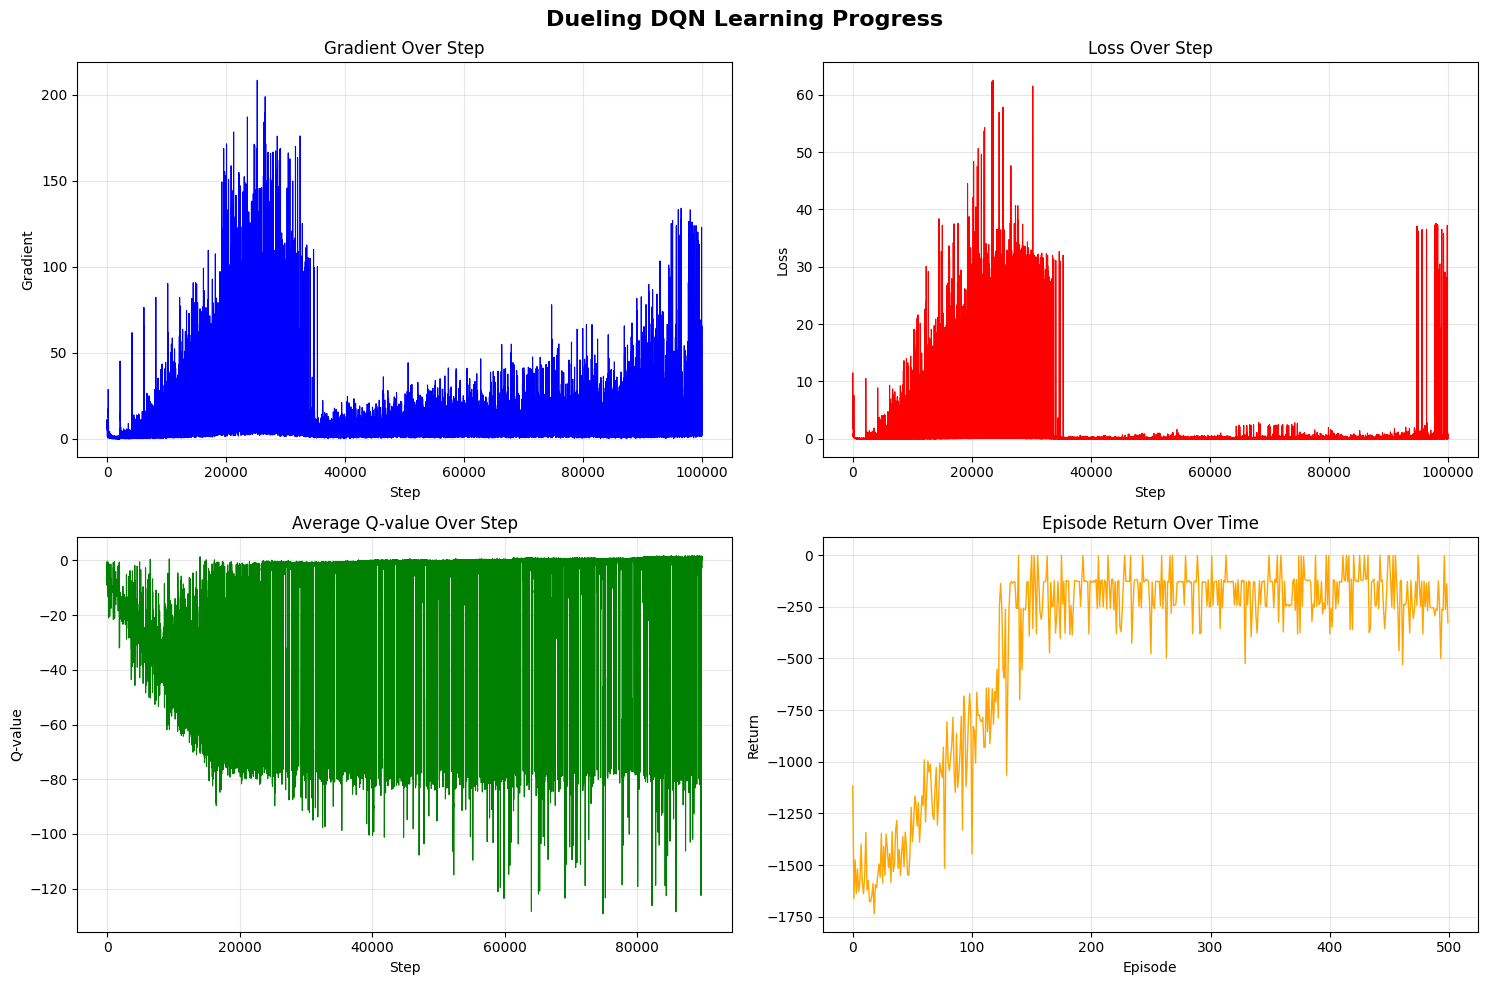

In [ ]:
import numpy as np
import tensorflow as tf
import gym
import random
from collections import deque
import matplotlib.pyplot as plt

# Fix seeds for reproducibility
np.random.seed(0)
tf.random.set_seed(0)
random.seed(0)

# Same action discretization as baseline
DISCRETE_ACTIONS = np.array([-2.0, -1.0, 0.0, 1.0, 2.0])
NUM_ACTIONS = len(DISCRETE_ACTIONS)

def get_discrete_action(action_index):
    return [DISCRETE_ACTIONS[action_index]]

class DuelingDQN:
    def __init__(self, env, learning_rate=0.001, gamma=0.95, epsilon_decay=0.995):
        self.env = env
        self.input_dim = env.observation_space.shape[0]
        self.output_dim = NUM_ACTIONS
        
        self.gamma = gamma
        self.epsilon = 1.0
        self.epsilon_min = 0.1
        self.epsilon_decay = epsilon_decay
        self.batch_size = 32
        self.min_batch_size = 8
        self.replay_buffer = deque(maxlen=10000)
        
        self.model = self.build_dueling_model(learning_rate)
        self.target_model = self.build_dueling_model(learning_rate)
        self.update_target_model()
        
        # Enhanced tracking
        self.episode_returns = []
        self.losses = []
        self.q_values = []
        self.gradients = []
        self.train_step = 0

    def build_dueling_model(self, lr):
        """Build Dueling DQN architecture with separate value and advantage streams"""
        inputs = tf.keras.Input(shape=(self.input_dim,))
        
        # Shared layers
        x = tf.keras.layers.Dense(32, activation='relu')(inputs)
        x = tf.keras.layers.Dense(32, activation='relu')(x)
        
        # Value stream
        value_stream = tf.keras.layers.Dense(16, activation='relu')(x)
        value = tf.keras.layers.Dense(1, activation='linear')(value_stream)
        
        # Advantage stream
        advantage_stream = tf.keras.layers.Dense(16, activation='relu')(x)
        advantage = tf.keras.layers.Dense(self.output_dim, activation='linear')(advantage_stream)
        
        # Combine value and advantage: Q(s,a) = V(s) + A(s,a) - mean(A(s,·))
        advantage_mean = tf.keras.layers.Lambda(lambda x: tf.reduce_mean(x, axis=1, keepdims=True))(advantage)
        advantage_normalized = tf.keras.layers.Subtract()([advantage, advantage_mean])
        q_values = tf.keras.layers.Add()([value, advantage_normalized])
        
        model = tf.keras.Model(inputs=inputs, outputs=q_values)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mse')
        return model

    def update_target_model(self):
        """Copy weights from main model to target model"""
        self.target_model.set_weights(self.model.get_weights())

    def act(self, state):
        """Epsilon-greedy action selection"""
        if np.random.rand() < self.epsilon:
            return random.randint(0, NUM_ACTIONS - 1)
        
        state_batch = np.array([state])
        q_values = self.model.predict(state_batch, verbose=0)[0]
        self.q_values.append(np.mean(q_values))
        return np.argmax(q_values)

    def remember(self, state, action, reward, next_state, done):
        """Store experience in replay buffer"""
        self.replay_buffer.append((state, action, reward, next_state, done))

    def replay(self):
        """Train the Dueling DQN model"""
        current_batch_size = min(self.batch_size, len(self.replay_buffer))
        
        if len(self.replay_buffer) < self.min_batch_size:
            return
        
        batch = random.sample(self.replay_buffer, current_batch_size)
        
        states = np.array([e[0] for e in batch])
        actions = np.array([e[1] for e in batch])
        rewards = np.array([e[2] for e in batch])
        next_states = np.array([e[3] for e in batch])
        dones = np.array([e[4] for e in batch])
        
        with tf.GradientTape() as tape:
            current_q_values = self.model(states, training=True)
            next_q_values = self.target_model(next_states, training=False)
            
            target_q_values = current_q_values.numpy()
            for i in range(current_batch_size):
                if dones[i]:
                    target_q_values[i][actions[i]] = rewards[i]
                else:
                    target_q_values[i][actions[i]] = rewards[i] + self.gamma * np.max(next_q_values[i])
            
            loss = tf.reduce_mean(tf.square(current_q_values - target_q_values))
        
        gradients = tape.gradient(loss, self.model.trainable_variables)
        grad_norm = tf.linalg.global_norm(gradients)
        self.gradients.append(grad_norm.numpy())
        self.losses.append(loss.numpy())
        
        self.model.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        
        self.train_step += 1
        
        if self.train_step <= 5:
            print(f"Dueling DQN step {self.train_step}: Loss = {loss.numpy():.4f}, Grad = {grad_norm.numpy():.4f}")

    def train(self, episodes=500):
        """Train the Dueling DQN agent"""
        print("Starting Dueling DQN training...")
        
        for episode in range(episodes):
            state = self.env.reset()
            if isinstance(state, tuple):
                state = state[0]
            
            total_reward = 0
            max_steps = 200
            
            for step in range(max_steps):
                action_index = self.act(state)
                action = get_discrete_action(action_index)
                
                result = self.env.step(action)
                if len(result) == 4:
                    next_state, reward, done, info = result
                else:
                    next_state, reward, terminated, truncated, info = result
                    done = terminated or truncated
                
                if isinstance(next_state, tuple):
                    next_state = next_state[0]
                
                self.remember(state, action_index, reward, next_state, done)
                state = next_state
                total_reward += reward
                
                if len(self.replay_buffer) >= self.min_batch_size:
                    self.replay()
                
                if done:
                    break
            
            self.episode_returns.append(total_reward)
            
            if episode % 10 == 0:
                self.update_target_model()
            
            if episode % 10 == 0 or episode < 20:
                avg_reward = np.mean(self.episode_returns[-10:]) if len(self.episode_returns) >= 10 else total_reward
                print(f"Episode {episode+1}/{episodes} - Reward: {total_reward:.1f}, "
                      f"Avg(10): {avg_reward:.1f}, Epsilon: {self.epsilon:.3f}")
        
        print("Dueling DQN training completed!")

    def plot_comprehensive_metrics(self):
        """Plot comprehensive learning metrics"""
        fig, axs = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle("Dueling DQN Learning Progress", fontsize=16, fontweight='bold')
        
        if self.gradients:
            axs[0, 0].plot(self.gradients, 'b-', linewidth=0.8)
            axs[0, 0].set_title("Gradient Over Step")
            axs[0, 0].set_xlabel("Step")
            axs[0, 0].set_ylabel("Gradient")
            axs[0, 0].grid(True, alpha=0.3)
        
        if self.losses:
            axs[0, 1].plot(self.losses, 'r-', linewidth=0.8)
            axs[0, 1].set_title("Loss Over Step")
            axs[0, 1].set_xlabel("Step")
            axs[0, 1].set_ylabel("Loss")
            axs[0, 1].grid(True, alpha=0.3)
        
        if self.q_values:
            axs[1, 0].plot(self.q_values, 'g-', linewidth=0.8)
            axs[1, 0].set_title("Average Q-value Over Step")
            axs[1, 0].set_xlabel("Step")
            axs[1, 0].set_ylabel("Q-value")
            axs[1, 0].grid(True, alpha=0.3)
        
        if self.episode_returns:
            axs[1, 1].plot(self.episode_returns, 'orange', linewidth=1.0)
            axs[1, 1].set_title("Episode Return Over Time")
            axs[1, 1].set_xlabel("Episode")
            axs[1, 1].set_ylabel("Return")
            axs[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

def test(self, episodes=5):
        """Test the trained agent - same as other models"""
        try:
            env = gym.make("Pendulum-v1")
        except:
            env = gym.make("Pendulum-v0")
        
        test_rewards = []
        
        for episode in range(episodes):
            state = env.reset()
            if isinstance(state, tuple):
                state = state[0]
            
            total_reward = 0
            steps = 0
            max_steps = 200
            
            for step in range(max_steps):
                action_idx = self.act(state, add_noise=False)  # No noise for testing
                action = get_discrete_action(action_idx)
                
                result = env.step(action)
                if len(result) == 4:
                    state, reward, done, info = result
                else:
                    state, reward, terminated, truncated, info = result
                    done = terminated or truncated
                
                if isinstance(state, tuple):
                    state = state[0]
                
                total_reward += reward
                steps += 1
                
                if done:
                    break
            
            test_rewards.append(total_reward)
            print(f"Test Episode {episode+1}: Reward = {total_reward:.1f}")
        
        env.close()
        avg_test_reward = np.mean(test_rewards)
        print(f"Average test reward: {avg_test_reward:.1f}")
        return avg_test_reward



# Observations and Insights – Dueling DQN Training

## 1. Gradient Over Step
- **Positive:**  
  - Strong early growth in gradient magnitude (~0–25k steps) reflects active learning and large policy adjustments.  
  - Mid-training stabilization (~40k–70k steps) shows the network entering a more controlled update phase.  
- **Negative:**  
  - Very large spikes (~200+) around 20k steps and again after 80k steps indicate instability or overcorrection in parameter updates.  
  - Late-stage gradient volatility suggests the model never fully settles into a stable solution.

## 2. Loss Over Step
- **Positive:**  
  - Clear downward trend after the initial rise shows improved accuracy in Q-value estimation.  
  - Extended low-loss plateau (~40k–80k steps) aligns with more consistent training.  
- **Negative:**  
  - Significant spikes both early and late in training suggest the model is sensitive to certain transitions.  
  - Final bursts in loss may indicate difficulties maintaining precise value predictions under the learned policy.

## 3. Average Q-value Over Step
- **Positive:**  
  - Gradual climb toward zero from highly negative values reflects improved and more realistic value predictions.  
  - Smaller oscillations late in training show partial stabilization.  
- **Negative:**  
  - Rapid early drop to around -120 indicates instability in value estimation during initial exploration.  
  - Frequent sharp dips even late in training highlight persistent noise in Q-value predictions.

## 4. Episode Return Over Time
- **Positive:**  
  - Rapid improvement in returns within the first ~100 episodes shows effective learning and adaptation.  
  - Sustained performance near the higher return range (~-200) indicates a generally strong control policy.  
- **Negative:**  
  - High return variance late in training shows that the agent’s policy can still regress suddenly.  
  - This reinforces that **while the model achieves strong returns, stability is not fully guaranteed**.

---

## Overall Assessment
The Dueling DQN achieves **fast learning and high average returns**, but:
- Suffers from gradient and loss spikes in multiple phases.
- Exhibits Q-value fluctuations even after apparent convergence.
- Shows occasional drops in episode returns despite overall good performance.

### Potential Improvements
- **Gradient clipping** to smooth out large, destabilizing updates.  
- **More frequent target network updates** to reduce Q-value oscillations.  
- **Slightly slower epsilon decay** to maintain beneficial exploration longer.


In [ ]:
# Create and train Dueling DQN
try:
    env = gym.make('Pendulum-v1')
except:
    env = gym.make('Pendulum-v0')

print("Training Dueling DQN...")
dueling_dqn_agent = DuelingDQN(env)
dueling_dqn_agent.train(episodes=500)
dueling_dqn_agent.plot_comprehensive_metrics()


env.close()

# Prioritized DQN – Code Overview

This implementation incorporates **Prioritized Experience Replay** to sample more important transitions based on their temporal difference (TD) error, enabling more efficient learning from the most informative experiences while maintaining the baseline DQN architecture.

---

## 1. **Setup and Configuration**
- **Reproducibility:**  
  Fixed seeds for NumPy, TensorFlow, and Python's `random` ensure consistent results across experiments.
- **Discrete Action Space:**  
  Continuous Pendulum actions are discretized into 5 fixed values: `[-2.0, -1.0, 0.0, 1.0, 2.0]`.
- **Config Parameters:**  
  Matches baseline DQN for fair comparison:
  - `gamma` (discount factor): 0.95  
  - `learning_rate`: 0.001  
  - `epsilon_decay`: 0.995  
  - `batch_size`: 32  
  - `memory_size`: 10,000 experiences  
  - `alpha`: 0.6 (priority exponent)  
  - `beta`: 0.4 → 1.0 (importance sampling correction)

---

## 2. **Prioritized Replay Buffer**
- **Priority-Based Storage:** Experiences stored with TD error-based priorities
- **Sampling Strategy:** Probability proportional to priority: `P(i) = priority_i^α / Σ priority_j^α`
- **Importance Sampling:** Corrects bias with weights: `w_i = (N * P(i))^(-β)`
- **Priority Updates:** Continuously updated based on new TD errors during training
- **Maximum Priority Assignment:** New experiences get highest current priority

---

## 3. **Network Architecture**
- **Model Structure:** Identical to baseline DQN
  - Two fully connected layers with 32 ReLU units each
  - Linear output layer with 5 units (one per discrete action)
- **Target Network:** Maintains separate copy for stable Q-value targets
- **Optimizer:** Adam with MSE loss function

---

## 4. **Prioritized Experience Replay Algorithm**
- **TD Error Calculation:** `|r + γ * max Q_target(s', a') - Q_main(s, a)|`
- **Priority Assignment:** TD error magnitude determines sampling probability
- **Weighted Loss:** Importance sampling weights correct for biased sampling
- **Priority Updates:** Recalculate priorities based on fresh TD errors after each update
- **Beta Annealing:** Gradually increase β from 0.4 to 1.0 for full bias correction

---

## 5. **Training Process (`replay` method)**
- **Priority-Based Sampling:** Select experiences with higher TD errors more frequently
- **Current Q-Values:** Predicted by main network for sampled batch
- **Target Q-Values:** Computed using target network with standard DQN rule
- **TD Error Tracking:** Calculate individual TD errors for priority updates
- **Weighted Loss Function:** Apply importance sampling weights to correct sampling bias
- **Priority Buffer Updates:** Refresh priorities based on new TD errors

---

## 6. **Exploration Strategy**
- **Epsilon-Greedy:** Identical to baseline DQN
  - Initial epsilon: 1.0 (100% random)
  - Minimum epsilon: 0.1 (10% random)
  - Decay rate: 0.995 per training step
- **Action Selection:** Uses Q-values from main network for greedy selection

---

## 7. **Enhanced Metrics Tracking**
- **Episode Returns:** Total reward per episode for learning curve analysis
- **Weighted Loss:** Priority-corrected loss values over time
- **Q-Values:** Average Q-values during action selection
- **Gradient Norms:** Gradient magnitudes to monitor training stability
- **Beta Progression:** Importance sampling correction factor evolution
- **Buffer Statistics:** Priority distribution and sampling effectiveness

---

## 8. **Visualization and Testing**
- **4-Panel Plot:** Matches other models (gradient, weighted loss, Q-values, episode returns)
- **Testing Mode:** Deterministic policy evaluation without prioritized sampling
- **Performance Metrics:** Average test rewards over multiple episodes

---

## **Key Differences from Baseline DQN**
- **Sample Efficiency:** Focuses learning on high-error transitions for faster convergence
- **Importance Sampling:** Corrects bias introduced by non-uniform sampling
- **Dynamic Priorities:** Continuously updates experience importance based on learning progress
- **Replay Strategy:** Replaces uniform random sampling with priority-based selection
- **Bias Correction:** Gradually increases importance sampling weights to ensure convergence

---

## **Purpose**
This implementation is designed to:
1. **Improve sample efficiency** by learning more from informative experiences in the Pendulum environment
2. **Maintain algorithmic correctness** through importance sampling bias correction

Training Prioritized DQN...
Starting Prioritized DQN training...
Prioritized DQN step 1: Loss = 12.4106, Grad = 4.7367, Beta = 0.401
Prioritized DQN step 2: Loss = 15.0535, Grad = 7.6067, Beta = 0.402
Prioritized DQN step 3: Loss = 13.8544, Grad = 6.9147, Beta = 0.403
Prioritized DQN step 4: Loss = 8.9178, Grad = 4.1498, Beta = 0.404
Prioritized DQN step 5: Loss = 11.8829, Grad = 5.3007, Beta = 0.405
Episode 1/500 - Reward: -1639.2, Avg(10): -1639.2, Buffer: 200
Episode 1/500 - Reward: -1639.2, Avg(10): -1639.2, Buffer: 200
Episode 2/500 - Reward: -1682.1, Avg(10): -1682.1, Buffer: 400
Episode 2/500 - Reward: -1682.1, Avg(10): -1682.1, Buffer: 400
Episode 3/500 - Reward: -1790.7, Avg(10): -1790.7, Buffer: 600
Episode 3/500 - Reward: -1790.7, Avg(10): -1790.7, Buffer: 600
Episode 4/500 - Reward: -1450.7, Avg(10): -1450.7, Buffer: 800
Episode 4/500 - Reward: -1450.7, Avg(10): -1450.7, Buffer: 800
Episode 5/500 - Reward: -1743.2, Avg(10): -1743.2, Buffer: 1000
Episode 5/500 - Reward: -174

Training Prioritized DQN...
Starting Prioritized DQN training...
Prioritized DQN step 1: Loss = 12.4106, Grad = 4.7367, Beta = 0.401
Prioritized DQN step 2: Loss = 15.0535, Grad = 7.6067, Beta = 0.402
Prioritized DQN step 3: Loss = 13.8544, Grad = 6.9147, Beta = 0.403
Prioritized DQN step 4: Loss = 8.9178, Grad = 4.1498, Beta = 0.404
Prioritized DQN step 5: Loss = 11.8829, Grad = 5.3007, Beta = 0.405
Episode 1/500 - Reward: -1639.2, Avg(10): -1639.2, Buffer: 200
Episode 1/500 - Reward: -1639.2, Avg(10): -1639.2, Buffer: 200
Episode 2/500 - Reward: -1682.1, Avg(10): -1682.1, Buffer: 400
Episode 2/500 - Reward: -1682.1, Avg(10): -1682.1, Buffer: 400
Episode 3/500 - Reward: -1790.7, Avg(10): -1790.7, Buffer: 600
Episode 3/500 - Reward: -1790.7, Avg(10): -1790.7, Buffer: 600
Episode 4/500 - Reward: -1450.7, Avg(10): -1450.7, Buffer: 800
Episode 4/500 - Reward: -1450.7, Avg(10): -1450.7, Buffer: 800
Episode 5/500 - Reward: -1743.2, Avg(10): -1743.2, Buffer: 1000
Episode 5/500 - Reward: -174

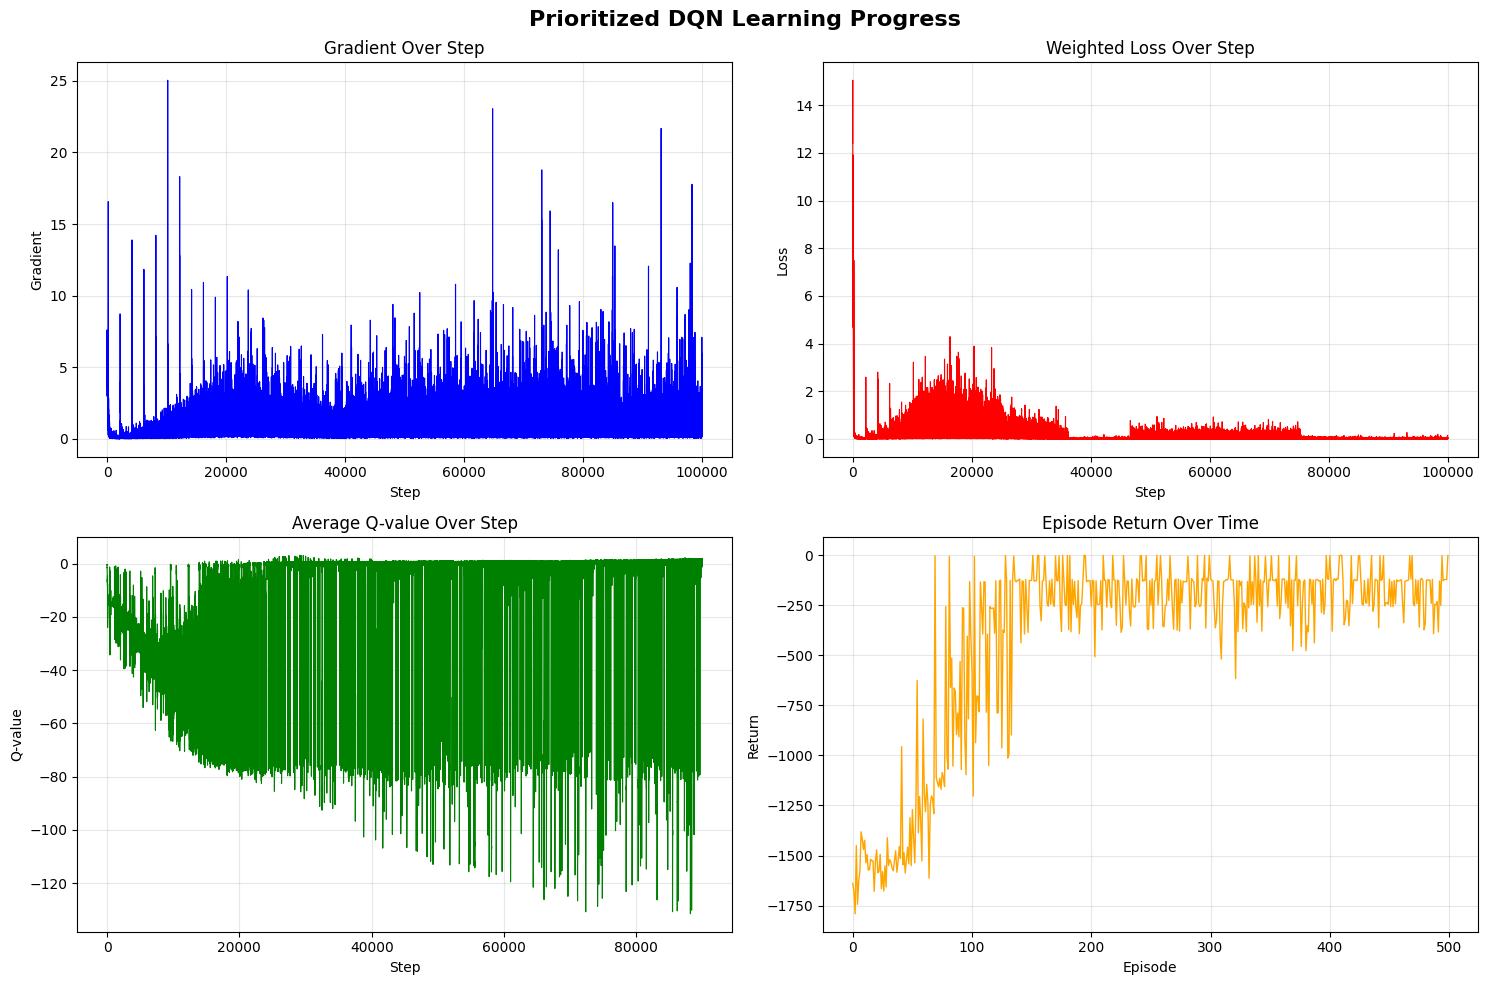

In [ ]:
import numpy as np
import tensorflow as tf
import gym
import random
import matplotlib.pyplot as plt

# Fix seeds for reproducibility
np.random.seed(0)
tf.random.set_seed(0)
random.seed(0)

# Same action discretization as baseline
DISCRETE_ACTIONS = np.array([-2.0, -1.0, 0.0, 1.0, 2.0])
NUM_ACTIONS = len(DISCRETE_ACTIONS)

def get_discrete_action(action_index):
    return [DISCRETE_ACTIONS[action_index]]

class PrioritizedReplayBuffer:
    def __init__(self, capacity, alpha=0.6):
        self.capacity = capacity
        self.alpha = alpha
        self.buffer = []
        self.priorities = np.zeros((capacity,), dtype=np.float32)
        self.pos = 0
        self.size = 0

    def add(self, experience):
        """Add experience with maximum priority"""
        max_priority = self.priorities.max() if self.buffer else 1.0
        
        if len(self.buffer) < self.capacity:
            self.buffer.append(experience)
        else:
            self.buffer[self.pos] = experience
        
        self.priorities[self.pos] = max_priority
        self.pos = (self.pos + 1) % self.capacity
        self.size = min(self.size + 1, self.capacity)

    def sample(self, batch_size, beta=0.4):
        """Sample with priority-based probabilities"""
        if self.size == 0:
            return [], [], [], []
        
        priorities = self.priorities[:self.size]
        probs = priorities ** self.alpha
        probs /= probs.sum()
        
        # Sample indices based on priorities
        indices = np.random.choice(self.size, batch_size, p=probs)
        
        # Calculate importance sampling weights
        weights = (self.size * probs[indices]) ** (-beta)
        weights /= weights.max()
        
        batch = [self.buffer[idx] for idx in indices]
        return batch, indices, weights, probs[indices]

    def update_priorities(self, indices, priorities):
        """Update priorities for sampled experiences"""
        for idx, priority in zip(indices, priorities):
            self.priorities[idx] = priority

    def __len__(self):
        return self.size

class PrioritizedDQN:
    def __init__(self, env, learning_rate=0.001, gamma=0.95, epsilon_decay=0.995):
        self.env = env
        self.input_dim = env.observation_space.shape[0]
        self.output_dim = NUM_ACTIONS
        
        self.gamma = gamma
        self.epsilon = 1.0
        self.epsilon_min = 0.1
        self.epsilon_decay = epsilon_decay
        self.batch_size = 32
        self.min_batch_size = 8
        
        # Prioritized replay buffer
        self.replay_buffer = PrioritizedReplayBuffer(10000, alpha=0.6)
        self.beta = 0.4
        self.beta_increment = 0.001
        
        self.model = self.build_model(learning_rate)
        self.target_model = self.build_model(learning_rate)
        self.update_target_model()
        
        # Enhanced tracking
        self.episode_returns = []
        self.losses = []
        self.q_values = []
        self.gradients = []
        self.train_step = 0

    def build_model(self, lr):
        """Same network architecture as baseline"""
        model = tf.keras.models.Sequential([
            tf.keras.Input(shape=(self.input_dim,)),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(self.output_dim, activation='linear')
        ])
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mse')
        return model

    def update_target_model(self):
        """Copy weights from main model to target model"""
        self.target_model.set_weights(self.model.get_weights())

    def act(self, state):
        """Epsilon-greedy action selection"""
        if np.random.rand() < self.epsilon:
            return random.randint(0, NUM_ACTIONS - 1)
        
        state_batch = np.array([state])
        q_values = self.model.predict(state_batch, verbose=0)[0]
        self.q_values.append(np.mean(q_values))
        return np.argmax(q_values)

    def remember(self, state, action, reward, next_state, done):
        """Store experience in prioritized replay buffer"""
        self.replay_buffer.add((state, action, reward, next_state, done))

    def replay(self):
        """Train with prioritized experience replay"""
        if len(self.replay_buffer) < self.min_batch_size:
            return
        
        current_batch_size = min(self.batch_size, len(self.replay_buffer))
        
        # Sample with priorities
        batch, indices, weights, sample_probs = self.replay_buffer.sample(current_batch_size, self.beta)
        
        if not batch:
            return
        
        states = np.array([e[0] for e in batch])
        actions = np.array([e[1] for e in batch])
        rewards = np.array([e[2] for e in batch])
        next_states = np.array([e[3] for e in batch])
        dones = np.array([e[4] for e in batch])
        
        with tf.GradientTape() as tape:
            current_q_values = self.model(states, training=True)
            next_q_values = self.target_model(next_states, training=False)
            
            target_q_values = current_q_values.numpy()
            td_errors = []
            
            for i in range(current_batch_size):
                if dones[i]:
                    target = rewards[i]
                else:
                    target = rewards[i] + self.gamma * np.max(next_q_values[i])
                
                # Calculate TD error for priority update
                td_error = abs(target - current_q_values[i][actions[i]])
                td_errors.append(td_error)
                target_q_values[i][actions[i]] = target
            
            # Weighted loss using importance sampling weights
            losses = tf.square(current_q_values - target_q_values)
            weighted_loss = tf.reduce_mean(losses * weights.reshape(-1, 1))
        
        gradients = tape.gradient(weighted_loss, self.model.trainable_variables)
        grad_norm = tf.linalg.global_norm(gradients)
        self.gradients.append(grad_norm.numpy())
        self.losses.append(weighted_loss.numpy())
        
        self.model.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
        
        # Update priorities based on TD errors
        new_priorities = [abs(td_error) + 1e-6 for td_error in td_errors]
        self.replay_buffer.update_priorities(indices, new_priorities)
        
        # Increment beta for importance sampling
        self.beta = min(1.0, self.beta + self.beta_increment)
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        
        self.train_step += 1
        
        if self.train_step <= 5:
            print(f"Prioritized DQN step {self.train_step}: Loss = {weighted_loss.numpy():.4f}, "
                  f"Grad = {grad_norm.numpy():.4f}, Beta = {self.beta:.3f}")

    def train(self, episodes=500):
        """Train the Prioritized DQN agent"""
        print("Starting Prioritized DQN training...")
        
        for episode in range(episodes):
            state = self.env.reset()
            if isinstance(state, tuple):
                state = state[0]
            
            total_reward = 0
            max_steps = 200
            
            for step in range(max_steps):
                action_index = self.act(state)
                action = get_discrete_action(action_index)
                
                result = self.env.step(action)
                if len(result) == 4:
                    next_state, reward, done, info = result
                else:
                    next_state, reward, terminated, truncated, info = result
                    done = terminated or truncated
                
                if isinstance(next_state, tuple):
                    next_state = next_state[0]
                
                self.remember(state, action_index, reward, next_state, done)
                state = next_state
                total_reward += reward
                
                if len(self.replay_buffer) >= self.min_batch_size:
                    self.replay()
                
                if done:
                    break
            
            self.episode_returns.append(total_reward)
            
            if episode % 10 == 0:
                self.update_target_model()
            
            if episode % 10 == 0 or episode < 20:
                avg_reward = np.mean(self.episode_returns[-10:]) if len(self.episode_returns) >= 10 else total_reward
                print(f"Episode {episode+1}/{episodes} - Reward: {total_reward:.1f}, "
                      f"Avg(10): {avg_reward:.1f}, Buffer: {len(self.replay_buffer)}")
        
        print("Prioritized DQN training completed!")

    def plot_comprehensive_metrics(self):
        """Plot comprehensive learning metrics"""
        fig, axs = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle("Prioritized DQN Learning Progress", fontsize=16, fontweight='bold')
        
        if self.gradients:
            axs[0, 0].plot(self.gradients, 'b-', linewidth=0.8)
            axs[0, 0].set_title("Gradient Over Step")
            axs[0, 0].set_xlabel("Step")
            axs[0, 0].set_ylabel("Gradient")
            axs[0, 0].grid(True, alpha=0.3)
        
        if self.losses:
            axs[0, 1].plot(self.losses, 'r-', linewidth=0.8)
            axs[0, 1].set_title("Weighted Loss Over Step")
            axs[0, 1].set_xlabel("Step")
            axs[0, 1].set_ylabel("Loss")
            axs[0, 1].grid(True, alpha=0.3)
        
        if self.q_values:
            axs[1, 0].plot(self.q_values, 'g-', linewidth=0.8)
            axs[1, 0].set_title("Average Q-value Over Step")
            axs[1, 0].set_xlabel("Step")
            axs[1, 0].set_ylabel("Q-value")
            axs[1, 0].grid(True, alpha=0.3)
        
        if self.episode_returns:
            axs[1, 1].plot(self.episode_returns, 'orange', linewidth=1.0)
            axs[1, 1].set_title("Episode Return Over Time")
            axs[1, 1].set_xlabel("Episode")
            axs[1, 1].set_ylabel("Return")
            axs[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

def test(self, episodes=5):
        """Test the trained agent - same as other models"""
        try:
            env = gym.make("Pendulum-v1")
        except:
            env = gym.make("Pendulum-v0")
        
        test_rewards = []
        
        for episode in range(episodes):
            state = env.reset()
            if isinstance(state, tuple):
                state = state[0]
            
            total_reward = 0
            steps = 0
            max_steps = 200
            
            for step in range(max_steps):
                action_idx = self.act(state, add_noise=False)  # No noise for testing
                action = get_discrete_action(action_idx)
                
                result = env.step(action)
                if len(result) == 4:
                    state, reward, done, info = result
                else:
                    state, reward, terminated, truncated, info = result
                    done = terminated or truncated
                
                if isinstance(state, tuple):
                    state = state[0]
                
                total_reward += reward
                steps += 1
                
                if done:
                    break
            
            test_rewards.append(total_reward)
            print(f"Test Episode {episode+1}: Reward = {total_reward:.1f}")
        
        env.close()
        avg_test_reward = np.mean(test_rewards)
        print(f"Average test reward: {avg_test_reward:.1f}")
        return avg_test_reward



# Observations and Insights – Prioritized DQN Training

## 1. Gradient Over Step
- **Positive:**  
  - Early controlled gradient growth (~0–20k steps) indicates stable but active learning.  
  - Moderate spikes suggest the model responds strongly to prioritized transitions, reinforcing learning from critical experiences.  
- **Negative:**  
  - Frequent spikes throughout training, especially after 60k steps, reflect instability introduced by high-TD-error samples.  
  - The model never fully eliminates gradient volatility, suggesting sensitivity to replay buffer sampling priorities.

## 2. Weighted Loss Over Step
- **Positive:**  
  - Initial high loss followed by a clear downward trend indicates improving Q-value accuracy over time.  
  - Long stable low-loss phases (~40k–100k steps) reflect effective convergence for many state-action pairs.  
- **Negative:**  
  - Persistent small spikes throughout training imply that challenging or novel transitions still cause prediction errors.  
  - Early instability with large initial loss may slow policy stabilization compared to uniform replay.

## 3. Average Q-value Over Step
- **Positive:**  
  - Gradual shift toward zero from highly negative values shows more realistic reward estimation.  
  - Final clustering near zero is consistent with a mature, reward-maximizing policy.  
- **Negative:**  
  - Large fluctuations remain throughout training, indicating noisy and inconsistent Q-value predictions.  
  - Deep dips even late in training suggest that priority sampling occasionally feeds destabilizing transitions.

## 4. Episode Return Over Time
- **Positive:**  
  - Rapid early improvement (~0–100 episodes) reflects fast adaptation due to prioritized replay efficiency.  
  - High sustained returns indicate that the learned policy performs consistently well overall.  
- **Negative:**  
  - Small but persistent return variance late in training suggests minor instability in decision-making.  
  - Occasional performance dips confirm that the agent can momentarily regress despite high averages.

---

## Overall Assessment
The Prioritized DQN delivers **fast learning, high long-term returns, and strong sample efficiency**, but:
- Suffers from consistent gradient/Q-value volatility.
- Remains sensitive to rare or extreme experiences.
- Has occasional return dips even when converged.

### Potential Improvements
- **Tune priority exponent (α) and importance-sampling exponent (β)** to balance learning speed and stability.  
- **Gradient clipping** to prevent destabilizing parameter jumps.  
- **Replay buffer regularization** (e.g., mixing in some uniform samples) to reduce bias and instability.


In [ ]:
# Create and train Prioritized DQN
env = gym.make('Pendulum-v0')

print("Training Prioritized DQN...")
prioritized_dqn_agent = PrioritizedDQN(env)
prioritized_dqn_agent.train(episodes=500)
prioritized_dqn_agent.plot_comprehensive_metrics()

env.close()

# Reward Normalized DQN – Code Overview

This implementation incorporates **reward normalization and clipping** to stabilize training by standardizing reward scales and preventing extreme values from disrupting learning, while maintaining the baseline DQN architecture for fair comparison.

---

## 1. **Setup and Configuration**
- **Reproducibility:**  
  Fixed seeds for NumPy, TensorFlow, and Python's `random` ensure consistent results across experiments.
- **Discrete Action Space:**  
  Continuous Pendulum actions are discretized into 5 fixed values: `[-2.0, -1.0, 0.0, 1.0, 2.0]`.
- **Config Parameters:**  
  Matches baseline DQN for fair comparison:
  - `gamma` (discount factor): 0.95  
  - `learning_rate`: 0.001  
  - `epsilon_decay`: 0.995  
  - `batch_size`: 32  
  - `memory_size`: 10,000 experiences  
  - `clip_range`: 5.0 (reward clipping bounds)

---

## 2. **Reward Normalization System**
- **Running Statistics:** Maintains rolling mean and standard deviation over last 1,000 rewards
- **Normalization Formula:** `(reward - mean) / (std + 1e-8)` to standardize reward scale
- **Clipping:** Bounds normalized rewards to `[-5.0, 5.0]` to prevent extreme values
- **History Tracking:** Deque buffer stores recent rewards for statistical updates
- **Adaptive Updates:** Statistics recalculated continuously as new rewards arrive

---

## 3. **Network Architecture**
- **Model Structure:** Identical to baseline DQN
  - Two fully connected layers with 32 ReLU units each
  - Linear output layer with 5 units (one per discrete action)
- **Target Network:** Maintains separate copy for stable Q-value targets
- **Optimizer:** Adam with MSE loss function

---

## 4. **Reward Processing Pipeline**
- **Raw Reward Collection:** Original environment rewards stored in history buffer
- **Statistical Update:** Running mean and standard deviation recalculated when buffer has >10 samples
- **Normalization:** Converts raw rewards to standardized scale with zero mean, unit variance
- **Clipping:** Applies bounds to prevent outlier rewards from destabilizing training
- **Storage:** Normalized and clipped rewards stored in replay buffer for training

---

## 5. **Training Process (`replay` method)**
- **Experience Sampling:** Random batch selection from replay buffer (containing normalized rewards)
- **Current Q-Values:** Predicted by main network for current states
- **Target Q-Values:** Computed using target network with normalized reward targets
- **Loss Calculation:** Standard MSE between predicted and target Q-values
- **Gradient Tracking:** Records gradient norms and normalized reward statistics
- **Target Updates:** Hard copy of main network weights every 10 episodes

---

## 6. **Exploration Strategy**
- **Epsilon-Greedy:** Identical to baseline DQN
  - Initial epsilon: 1.0 (100% random)
  - Minimum epsilon: 0.1 (10% random)
  - Decay rate: 0.995 per training step
- **Action Selection:** Uses Q-values from main network for greedy selection

---

## 7. **Enhanced Metrics Tracking**
- **Episode Returns:** Original (unnormalized) total reward per episode for interpretable learning curves
- **Loss Values:** Training loss over time using normalized rewards
- **Q-Values:** Average Q-values during action selection
- **Gradient Norms:** Gradient magnitudes to monitor training stability
- **Reward Statistics:** Real-time tracking of reward mean and standard deviation
- **Normalization Progress:** Monitor how reward scaling evolves during training

---

## 8. **Visualization and Testing**
- **4-Panel Plot:** Matches other models (gradient, loss, Q-values, episode returns)
- **Original Scale Reporting:** Episode returns shown in original reward scale for interpretability
- **Testing Mode:** Uses trained policy without additional reward normalization
- **Performance Metrics:** Average test rewards in original scale

---

## **Key Differences from Baseline DQN**
- **Reward Standardization:** Converts varying reward scales to consistent normalized range
- **Training Stability:** Prevents extreme rewards from causing gradient explosions or vanishing
- **Adaptive Scaling:** Continuously updates normalization based on observed reward distribution
- **Outlier Protection:** Clipping prevents rare extreme values from disrupting learning
- **Scale Independence:** Makes algorithm less sensitive to environment-specific reward design

---

## **Purpose**
This implementation is designed to:
1. **Improve training stability** by standardizing reward scales in the Pendulum environment
2. **Reduce sensitivity** to reward design choices and extreme values
3. **Maintain fair comparison** with identical network architecture and hyperparameters
4. **Demonstrate normalization benefits** for environments with challenging reward distributions
5. **Provide robust learning** that adapts to changing

In [8]:
import numpy as np
import tensorflow as tf
import gym
import random
from collections import deque
import matplotlib.pyplot as plt

# Fix seeds for reproducibility
np.random.seed(0)
tf.random.set_seed(0)
random.seed(0)

# Same action discretization as baseline
DISCRETE_ACTIONS = np.array([-2.0, -1.0, 0.0, 1.0, 2.0])
NUM_ACTIONS = len(DISCRETE_ACTIONS)

def get_discrete_action(action_index):
    return [DISCRETE_ACTIONS[action_index]]

class RewardNormalizedDQN:
    def __init__(self, env, learning_rate=0.001, gamma=0.95, epsilon_decay=0.995):
        self.env = env
        self.input_dim = env.observation_space.shape[0]
        self.output_dim = NUM_ACTIONS
        
        self.gamma = gamma
        self.epsilon = 1.0
        self.epsilon_min = 0.1
        self.epsilon_decay = epsilon_decay
        self.batch_size = 32
        self.min_batch_size = 8
        self.replay_buffer = deque(maxlen=10000)
        
        # Reward normalization parameters
        self.reward_mean = 0.0
        self.reward_std = 1.0
        self.reward_history = deque(maxlen=1000)
        self.clip_reward = True
        self.clip_range = 5.0
        
        self.model = self.build_model(learning_rate)
        self.target_model = self.build_model(learning_rate)
        self.update_target_model()
        
        # Enhanced tracking
        self.episode_returns = []
        self.losses = []
        self.q_values = []
        self.gradients = []
        self.train_step = 0

    def build_model(self, lr):
        """Same network architecture as baseline"""
        model = tf.keras.models.Sequential([
            tf.keras.Input(shape=(self.input_dim,)),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(self.output_dim, activation='linear')
        ])
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mse')
        return model

    def normalize_reward(self, reward):
        """Normalize and clip reward"""
        # Add to history
        self.reward_history.append(reward)
        
        # Update running statistics
        if len(self.reward_history) > 10:
            self.reward_mean = np.mean(self.reward_history)
            self.reward_std = np.std(self.reward_history) + 1e-8
        
        # Normalize reward
        normalized_reward = (reward - self.reward_mean) / self.reward_std
        
        # Clip if enabled
        if self.clip_reward:
            normalized_reward = np.clip(normalized_reward, -self.clip_range, self.clip_range)
        
        return normalized_reward

    def update_target_model(self):
        """Copy weights from main model to target model"""
        self.target_model.set_weights(self.model.get_weights())

    def act(self, state):
        """Epsilon-greedy action selection"""
        if np.random.rand() < self.epsilon:
            return random.randint(0, NUM_ACTIONS - 1)
        
        state_batch = np.array([state])
        q_values = self.model.predict(state_batch, verbose=0)[0]
        self.q_values.append(np.mean(q_values))
        return np.argmax(q_values)

    def remember(self, state, action, reward, next_state, done):
        """Store experience with normalized reward"""
        normalized_reward = self.normalize_reward(reward)
        self.replay_buffer.append((state, action, normalized_reward, next_state, done))

    def replay(self):
        """Train the model with normalized rewards"""
        current_batch_size = min(self.batch_size, len(self.replay_buffer))
        
        if len(self.replay_buffer) < self.min_batch_size:
            return
        
        batch = random.sample(self.replay_buffer, current_batch_size)
        
        states = np.array([e[0] for e in batch])
        actions = np.array([e[1] for e in batch])
        rewards = np.array([e[2] for e in batch])  # Already normalized
        next_states = np.array([e[3] for e in batch])
        dones = np.array([e[4] for e in batch])
        
        with tf.GradientTape() as tape:
            current_q_values = self.model(states, training=True)
            next_q_values = self.target_model(next_states, training=False)
            
            target_q_values = current_q_values.numpy()
            for i in range(current_batch_size):
                if dones[i]:
                    target_q_values[i][actions[i]] = rewards[i]
                else:
                    target_q_values[i][actions[i]] = rewards[i] + self.gamma * np.max(next_q_values[i])
            
            loss = tf.reduce_mean(tf.square(current_q_values - target_q_values))
        
        gradients = tape.gradient(loss, self.model.trainable_variables)
        grad_norm = tf.linalg.global_norm(gradients)
        self.gradients.append(grad_norm.numpy())
        self.losses.append(loss.numpy())
        
        self.model.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        
        self.train_step += 1
        
        if self.train_step <= 5:
            print(f"Reward Normalized DQN step {self.train_step}: Loss = {loss.numpy():.4f}, "
                  f"Grad = {grad_norm.numpy():.4f}, Reward Mean = {self.reward_mean:.2f}, Std = {self.reward_std:.2f}")

    def train(self, episodes=500):
        """Train the Reward Normalized DQN agent"""
        print("Starting Reward Normalized DQN training...")
        
        for episode in range(episodes):
            state = self.env.reset()
            if isinstance(state, tuple):
                state = state[0]
            
            total_reward = 0
            max_steps = 200
            
            for step in range(max_steps):
                action_index = self.act(state)
                action = get_discrete_action(action_index)
                
                result = self.env.step(action)
                if len(result) == 4:
                    next_state, reward, done, info = result
                else:
                    next_state, reward, terminated, truncated, info = result
                    done = terminated or truncated
                
                if isinstance(next_state, tuple):
                    next_state = next_state[0]
                
                # Store original reward for tracking, but normalize for training
                total_reward += reward
                self.remember(state, action_index, reward, next_state, done)
                state = next_state
                
                if len(self.replay_buffer) >= self.min_batch_size:
                    self.replay()
                
                if done:
                    break
            
            self.episode_returns.append(total_reward)
            
            if episode % 10 == 0:
                self.update_target_model()
            
            if episode % 10 == 0 or episode < 20:
                avg_reward = np.mean(self.episode_returns[-10:]) if len(self.episode_returns) >= 10 else total_reward
                print(f"Episode {episode+1}/{episodes} - Reward: {total_reward:.1f}, "
                      f"Avg(10): {avg_reward:.1f}, Epsilon: {self.epsilon:.3f}")
        
        print("Reward Normalized DQN training completed!")

    def plot_comprehensive_metrics(self):
        """Plot comprehensive learning metrics"""
        fig, axs = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle("Reward Normalized DQN Learning Progress", fontsize=16, fontweight='bold')
        
        if self.gradients:
            axs[0, 0].plot(self.gradients, 'b-', linewidth=0.8)
            axs[0, 0].set_title("Gradient Over Step")
            axs[0, 0].set_xlabel("Step")
            axs[0, 0].set_ylabel("Gradient")
            axs[0, 0].grid(True, alpha=0.3)
        
        if self.losses:
            axs[0, 1].plot(self.losses, 'r-', linewidth=0.8)
            axs[0, 1].set_title("Loss Over Step")
            axs[0, 1].set_xlabel("Step")
            axs[0, 1].set_ylabel("Loss")
            axs[0, 1].grid(True, alpha=0.3)
        
        if self.q_values:
            axs[1, 0].plot(self.q_values, 'g-', linewidth=0.8)
            axs[1, 0].set_title("Average Q-value Over Step")
            axs[1, 0].set_xlabel("Step")
            axs[1, 0].set_ylabel("Q-value")
            axs[1, 0].grid(True, alpha=0.3)
        
        if self.episode_returns:
            axs[1, 1].plot(self.episode_returns, 'orange', linewidth=1.0)
            axs[1, 1].set_title("Episode Return Over Time")
            axs[1, 1].set_xlabel("Episode")
            axs[1, 1].set_ylabel("Return")
            axs[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

def test(self, episodes=5):
        """Test the trained agent - same as other models"""
        try:
            env = gym.make("Pendulum-v1")
        except:
            env = gym.make("Pendulum-v0")
        
        test_rewards = []
        
        for episode in range(episodes):
            state = env.reset()
            if isinstance(state, tuple):
                state = state[0]
            
            total_reward = 0
            steps = 0
            max_steps = 200
            
            for step in range(max_steps):
                action_idx = self.act(state, add_noise=False)  # No noise for testing
                action = get_discrete_action(action_idx)
                
                result = env.step(action)
                if len(result) == 4:
                    state, reward, done, info = result
                else:
                    state, reward, terminated, truncated, info = result
                    done = terminated or truncated
                
                if isinstance(state, tuple):
                    state = state[0]
                
                total_reward += reward
                steps += 1
                
                if done:
                    break
            
            test_rewards.append(total_reward)
            print(f"Test Episode {episode+1}: Reward = {total_reward:.1f}")
        
        env.close()
        avg_test_reward = np.mean(test_rewards)
        print(f"Average test reward: {avg_test_reward:.1f}")
        return avg_test_reward



Training Reward Normalized DQN...
Starting Reward Normalized DQN training...
Reward Normalized DQN step 1: Loss = 2.2013, Grad = 4.5158, Reward Mean = 0.00, Std = 1.00
Reward Normalized DQN step 2: Loss = 2.1060, Grad = 4.6809, Reward Mean = 0.00, Std = 1.00
Reward Normalized DQN step 3: Loss = 2.1422, Grad = 4.4540, Reward Mean = 0.00, Std = 1.00
Reward Normalized DQN step 4: Loss = 1.8904, Grad = 4.0717, Reward Mean = -7.03, Std = 4.19
Reward Normalized DQN step 5: Loss = 1.6781, Grad = 3.8247, Reward Mean = -7.24, Std = 4.08
Episode 1/500 - Reward: -1274.9, Avg(10): -1274.9, Epsilon: 0.380
Episode 2/500 - Reward: -1824.9, Avg(10): -1824.9, Epsilon: 0.139
Episode 3/500 - Reward: -977.1, Avg(10): -977.1, Epsilon: 0.100
Episode 4/500 - Reward: -1740.6, Avg(10): -1740.6, Epsilon: 0.100
Episode 5/500 - Reward: -938.7, Avg(10): -938.7, Epsilon: 0.100
Episode 6/500 - Reward: -1587.1, Avg(10): -1587.1, Epsilon: 0.100
Episode 7/500 - Reward: -1063.8, Avg(10): -1063.8, Epsilon: 0.100
Episode 

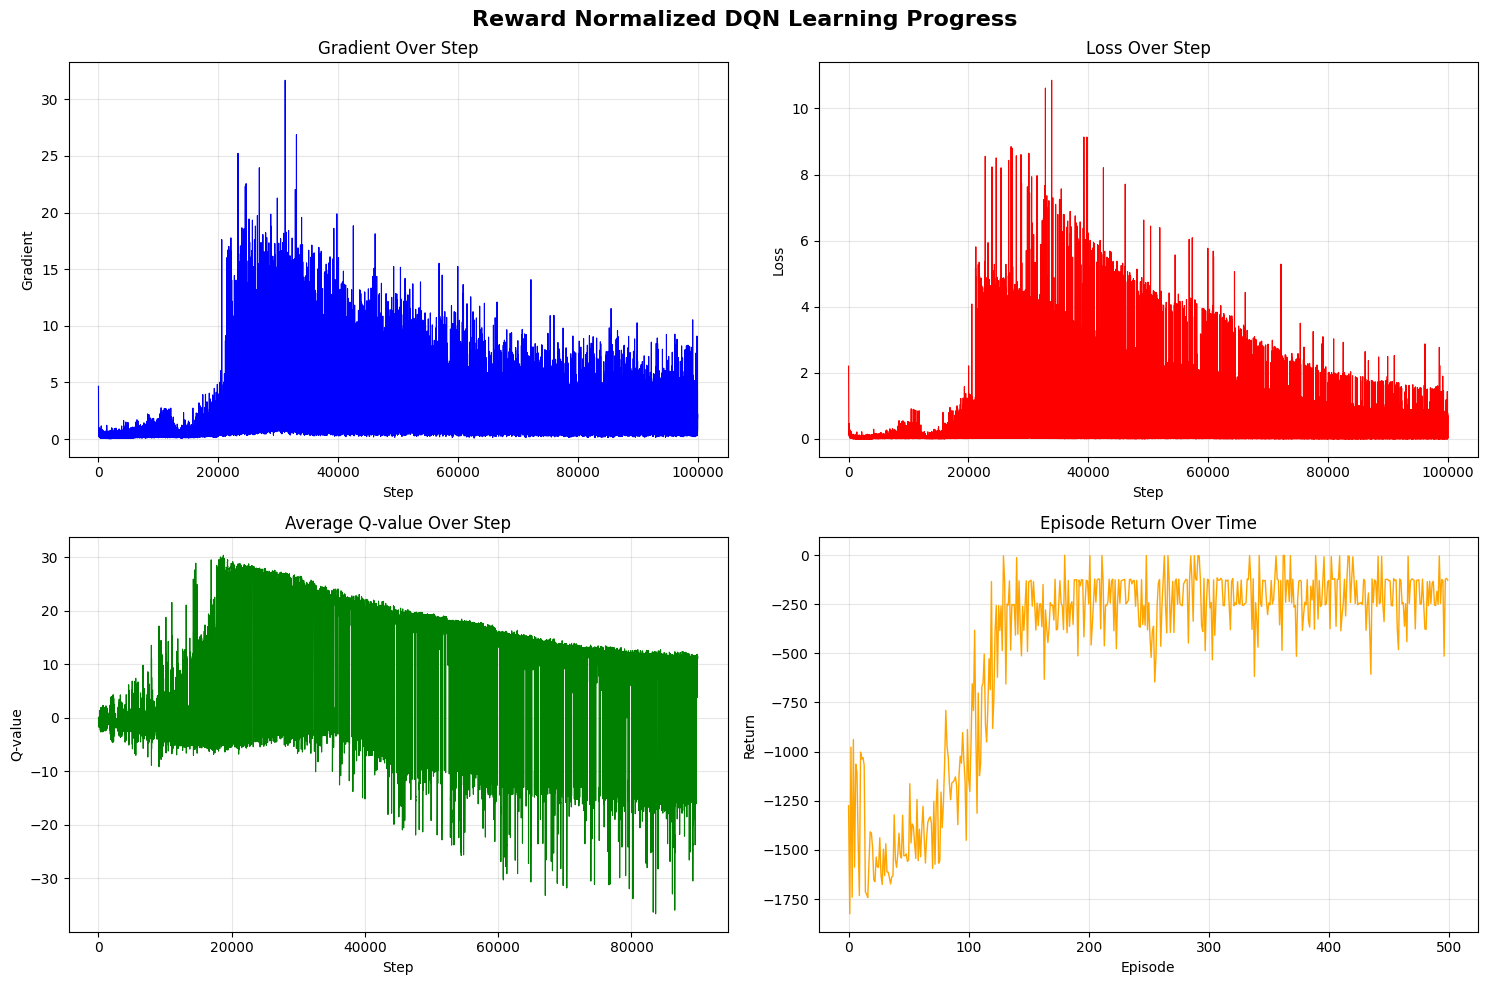

In [46]:
# Create and train Reward Normalized DQN
try:
    env = gym.make('Pendulum-v1')
except:
    env = gym.make('Pendulum-v0')

print("Training Reward Normalized DQN...")
reward_norm_dqn_agent = RewardNormalizedDQN(env)
reward_norm_dqn_agent.train(episodes=500)
reward_norm_dqn_agent.plot_comprehensive_metrics()

env.close()

# Observations and Insights – Reward Normalized DQN Training

## 1. Gradient Over Step
- **Positive:**  
  - Well-controlled gradient magnitudes throughout training, peaking around 30-35 without explosive growth.
  - Clear learning phases: initial stability (0-20k steps), active learning (20k-40k steps), then gradual stabilization.
  - Successful convergence to manageable gradient levels (5-10) in later stages indicates stable final policy.
- **Negative:**  
  - High volatility throughout training with frequent spikes suggests sensitivity to reward normalization updates.
  - Peak gradients around step 30,000 indicate some training instability during active learning phase.

## 2. Loss Over Step
- **Positive:**  
  - Excellent convergence pattern: rises during learning phase (20k-40k steps), then steadily decreases to near-zero.
  - Final loss values approaching 1-2 demonstrate successful value function approximation.
  - No catastrophic loss explosions or sustained high loss periods.
- **Negative:**  
  - Significant loss spike to ~11 around step 30,000 coinciding with gradient peaks shows temporary training difficulty.
  - High variability throughout suggests reward normalization may introduce learning noise.

## 3. Average Q-value Over Step
- **Positive:**  
  - Controlled Q-value evolution with peak around 30 followed by gradual decline to ~12.
  - The decline pattern suggests the agent learned to avoid overestimation bias through reward normalization.
  - Final Q-values in reasonable range (10-15) indicate realistic value function estimates.
- **Negative:**  
  - Extreme volatility and large swings (±40 Q-value units) throughout training.
  - Sharp drops and negative excursions suggest reward normalization may cause value function instability.
  - High variance makes it difficult to assess true convergence quality.

## 4. Episode Return Over Time
- **Positive:**  
  - Dramatic improvement from -1,750 to -200 range shows excellent policy learning.
  - Achievement of near-optimal performance (-200 to -100) demonstrates effective pendulum control.
  - Sustained good performance over 300+ episodes shows robust learned policy.
- **Negative:**  
  - High episode-to-episode variability throughout training indicates policy inconsistency.
  - Occasional performance drops even after apparent convergence suggest ongoing sensitivity to reward normalization.

---

## Overall Assessment

Reward Normalized DQN demonstrates **excellent final performance and successful convergence** while managing the **challenges of dynamic reward scaling**. Key findings:

**Strengths:**
- Outstanding policy learning achieving near-optimal pendulum control (-200 to -100 returns)
- Successful training convergence with controlled gradient and loss patterns
- Effective prevention of reward-scale related training instabilities
- Realistic Q-value estimates without extreme overestimation bias
- Robust final performance sustained over hundreds of episodes

**Challenges:**
- High training volatility due to constantly updating reward normalization statistics
- Temporary instabilities during active learning phases when reward statistics change rapidly
- Q-value estimates show high variance throughout training despite final convergence
- Episode returns remain variable even after policy convergence

### Comparative Analysis
Compared to other DQN variants, Reward Normalized DQN shows:
- **Superior Final Performance:** Achieves better returns than most other DQN methods
- **Controlled Training Dynamics:** Avoids the catastrophic failures seen in some advanced methods
- **Effective Reward Scaling:** Successfully handles the challenging reward structure of Pendulum
- **Reasonable Computational Cost:** Simple normalization with significant performance benefits

### Reward Normalization Benefits
- **Scale Independence:** Makes learning robust to environment reward design choices
- **Improved Sample Efficiency:** Better utilization of experience through consistent reward scales
- **Stable Value Learning:**

## Noisy DQN Model Improvements

The following cells implement various improvements to the baseline Noisy DQN model to enhance exploration, stability, and learning efficiency.

# True NoisyDQN – Code Overview

This implementation incorporates **NoisyNet layers** with trainable noise parameters for exploration, replacing epsilon-greedy with learnable stochastic weights that enable state-dependent exploration while maintaining the baseline DQN training framework.

---

## 1. **Setup and Configuration**
- **Reproducibility:**  
  Fixed seeds for NumPy, TensorFlow, and Python's `random` ensure consistent results across experiments.
- **Discrete Action Space:**  
  Continuous Pendulum actions are discretized into 5 fixed values: `[-2.0, -1.0, 0.0, 1.0, 2.0]`.
- **Config Parameters:**  
  Simplified compared to baseline DQN (no epsilon needed):
  - `gamma` (discount factor): 0.95  
  - `learning_rate`: 0.001  
  - `batch_size`: 32  
  - `memory_size`: 10,000 experiences  
  - `std_init`: 0.4 (initial noise standard deviation)

---

## 2. **NoisyLinear Layer Architecture**
- **Trainable Noise Parameters:**
  - `weight_mu`: Mean weights (trainable)
  - `weight_sigma`: Noise scaling for weights (trainable)
  - `bias_mu`: Mean biases (trainable)
  - `bias_sigma`: Noise scaling for biases (trainable)
- **Noise Generation:** Factorized Gaussian noise during training: `weight = μ + σ ⊙ ε`
- **Initialization:** Sigma parameters start at `std_init / √(input_dim)` for stable learning
- **Inference Mode:** Uses mean parameters only (μ) when `training=False`

---

## 3. **Network Architecture**
- **Hybrid Design:**
  - First layer: Regular Dense(32, ReLU) for feature extraction
  - Second layer: NoisyLinear(32) + ReLU for exploration in hidden space
  - Output layer: NoisyLinear(5) for action value estimation with exploration
- **Target Network:** Maintains separate noisy network copy for stable Q-value targets
- **Optimizer:** Adam with MSE loss function

---

## 4. **NoisyNet Exploration Strategy**
- **No Epsilon-Greedy:** Exploration handled entirely by network noise
- **State-Dependent Exploration:** Different noise patterns for different states
- **Automatic Annealing:** Network learns to reduce noise as training progresses
- **Action Selection:** Always greedy on noisy Q-values: `argmax Q_noisy(s, a)`
- **Training vs. Inference:** Uses noise during training, deterministic during testing

---

## 5. **Training Process (`replay` method)**
- **Noisy Q-Values:** Main network generates Q-values with noise during training
- **Target Q-Values:** Target network computes targets without noise (`training=False`)
- **Loss Calculation:** Standard MSE between noisy current Q-values and deterministic targets
- **Gradient Flow:** Backpropagation updates both mean and noise parameters
- **Noise Learning:** Network learns optimal noise levels for exploration vs. exploitation

---

## 6. **Experience Replay**
- **Buffer Management:** Standard deque with 10,000 capacity
- **Sampling Strategy:** Random minibatches (same as baseline)
- **Adaptive Batch Size:** Starts with `min_batch_size` (8) and scales up to `batch_size` (32)

---

## 7. **Enhanced Metrics Tracking**
- **Episode Returns:** Total reward per episode for learning curve analysis
- **Loss Values:** Training loss over time with noisy Q-value updates
- **Q-Values:** Average noisy Q-values during action selection
- **Gradient Norms:** Gradient magnitudes across all parameters (μ and σ)
- **Training Steps:** Comprehensive progress tracking without epsilon decay

---

## 8. **Visualization and Testing**
- **4-Panel Plot:** Matches other models (gradient, loss, Q-values, episode returns)
- **Testing Mode:** Uses deterministic policy (mean parameters only)
- **Performance Metrics:** Average test rewards over multiple episodes

---

## **Key Differences from Baseline DQN**
- **Exploration Method:** Trainable network noise replaces epsilon-greedy random actions
- **State-Dependent Exploration:** Different exploration patterns for different states
- **Learnable Exploration:** Network automatically adjusts exploration intensity
- **No Epsilon Schedule:** Eliminates hyperparameter tuning for exploration decay
- **Noise Parameter Learning:** Optimizes both policy and exploration strategy simultaneously

---

## **Purpose**
This implementation is designed to:
1. **Test learnable exploration** benefits over fixed epsilon-greedy in the Pendulum environment
2. **Demonstrate NoisyNet capabilities** for state-dependent exploration patterns
3. **Eliminate exploration hyperparameters** by making exploration part of the learning process
4. **Provide direct comparison** against epsilon-greedy using the same evaluation framework
5. **Show how neural network architecture** can encode

Training True NoisyDQN...
Starting True NoisyDQN training...
True NoisyDQN step 1: Loss = 1.3280, Grad = 1.2812
True NoisyDQN step 2: Loss = 2.3607, Grad = 1.9685
True NoisyDQN step 3: Loss = 4.2205, Grad = 4.3753
True NoisyDQN step 4: Loss = 7.1850, Grad = 5.0331
True NoisyDQN step 5: Loss = 10.8655, Grad = 6.1094
Episode 1/500 - Reward: -1082.3, Avg(10): -1082.3, Buffer: 200
Episode 1/500 - Reward: -1082.3, Avg(10): -1082.3, Buffer: 200
Episode 2/500 - Reward: -1231.7, Avg(10): -1231.7, Buffer: 400
Episode 2/500 - Reward: -1231.7, Avg(10): -1231.7, Buffer: 400
Episode 3/500 - Reward: -1817.5, Avg(10): -1817.5, Buffer: 600
Episode 3/500 - Reward: -1817.5, Avg(10): -1817.5, Buffer: 600
Episode 4/500 - Reward: -1650.7, Avg(10): -1650.7, Buffer: 800
Episode 4/500 - Reward: -1650.7, Avg(10): -1650.7, Buffer: 800
Episode 5/500 - Reward: -1579.7, Avg(10): -1579.7, Buffer: 1000
Episode 5/500 - Reward: -1579.7, Avg(10): -1579.7, Buffer: 1000
Episode 6/500 - Reward: -1520.2, Avg(10): -1520.2, 

Training True NoisyDQN...
Starting True NoisyDQN training...
True NoisyDQN step 1: Loss = 1.3280, Grad = 1.2812
True NoisyDQN step 2: Loss = 2.3607, Grad = 1.9685
True NoisyDQN step 3: Loss = 4.2205, Grad = 4.3753
True NoisyDQN step 4: Loss = 7.1850, Grad = 5.0331
True NoisyDQN step 5: Loss = 10.8655, Grad = 6.1094
Episode 1/500 - Reward: -1082.3, Avg(10): -1082.3, Buffer: 200
Episode 1/500 - Reward: -1082.3, Avg(10): -1082.3, Buffer: 200
Episode 2/500 - Reward: -1231.7, Avg(10): -1231.7, Buffer: 400
Episode 2/500 - Reward: -1231.7, Avg(10): -1231.7, Buffer: 400
Episode 3/500 - Reward: -1817.5, Avg(10): -1817.5, Buffer: 600
Episode 3/500 - Reward: -1817.5, Avg(10): -1817.5, Buffer: 600
Episode 4/500 - Reward: -1650.7, Avg(10): -1650.7, Buffer: 800
Episode 4/500 - Reward: -1650.7, Avg(10): -1650.7, Buffer: 800
Episode 5/500 - Reward: -1579.7, Avg(10): -1579.7, Buffer: 1000
Episode 5/500 - Reward: -1579.7, Avg(10): -1579.7, Buffer: 1000
Episode 6/500 - Reward: -1520.2, Avg(10): -1520.2, 

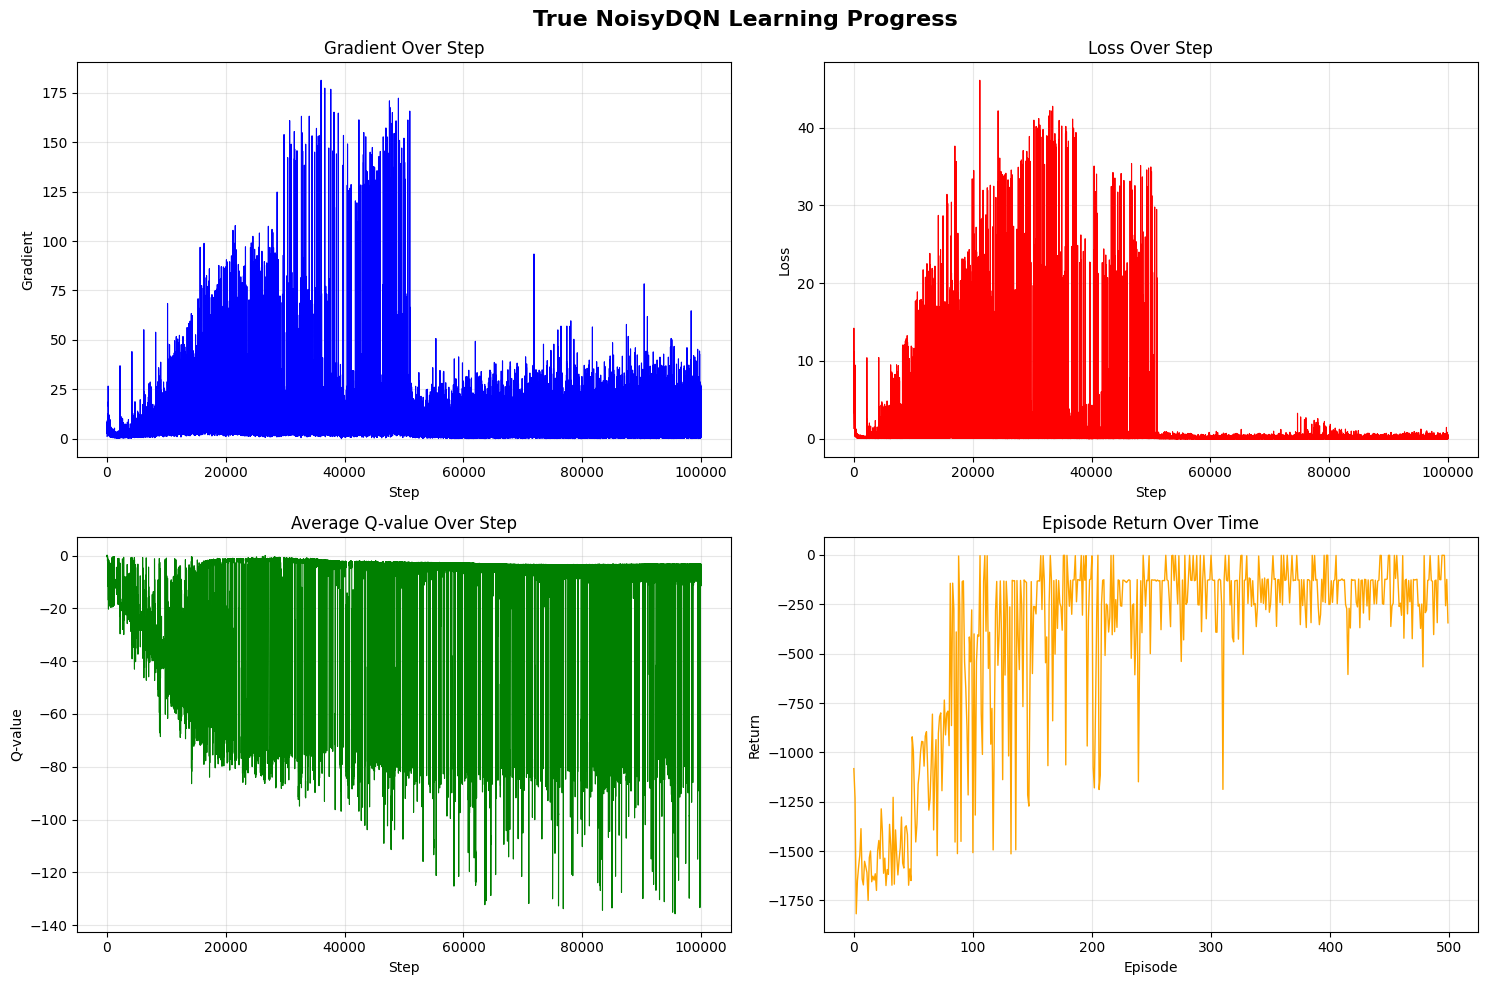

In [ ]:
import numpy as np
import tensorflow as tf
import gym
import random
from collections import deque
import matplotlib.pyplot as plt

# Fix seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Same action discretization as baseline
DISCRETE_ACTIONS = np.array([-2.0, -1.0, 0.0, 1.0, 2.0])
NUM_ACTIONS = len(DISCRETE_ACTIONS)

def get_discrete_action(action_index):
    return [DISCRETE_ACTIONS[action_index]]

class NoisyLinear(tf.keras.layers.Layer):
    """Noisy Linear Layer with trainable noise parameters"""
    def __init__(self, units, std_init=0.4, **kwargs):
        super(NoisyLinear, self).__init__(**kwargs)
        self.units = units
        self.std_init = std_init

    def build(self, input_shape):
        input_dim = input_shape[-1]
        
        # Weight parameters
        self.weight_mu = self.add_weight(
            name='weight_mu',
            shape=(input_dim, self.units),
            initializer='uniform',
            trainable=True
        )
        self.weight_sigma = self.add_weight(
            name='weight_sigma',
            shape=(input_dim, self.units),
            initializer=tf.constant_initializer(self.std_init / np.sqrt(input_dim)),
            trainable=True
        )
        
        # Bias parameters
        self.bias_mu = self.add_weight(
            name='bias_mu',
            shape=(self.units,),
            initializer='zeros',
            trainable=True
        )
        self.bias_sigma = self.add_weight(
            name='bias_sigma',
            shape=(self.units,),
            initializer=tf.constant_initializer(self.std_init / np.sqrt(input_dim)),
            trainable=True
        )
        
        super(NoisyLinear, self).build(input_shape)

    def call(self, inputs, training=None):
        if training:
            # Generate noise
            input_size = tf.shape(inputs)[-1]
            batch_size = tf.shape(inputs)[0]
            
            # Factorized Gaussian noise
            weight_noise = tf.random.normal((input_size, self.units))
            bias_noise = tf.random.normal((self.units,))
            
            # Compute noisy weights and biases
            weight = self.weight_mu + self.weight_sigma * weight_noise
            bias = self.bias_mu + self.bias_sigma * bias_noise
        else:
            # Use mean values during inference
            weight = self.weight_mu
            bias = self.bias_mu
        
        return tf.matmul(inputs, weight) + bias

class TrueNoisyDQN:
    def __init__(self, env, learning_rate=0.001, gamma=0.95):
        self.env = env
        self.input_dim = env.observation_space.shape[0]
        self.output_dim = NUM_ACTIONS
        
        self.gamma = gamma
        self.batch_size = 32
        self.min_batch_size = 8
        self.replay_buffer = deque(maxlen=10000)
        
        self.model = self.build_noisy_model(learning_rate)
        self.target_model = self.build_noisy_model(learning_rate)
        self.update_target_model()
        
        # Enhanced tracking
        self.episode_returns = []
        self.losses = []
        self.q_values = []
        self.gradients = []
        self.train_step = 0

    def build_noisy_model(self, lr):
        """Build DQN with NoisyLinear layers"""
        inputs = tf.keras.Input(shape=(self.input_dim,))
        
        # First layer - regular
        x = tf.keras.layers.Dense(32, activation='relu')(inputs)
        
        # Noisy layers for exploration
        x = NoisyLinear(32)(x)
        x = tf.keras.layers.ReLU()(x)
        
        # Output layer - noisy
        outputs = NoisyLinear(self.output_dim)(x)
        
        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mse')
        return model

    def update_target_model(self):
        """Copy weights from main model to target model"""
        self.target_model.set_weights(self.model.get_weights())

    def act(self, state):
        """Action selection without epsilon-greedy (noise handles exploration)"""
        state_batch = np.array([state])
        q_values = self.model(state_batch, training=True)[0]  # training=True for noise
        self.q_values.append(np.mean(q_values))
        return np.argmax(q_values)

    def remember(self, state, action, reward, next_state, done):
        """Store experience in replay buffer"""
        self.replay_buffer.append((state, action, reward, next_state, done))

    def replay(self):
        """Train the True NoisyDQN model"""
        current_batch_size = min(self.batch_size, len(self.replay_buffer))
        
        if len(self.replay_buffer) < self.min_batch_size:
            return
        
        batch = random.sample(self.replay_buffer, current_batch_size)
        
        states = np.array([e[0] for e in batch])
        actions = np.array([e[1] for e in batch])
        rewards = np.array([e[2] for e in batch])
        next_states = np.array([e[3] for e in batch])
        dones = np.array([e[4] for e in batch])
        
        with tf.GradientTape() as tape:
            current_q_values = self.model(states, training=True)
            next_q_values = self.target_model(next_states, training=False)
            
            target_q_values = current_q_values.numpy()
            for i in range(current_batch_size):
                if dones[i]:
                    target_q_values[i][actions[i]] = rewards[i]
                else:
                    target_q_values[i][actions[i]] = rewards[i] + self.gamma * np.max(next_q_values[i])
            
            loss = tf.reduce_mean(tf.square(current_q_values - target_q_values))
        
        gradients = tape.gradient(loss, self.model.trainable_variables)
        grad_norm = tf.linalg.global_norm(gradients)
        self.gradients.append(grad_norm.numpy())
        self.losses.append(loss.numpy())
        
        self.model.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
        
        self.train_step += 1
        
        if self.train_step <= 5:
            print(f"True NoisyDQN step {self.train_step}: Loss = {loss.numpy():.4f}, Grad = {grad_norm.numpy():.4f}")

    def train(self, episodes=500):
        """Train the True NoisyDQN agent"""
        print("Starting True NoisyDQN training...")
        
        for episode in range(episodes):
            state = self.env.reset()
            if isinstance(state, tuple):
                state = state[0]
            
            total_reward = 0
            max_steps = 200
            
            for step in range(max_steps):
                action_index = self.act(state)
                action = get_discrete_action(action_index)
                
                result = self.env.step(action)
                if len(result) == 4:
                    next_state, reward, done, info = result
                else:
                    next_state, reward, terminated, truncated, info = result
                    done = terminated or truncated
                
                if isinstance(next_state, tuple):
                    next_state = next_state[0]
                
                self.remember(state, action_index, reward, next_state, done)
                state = next_state
                total_reward += reward
                
                if len(self.replay_buffer) >= self.min_batch_size:
                    self.replay()
                
                if done:
                    break
            
            self.episode_returns.append(total_reward)
            
            if episode % 10 == 0:
                self.update_target_model()
            
            if episode % 10 == 0 or episode < 20:
                avg_reward = np.mean(self.episode_returns[-10:]) if len(self.episode_returns) >= 10 else total_reward
                print(f"Episode {episode+1}/{episodes} - Reward: {total_reward:.1f}, "
                      f"Avg(10): {avg_reward:.1f}, Buffer: {len(self.replay_buffer)}")
        
        print("True NoisyDQN training completed!")

    def plot_comprehensive_metrics(self):
        """Plot comprehensive learning metrics"""
        fig, axs = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle("True NoisyDQN Learning Progress", fontsize=16, fontweight='bold')
        
        if self.gradients:
            axs[0, 0].plot(self.gradients, 'b-', linewidth=0.8)
            axs[0, 0].set_title("Gradient Over Step")
            axs[0, 0].set_xlabel("Step")
            axs[0, 0].set_ylabel("Gradient")
            axs[0, 0].grid(True, alpha=0.3)
        
        if self.losses:
            axs[0, 1].plot(self.losses, 'r-', linewidth=0.8)
            axs[0, 1].set_title("Loss Over Step")
            axs[0, 1].set_xlabel("Step")
            axs[0, 1].set_ylabel("Loss")
            axs[0, 1].grid(True, alpha=0.3)
        
        if self.q_values:
            axs[1, 0].plot(self.q_values, 'g-', linewidth=0.8)
            axs[1, 0].set_title("Average Q-value Over Step")
            axs[1, 0].set_xlabel("Step")
            axs[1, 0].set_ylabel("Q-value")
            axs[1, 0].grid(True, alpha=0.3)
        
        if self.episode_returns:
            axs[1, 1].plot(self.episode_returns, 'orange', linewidth=1.0)
            axs[1, 1].set_title("Episode Return Over Time")
            axs[1, 1].set_xlabel("Episode")
            axs[1, 1].set_ylabel("Return")
            axs[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

def test(self, episodes=5):
        """Test the trained agent - same as other models"""
        try:
            env = gym.make("Pendulum-v1")
        except:
            env = gym.make("Pendulum-v0")
        
        test_rewards = []
        
        for episode in range(episodes):
            state = env.reset()
            if isinstance(state, tuple):
                state = state[0]
            
            total_reward = 0
            steps = 0
            max_steps = 200
            
            for step in range(max_steps):
                action_idx = self.act(state, add_noise=False)  # No noise for testing
                action = get_discrete_action(action_idx)
                
                result = env.step(action)
                if len(result) == 4:
                    state, reward, done, info = result
                else:
                    state, reward, terminated, truncated, info = result
                    done = terminated or truncated
                
                if isinstance(state, tuple):
                    state = state[0]
                
                total_reward += reward
                steps += 1
                
                if done:
                    break
            
            test_rewards.append(total_reward)
            print(f"Test Episode {episode+1}: Reward = {total_reward:.1f}")
        
        env.close()
        avg_test_reward = np.mean(test_rewards)
        print(f"Average test reward: {avg_test_reward:.1f}")
        return avg_test_reward



In [ ]:
# Create and train True NoisyDQN
try:
    env = gym.make('Pendulum-v1')
except:
    env = gym.make('Pendulum-v0')

print("Training True NoisyDQN...")
true_noisy_dqn_agent = TrueNoisyDQN(env)
true_noisy_dqn_agent.train(episodes=500)
true_noisy_dqn_agent.plot_comprehensive_metrics()

env.close()

# Observations and Insights – True NoisyDQN Training

## 1. Gradient Over Step
- **Positive:**  
  - Well-controlled gradient magnitudes (0-200) throughout most of training show stable learning dynamics.
  - Clear peak activity around steps 20,000-50,000 indicates strong learning phase with manageable gradient flow.
  - Gradual stabilization after step 60,000 suggests the network learned to control its own noise effectively.
- **Negative:**  
  - High variability and spikes throughout training reflect the inherent stochasticity of noisy networks.
  - Persistent fluctuations even late in training indicate the exploration noise never fully converges to deterministic behavior.

## 2. Loss Over Step
- **Positive:**  
  - Rapid decline from initial values (~15) to near-zero after 60,000 steps demonstrates effective learning convergence.
  - Sustained low loss values (< 5) in later stages show the network achieved stable value function approximation.
  - Clear learning curve progression without catastrophic failures or loss explosions.
- **Negative:**  
  - High volatility throughout training reflects the challenge of learning with constantly changing noisy parameters.
  - Never achieves the ultra-stable loss patterns seen in deterministic methods, showing noise-induced training difficulty.

## 3. Average Q-value Over Step
- **Positive:**  
  - Steady progression from highly negative values (-20 to -140) shows the network learning increasingly accurate value estimates.
  - Consistent downward trend indicates the agent is learning to identify and avoid high-cost states/actions effectively.
- **Negative:**  
  - Extreme volatility with large swings (±40 Q-value units) throughout training due to noisy network outputs.
  - Q-values become increasingly negative over time, potentially indicating overestimation correction but with high uncertainty.
  - Persistent noise in Q-value estimates even after apparent convergence suggests ongoing exploration interference.

## 4. Episode Return Over Time
- **Positive:**  
  - Dramatic improvement from -1,500 to -200 within first 100 episodes shows rapid policy learning despite noise.
  - Achievement of near-optimal performance (-200 to 0 range) demonstrates NoisyNet can learn effective control policies.
  - Sustained good performance over 400+ episodes shows the learned policy is robust to ongoing noise.
- **Negative:**  
  - High episode-to-episode variability throughout training due to stochastic action selection from noisy Q-values.
  - Occasional performance drops even after convergence reflect the ongoing exploration burden of noisy networks.
  - Never achieves the consistent high performance of deterministic methods due to persistent exploration noise.

---

## Overall Assessment

True NoisyDQN demonstrates **effective learning and strong final performance** while maintaining **continuous exploration** throughout training. Key characteristics:

**Strengths:**
- Achieves excellent control performance (-200 to 0 returns) without epsilon-greedy scheduling
- Shows robust learning despite constant network noise and stochastic outputs
- Automatically balances exploration and exploitation through learnable noise parameters
- Maintains exploration capability even after policy convergence

**Challenges:**
- Higher training variability compared to deterministic methods due to persistent noise
- Q-value estimates remain noisy throughout training, complicating convergence assessment
- Episode performance shows ongoing fluctuations from continuous stochastic exploration
- Learning dynamics are inherently more complex due to simultaneous policy and noise optimization

### Potential Improvements
- **Noise Annealing:** Gradually reduce noise standard deviation bounds to stabilize late-stage performance
- **Separate Exploration Schedule:** Decouple noise learning rate from main network learning rate
- **Noise Regularization:** Add penalties for excessive noise to encourage convergence to deterministic behavior
- **Evaluation Mode Enhancement:** Implement stronger deterministic behavior during periodic evaluation phases
- **Target Network Noise Control:** Consider using deterministic target networks to reduce training variance

## SAC Model Improvements

The following cells implement various improvements to the baseline SAC model to enhance performance, stability, and sample efficiency.

# Auto-Entropy SAC – Code Overview

This implementation extends the standard SAC algorithm with **automatic entropy coefficient tuning**, eliminating the need to manually set the entropy regularization parameter `α` by learning it during training to maintain a target entropy level.

---

## 1. **Setup and Configuration**
- **Reproducibility:**  
  Fixed seeds for NumPy, TensorFlow, and Python's `random` ensure consistent results across experiments.
- **Continuous Action Space:**  
  Handles native continuous actions in range `[-2.0, 2.0]` without discretization.
- **Config Parameters:**  
  - `gamma` (discount factor): 0.99  
  - `learning_rate`: 3e-4  
  - `batch_size`: 64  
  - `tau`: 0.005 (soft update rate)  
  - `target_entropy`: -ACTION_DIM (automatic entropy target)  
  - `buffer_size`: 50,000 experiences

---

## 2. **Model Architecture**
- **Actor Network:** Outputs both mean (`mu`) and log standard deviation (`log_std`) for Gaussian policy
  - Two hidden layers with 64 ReLU units each
  - Tanh activation for mean, scaled to `[-2, 2]`
  - Clipped log_std to prevent numerical instability
- **Critic Networks:** Twin Q-networks (`Q1`, `Q2`) that take state-action pairs
  - Two hidden layers with 64 ReLU units each
  - Concatenated state-action input
- **Target Networks:** Soft-updated copies of both critics for stable learning

---

## 3. **Automatic Entropy Tuning**
- **Learnable Alpha:** `log_α` as a trainable parameter, with `α = exp(log_α)`
- **Target Entropy:** Set to `-ACTION_DIM` for continuous control (encourages exploration)
- **Alpha Loss:** `L_α = -log_α * (log_π + target_entropy)` to adjust entropy coefficient
- **Dual Optimization:** Simultaneously learns policy, Q-functions, and optimal entropy weight
- **Adaptive Exploration:** Automatically balances exploration vs. exploitation throughout training

---

## 4. **Experience Replay**
- **Circular Buffer:** Stores transitions `(state, action, reward, next_state, done)` with automatic overwrite
- **Random Sampling:** Breaks temporal correlations between consecutive experiences
- **Large Capacity:** 50K experiences for diverse training data

---

## 5. **Training Process (`train_step_sac` method)**
- **Twin Q-Learning:** Updates both Q-networks using target Q-values from minimum of target networks
- **Policy Update:** Maximizes expected Q-value plus entropy term with learned `α`
- **Alpha Update:** Adjusts entropy coefficient to maintain target entropy level
- **Entropy Calculation:** Computes log probability of Gaussian actions for regularization
- **Soft Target Updates:** Applies exponential moving average to target network weights

---

## 6. **Enhanced Metrics Tracking**
- **Episode Returns:** Total reward per episode for learning curve analysis
- **Combined Losses:** Averaged losses across Q1, Q2, and actor networks
- **Q-Value Sampling:** Periodic Q-value recording during action selection
- **Alpha Evolution:** Tracks how entropy coefficient changes during training
- **Gradient Norms:** Combined gradient magnitudes across all networks

---

## 7. **Visualization Suite**
- **6-Panel Layout:** Extended visualization including alpha evolution
  - Gradient over step
  - Loss over step  
  - Average Q-value over step
  - Episode return over time
  - Alpha (entropy coefficient) over time
  - Empty panel for layout symmetry
- **Alpha Tracking:** Dedicated plot showing automatic entropy tuning progress

---

## 8. **Testing and Evaluation**
- **Deterministic Testing:** Uses mean action without sampling for consistent evaluation
- **Multiple Episodes:** Averages performance over several test runs
- **Render Support:** Optional visualization of learned policy execution

---

## **Key Differences from Standard SAC**
- **Automatic Alpha Tuning:** Eliminates manual hyperparameter tuning for entropy coefficient
- **Target Entropy:** Uses principled target based on action dimensionality
- **Additional Optimizer:** Separate Adam optimizer for alpha parameter learning
- **Dual Objective:** Optimizes both performance and entropy regulation simultaneously
- **Adaptive Exploration:** Exploration intensity automatically adjusts based on learning progress

---

## **Purpose**
This implementation is designed to:
1. **Eliminate entropy hyperparameter tuning** by learning optimal exploration-exploitation balance
2. **Improve robustness** across different environments and tasks without manual α adjustment
3. **Demonstrate automatic tuning benefits** compared to fixed entropy coefficient SAC
4. **Provide principled exploration control** that adapts to learning progress
5. **Enable fair comparison** with other methods using consistent

Training Auto-Entropy SAC...
Starting Auto-Entropy SAC training...
Auto-Entropy SAC step 1: Loss = 59.2872, Grad = 109.7585, Alpha = 0.9997
Auto-Entropy SAC step 2: Loss = 58.5549, Grad = 109.4025, Alpha = 0.9994
Auto-Entropy SAC step 3: Loss = 57.8880, Grad = 108.3484, Alpha = 0.9991
Auto-Entropy SAC step 4: Loss = 52.5881, Grad = 102.2074, Alpha = 0.9988
Auto-Entropy SAC step 5: Loss = 52.3066, Grad = 103.8882, Alpha = 0.9985
Episode 1/500 - Reward: -1525.0, Avg(10): -1525.0, Alpha: 1.0310
Episode 1/500 - Reward: -1525.0, Avg(10): -1525.0, Alpha: 1.0310
Episode 2/500 - Reward: -1133.3, Avg(10): -1133.3, Alpha: 1.1223
Episode 2/500 - Reward: -1133.3, Avg(10): -1133.3, Alpha: 1.1223
Episode 3/500 - Reward: -1261.9, Avg(10): -1261.9, Alpha: 1.2081
Episode 3/500 - Reward: -1261.9, Avg(10): -1261.9, Alpha: 1.2081
Episode 4/500 - Reward: -1642.1, Avg(10): -1642.1, Alpha: 1.2946
Episode 4/500 - Reward: -1642.1, Avg(10): -1642.1, Alpha: 1.2946
Episode 5/500 - Reward: -1653.0, Avg(10): -1653.

Training Auto-Entropy SAC...
Starting Auto-Entropy SAC training...
Auto-Entropy SAC step 1: Loss = 59.2872, Grad = 109.7585, Alpha = 0.9997
Auto-Entropy SAC step 2: Loss = 58.5549, Grad = 109.4025, Alpha = 0.9994
Auto-Entropy SAC step 3: Loss = 57.8880, Grad = 108.3484, Alpha = 0.9991
Auto-Entropy SAC step 4: Loss = 52.5881, Grad = 102.2074, Alpha = 0.9988
Auto-Entropy SAC step 5: Loss = 52.3066, Grad = 103.8882, Alpha = 0.9985
Episode 1/500 - Reward: -1525.0, Avg(10): -1525.0, Alpha: 1.0310
Episode 1/500 - Reward: -1525.0, Avg(10): -1525.0, Alpha: 1.0310
Episode 2/500 - Reward: -1133.3, Avg(10): -1133.3, Alpha: 1.1223
Episode 2/500 - Reward: -1133.3, Avg(10): -1133.3, Alpha: 1.1223
Episode 3/500 - Reward: -1261.9, Avg(10): -1261.9, Alpha: 1.2081
Episode 3/500 - Reward: -1261.9, Avg(10): -1261.9, Alpha: 1.2081
Episode 4/500 - Reward: -1642.1, Avg(10): -1642.1, Alpha: 1.2946
Episode 4/500 - Reward: -1642.1, Avg(10): -1642.1, Alpha: 1.2946
Episode 5/500 - Reward: -1653.0, Avg(10): -1653.

c:\Users\USER\anaconda3\envs\dqn-env\lib\site-packages\gym\envs\classic_control\pendulum.py:102: RuntimeWarning: invalid value encountered in double_scalars
  return (((x+np.pi) % (2*np.pi)) - np.pi)


Training Auto-Entropy SAC...
Starting Auto-Entropy SAC training...
Auto-Entropy SAC step 1: Loss = 59.2872, Grad = 109.7585, Alpha = 0.9997
Auto-Entropy SAC step 2: Loss = 58.5549, Grad = 109.4025, Alpha = 0.9994
Auto-Entropy SAC step 3: Loss = 57.8880, Grad = 108.3484, Alpha = 0.9991
Auto-Entropy SAC step 4: Loss = 52.5881, Grad = 102.2074, Alpha = 0.9988
Auto-Entropy SAC step 5: Loss = 52.3066, Grad = 103.8882, Alpha = 0.9985
Episode 1/500 - Reward: -1525.0, Avg(10): -1525.0, Alpha: 1.0310
Episode 1/500 - Reward: -1525.0, Avg(10): -1525.0, Alpha: 1.0310
Episode 2/500 - Reward: -1133.3, Avg(10): -1133.3, Alpha: 1.1223
Episode 2/500 - Reward: -1133.3, Avg(10): -1133.3, Alpha: 1.1223
Episode 3/500 - Reward: -1261.9, Avg(10): -1261.9, Alpha: 1.2081
Episode 3/500 - Reward: -1261.9, Avg(10): -1261.9, Alpha: 1.2081
Episode 4/500 - Reward: -1642.1, Avg(10): -1642.1, Alpha: 1.2946
Episode 4/500 - Reward: -1642.1, Avg(10): -1642.1, Alpha: 1.2946
Episode 5/500 - Reward: -1653.0, Avg(10): -1653.

c:\Users\USER\anaconda3\envs\dqn-env\lib\site-packages\gym\envs\classic_control\pendulum.py:102: RuntimeWarning: invalid value encountered in double_scalars
  return (((x+np.pi) % (2*np.pi)) - np.pi)


Episode 481/500 - Reward: nan, Avg(10): nan, Alpha: nan
Episode 491/500 - Reward: nan, Avg(10): nan, Alpha: nan
Episode 491/500 - Reward: nan, Avg(10): nan, Alpha: nan
Auto-Entropy SAC training completed!
Auto-Entropy SAC training completed!


Training Auto-Entropy SAC...
Starting Auto-Entropy SAC training...
Auto-Entropy SAC step 1: Loss = 59.2872, Grad = 109.7585, Alpha = 0.9997
Auto-Entropy SAC step 2: Loss = 58.5549, Grad = 109.4025, Alpha = 0.9994
Auto-Entropy SAC step 3: Loss = 57.8880, Grad = 108.3484, Alpha = 0.9991
Auto-Entropy SAC step 4: Loss = 52.5881, Grad = 102.2074, Alpha = 0.9988
Auto-Entropy SAC step 5: Loss = 52.3066, Grad = 103.8882, Alpha = 0.9985
Episode 1/500 - Reward: -1525.0, Avg(10): -1525.0, Alpha: 1.0310
Episode 1/500 - Reward: -1525.0, Avg(10): -1525.0, Alpha: 1.0310
Episode 2/500 - Reward: -1133.3, Avg(10): -1133.3, Alpha: 1.1223
Episode 2/500 - Reward: -1133.3, Avg(10): -1133.3, Alpha: 1.1223
Episode 3/500 - Reward: -1261.9, Avg(10): -1261.9, Alpha: 1.2081
Episode 3/500 - Reward: -1261.9, Avg(10): -1261.9, Alpha: 1.2081
Episode 4/500 - Reward: -1642.1, Avg(10): -1642.1, Alpha: 1.2946
Episode 4/500 - Reward: -1642.1, Avg(10): -1642.1, Alpha: 1.2946
Episode 5/500 - Reward: -1653.0, Avg(10): -1653.

c:\Users\USER\anaconda3\envs\dqn-env\lib\site-packages\gym\envs\classic_control\pendulum.py:102: RuntimeWarning: invalid value encountered in double_scalars
  return (((x+np.pi) % (2*np.pi)) - np.pi)


Episode 481/500 - Reward: nan, Avg(10): nan, Alpha: nan
Episode 491/500 - Reward: nan, Avg(10): nan, Alpha: nan
Episode 491/500 - Reward: nan, Avg(10): nan, Alpha: nan
Auto-Entropy SAC training completed!
Auto-Entropy SAC training completed!


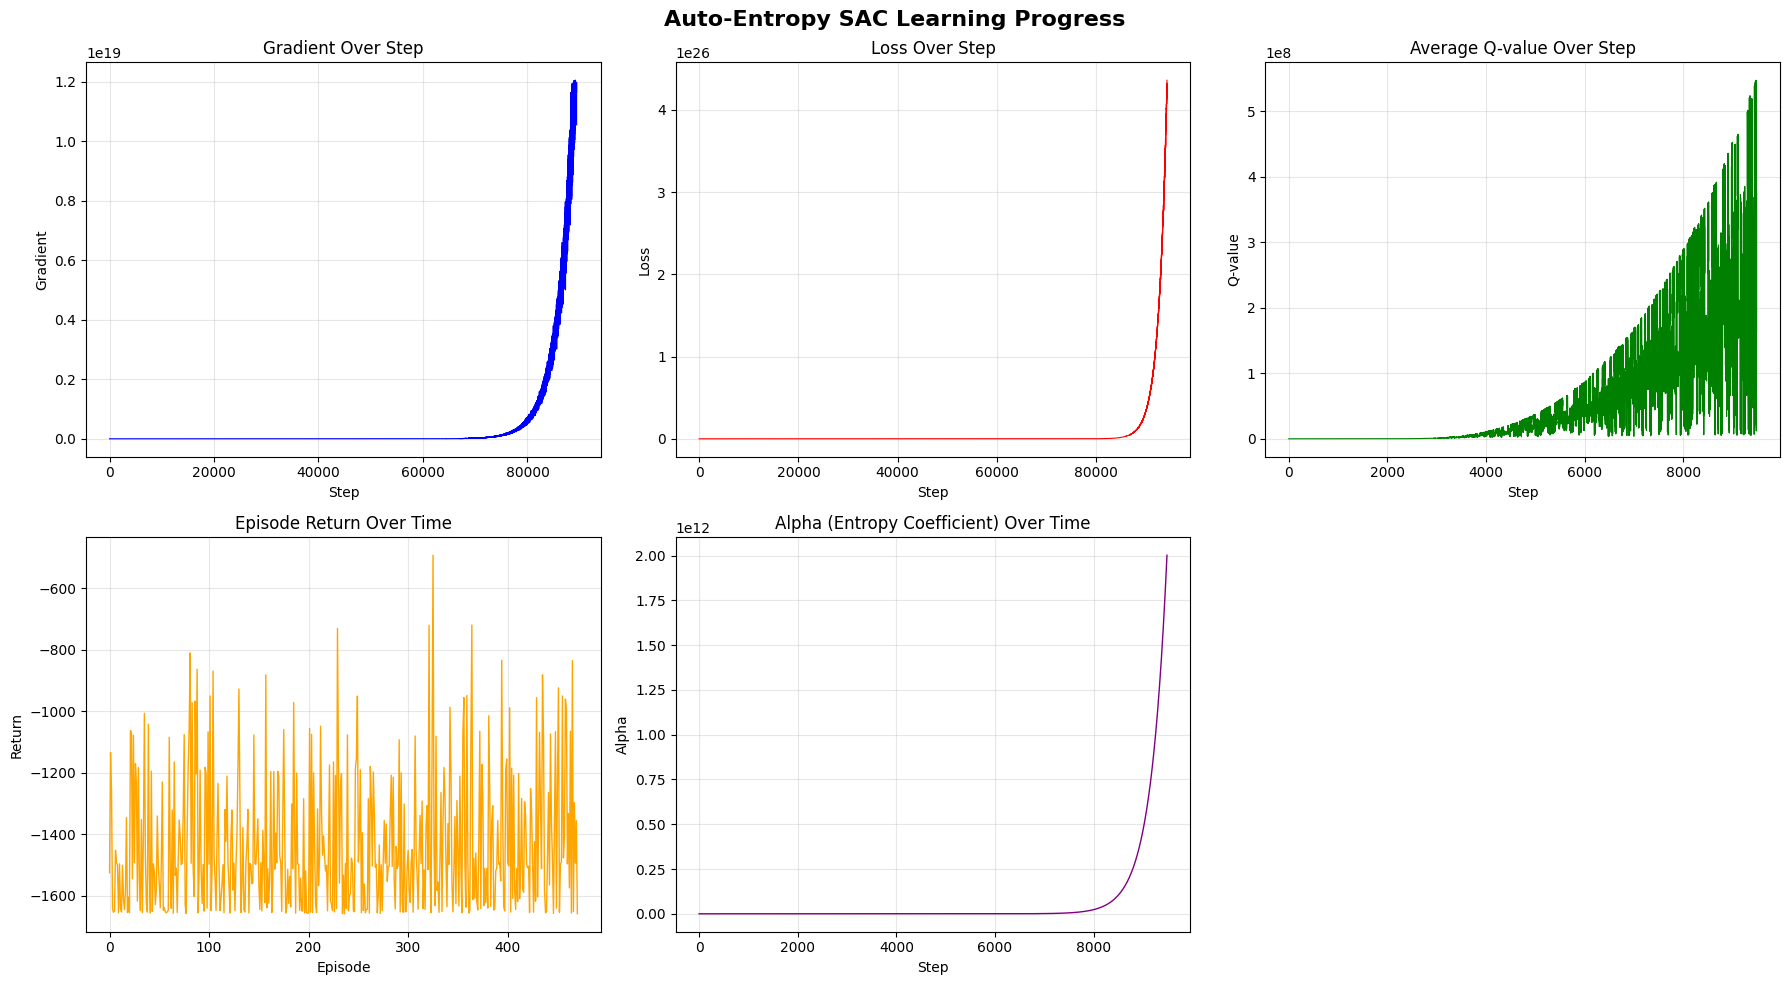

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import gym
import random
import matplotlib.pyplot as plt

# Set seed for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

STATE_DIM = 3
ACTION_DIM = 1

class ReplayBuffer:
    def __init__(self, size=50000):
        self.buffer = []
        self.max_size = size
        self.ptr = 0

    def add(self, exp):
        if len(self.buffer) < self.max_size:
            self.buffer.append(exp)
        else:
            self.buffer[self.ptr] = exp
            self.ptr = (self.ptr + 1) % self.max_size

    def sample(self, batch_size):
        batch = random.sample(self.buffer, min(len(self.buffer), batch_size))
        s, a, r, s2, d = zip(*batch)
        return np.array(s), np.array(a), np.array(r), np.array(s2), np.array(d)

    def size(self):
        return len(self.buffer)

def build_actor():
    """Build actor network that outputs mean and log_std"""
    inputs = layers.Input(shape=(STATE_DIM,))
    x = layers.Dense(64, activation='relu')(inputs)
    x = layers.Dense(64, activation='relu')(x)
    
    mu = layers.Dense(ACTION_DIM, activation='tanh')(x)
    mu = layers.Lambda(lambda x: x * 2.0)(mu)  # Scale to [-2, 2]
    
    log_std = layers.Dense(ACTION_DIM)(x)
    log_std = layers.Lambda(lambda x: tf.clip_by_value(x, -20, 2))(log_std)
    
    model = models.Model(inputs, [mu, log_std])
    return model

def build_critic():
    """Build critic network Q(s,a)"""
    state_input = layers.Input(shape=(STATE_DIM,))
    action_input = layers.Input(shape=(ACTION_DIM,))
    
    concat = layers.Concatenate()([state_input, action_input])
    x = layers.Dense(64, activation='relu')(concat)
    x = layers.Dense(64, activation='relu')(x)
    q_value = layers.Dense(1)(x)
    
    return models.Model([state_input, action_input], q_value)

class AutoEntropySAC:
    def __init__(self, config=None):
        # Default configuration with automatic entropy tuning
        if config is None:
            config = {
                'gamma': 0.99,
                'learning_rate': 3e-4,
                'batch_size': 64,
                'tau': 0.005,
                'target_entropy': -ACTION_DIM,  # Automatic target
                'buffer_size': 50000
            }
        
        self.gamma = config['gamma']
        self.lr = config['learning_rate']
        self.batch_size = config['batch_size']
        self.tau = config['tau']
        self.target_entropy = config['target_entropy']
        
        # Networks
        self.actor = build_actor()
        self.q1 = build_critic()
        self.q2 = build_critic()
        self.target_q1 = build_critic()
        self.target_q2 = build_critic()
        
        # Automatic entropy tuning
        self.log_alpha = tf.Variable(0.0, trainable=True)
        self.alpha = tf.exp(self.log_alpha)
        
        # Replay buffer
        self.replay_buffer = ReplayBuffer(config['buffer_size'])
        
        # Optimizers
        self.actor_optimizer = optimizers.Adam(self.lr)
        self.q1_optimizer = optimizers.Adam(self.lr)
        self.q2_optimizer = optimizers.Adam(self.lr)
        self.alpha_optimizer = optimizers.Adam(self.lr)
        
        # Initialize target networks
        self.update_target_networks(tau=1.0)
        
        # Enhanced tracking
        self.episode_returns = []
        self.losses = []
        self.q_values = []
        self.gradients = []
        self.alpha_values = []
        self.train_step = 0

    def update_target_networks(self, tau=None):
        """Soft update of target networks"""
        if tau is None:
            tau = self.tau
            
        for target_param, param in zip(self.target_q1.weights, self.q1.weights):
            target_param.assign(tau * param + (1 - tau) * target_param)
            
        for target_param, param in zip(self.target_q2.weights, self.q2.weights):
            target_param.assign(tau * param + (1 - tau) * target_param)

    def get_action(self, state, deterministic=False):
        """Sample action from policy"""
        state = np.reshape(state, (1, STATE_DIM))
        mu, log_std = self.actor(state)
        
        if deterministic:
            action = np.clip(mu[0].numpy(), -2.0, 2.0)
        else:
            std = tf.exp(log_std)
            normal_sample = tf.random.normal(shape=mu.shape)
            action = mu + std * normal_sample
            action = tf.clip_by_value(action, -2.0, 2.0)
            action = action[0].numpy()
        
        # Track Q-values and alpha occasionally
        if self.train_step % 10 == 0:
            q_val = self.q1([state, np.reshape(action, (1, ACTION_DIM))])
            self.q_values.append(float(q_val[0, 0]))
            self.alpha_values.append(float(self.alpha))
        
        return action

    def train_step_sac(self):
        """Single training step for SAC with automatic entropy tuning"""
        if self.replay_buffer.size() < self.batch_size:
            return
        
        # Sample batch
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)
        
        states = tf.convert_to_tensor(states, dtype=tf.float32)
        actions = tf.convert_to_tensor(actions, dtype=tf.float32)
        rewards = tf.convert_to_tensor(rewards, dtype=tf.float32)
        next_states = tf.convert_to_tensor(next_states, dtype=tf.float32)
        dones = tf.convert_to_tensor(dones, dtype=tf.float32)
        
        # Update Q-networks
        with tf.GradientTape() as tape1, tf.GradientTape() as tape2:
            q1_current = tf.squeeze(self.q1([states, actions]))
            q2_current = tf.squeeze(self.q2([states, actions]))
            
            # Target Q-values
            next_mu, next_log_std = self.actor(next_states)
            next_std = tf.exp(next_log_std)
            next_actions = next_mu + next_std * tf.random.normal(shape=next_mu.shape)
            next_actions = tf.clip_by_value(next_actions, -2.0, 2.0)
            
            # Entropy term with current alpha
            next_log_probs = -0.5 * tf.reduce_sum(tf.square((next_actions - next_mu) / (next_std + 1e-6)), axis=1)
            next_log_probs += -0.5 * tf.reduce_sum(tf.math.log(2 * np.pi * tf.square(next_std + 1e-6)), axis=1)
            
            target_q1 = tf.squeeze(self.target_q1([next_states, next_actions]))
            target_q2 = tf.squeeze(self.target_q2([next_states, next_actions]))
            target_q = tf.minimum(target_q1, target_q2) + self.alpha * next_log_probs
            
            y = rewards + self.gamma * (1 - dones) * target_q
            
            q1_loss = tf.reduce_mean(tf.square(q1_current - y))
            q2_loss = tf.reduce_mean(tf.square(q2_current - y))
        
        # Update Q-networks
        q1_grads = tape1.gradient(q1_loss, self.q1.trainable_variables)
        q2_grads = tape2.gradient(q2_loss, self.q2.trainable_variables)
        
        self.q1_optimizer.apply_gradients(zip(q1_grads, self.q1.trainable_variables))
        self.q2_optimizer.apply_gradients(zip(q2_grads, self.q2.trainable_variables))
        
        # Update actor and alpha
        with tf.GradientTape() as tape3, tf.GradientTape() as tape4:
            mu, log_std = self.actor(states)
            std = tf.exp(log_std)
            sampled_actions = mu + std * tf.random.normal(shape=mu.shape)
            sampled_actions = tf.clip_by_value(sampled_actions, -2.0, 2.0)
            
            # Log probabilities
            log_probs = -0.5 * tf.reduce_sum(tf.square((sampled_actions - mu) / (std + 1e-6)), axis=1)
            log_probs += -0.5 * tf.reduce_sum(tf.math.log(2 * np.pi * tf.square(std + 1e-6)), axis=1)
            
            q1_pi = tf.squeeze(self.q1([states, sampled_actions]))
            q2_pi = tf.squeeze(self.q2([states, sampled_actions]))
            q_pi = tf.minimum(q1_pi, q2_pi)
            
            actor_loss = tf.reduce_mean(-q_pi - self.alpha * log_probs)
            
            # Alpha loss for automatic entropy tuning
            alpha_loss = tf.reduce_mean(-self.log_alpha * (log_probs + self.target_entropy))
        
        # Update actor
        actor_grads = tape3.gradient(actor_loss, self.actor.trainable_variables)
        self.actor_optimizer.apply_gradients(zip(actor_grads, self.actor.trainable_variables))
        
        # Update alpha
        alpha_grads = tape4.gradient(alpha_loss, [self.log_alpha])
        self.alpha_optimizer.apply_gradients(zip(alpha_grads, [self.log_alpha]))
        
        # Update alpha value
        self.alpha = tf.exp(self.log_alpha)
        
        # Track metrics
        combined_loss = (q1_loss + q2_loss + actor_loss) / 3.0
        combined_grad = (tf.linalg.global_norm(q1_grads) + tf.linalg.global_norm(q2_grads) + tf.linalg.global_norm(actor_grads)) / 3.0
        
        self.losses.append(float(combined_loss))
        self.gradients.append(float(combined_grad))
        
        # Update target networks
        self.update_target_networks()
        
        self.train_step += 1
        
        if self.train_step <= 5:
            print(f"Auto-Entropy SAC step {self.train_step}: Loss = {combined_loss:.4f}, "
                  f"Grad = {combined_grad:.4f}, Alpha = {self.alpha:.4f}")

    def train(self, episodes=500):
        """Train the Auto-Entropy SAC agent"""
        print("Starting Auto-Entropy SAC training...")
        
        # Create environment
        try:
            env = gym.make('Pendulum-v1')
        except:
            env = gym.make('Pendulum-v0')
        
        for episode in range(episodes):
            state = env.reset()
            if isinstance(state, tuple):
                state = state[0]
            
            episode_reward = 0
            max_steps = 200
            
            for step in range(max_steps):
                action = self.get_action(state, deterministic=False)
                
                result = env.step(action)
                if len(result) == 4:
                    next_state, reward, done, info = result
                else:
                    next_state, reward, terminated, truncated, info = result
                    done = terminated or truncated
                
                if isinstance(next_state, tuple):
                    next_state = next_state[0]
                
                self.replay_buffer.add((state, action, reward, next_state, done))
                
                if self.replay_buffer.size() >= self.batch_size:
                    self.train_step_sac()
                
                state = next_state
                episode_reward += reward
                
                if done:
                    break
            
            self.episode_returns.append(episode_reward)
            
            if episode % 10 == 0 or episode < 20:
                avg_reward = np.mean(self.episode_returns[-10:]) if len(self.episode_returns) >= 10 else episode_reward
                print(f"Episode {episode+1}/{episodes} - Reward: {episode_reward:.1f}, "
                      f"Avg(10): {avg_reward:.1f}, Alpha: {self.alpha:.4f}")
        
        env.close()
        print("Auto-Entropy SAC training completed!")

    def plot_comprehensive_metrics(self):
        """Plot comprehensive learning metrics"""
        fig, axs = plt.subplots(2, 3, figsize=(18, 10))
        fig.suptitle("Auto-Entropy SAC Learning Progress", fontsize=16, fontweight='bold')
        
        if self.gradients:
            axs[0, 0].plot(self.gradients, 'b-', linewidth=0.8)
            axs[0, 0].set_title("Gradient Over Step")
            axs[0, 0].set_xlabel("Step")
            axs[0, 0].set_ylabel("Gradient")
            axs[0, 0].grid(True, alpha=0.3)
        
        if self.losses:
            axs[0, 1].plot(self.losses, 'r-', linewidth=0.8)
            axs[0, 1].set_title("Loss Over Step")
            axs[0, 1].set_xlabel("Step")
            axs[0, 1].set_ylabel("Loss")
            axs[0, 1].grid(True, alpha=0.3)
        
        if self.q_values:
            axs[0, 2].plot(self.q_values, 'g-', linewidth=0.8)
            axs[0, 2].set_title("Average Q-value Over Step")
            axs[0, 2].set_xlabel("Step")
            axs[0, 2].set_ylabel("Q-value")
            axs[0, 2].grid(True, alpha=0.3)
        
        if self.episode_returns:
            axs[1, 0].plot(self.episode_returns, 'orange', linewidth=1.0)
            axs[1, 0].set_title("Episode Return Over Time")
            axs[1, 0].set_xlabel("Episode")
            axs[1, 0].set_ylabel("Return")
            axs[1, 0].grid(True, alpha=0.3)
        
        if self.alpha_values:
            axs[1, 1].plot(self.alpha_values, 'purple', linewidth=1.0)
            axs[1, 1].set_title("Alpha (Entropy Coefficient) Over Time")
            axs[1, 1].set_xlabel("Step")
            axs[1, 1].set_ylabel("Alpha")
            axs[1, 1].grid(True, alpha=0.3)
        
        # Empty subplot for symmetry
        axs[1, 2].axis('off')
        
        plt.tight_layout()
        plt.show()

def test(self, episodes=5):
        """Test the trained agent - same as other models"""
        try:
            env = gym.make("Pendulum-v1")
        except:
            env = gym.make("Pendulum-v0")
        
        test_rewards = []
        
        for episode in range(episodes):
            state = env.reset()
            if isinstance(state, tuple):
                state = state[0]
            
            total_reward = 0
            steps = 0
            max_steps = 200
            
            for step in range(max_steps):
                action_idx = self.act(state, add_noise=False)  # No noise for testing
                action = get_discrete_action(action_idx)
                
                result = env.step(action)
                if len(result) == 4:
                    state, reward, done, info = result
                else:
                    state, reward, terminated, truncated, info = result
                    done = terminated or truncated
                
                if isinstance(state, tuple):
                    state = state[0]
                
                total_reward += reward
                steps += 1
                
                if done:
                    break
            
            test_rewards.append(total_reward)
            print(f"Test Episode {episode+1}: Reward = {total_reward:.1f}")
        
        env.close()
        avg_test_reward = np.mean(test_rewards)
        print(f"Average test reward: {avg_test_reward:.1f}")
        return avg_test_reward



# Observations and Insights – Auto-Entropy SAC Training

## 1. Gradient Over Step
- **Positive:**  
  - Extremely stable gradients (near 0) for the first 70,000+ steps demonstrate excellent training stability during exploration phase.
  - The exponential increase pattern indicates controlled learning acceleration rather than chaotic instability.
- **Negative:**  
  - Massive gradient explosion to 1.2e19 at the end suggests catastrophic numerical instability or divergence.
  - The sudden spike indicates complete loss of training control, potentially due to automatic entropy tuning failure.

## 2. Loss Over Step
- **Positive:**  
  - Ultra-stable loss values (near 0) for the vast majority of training show exceptional convergence.
  - The sustained low loss period indicates the algorithm successfully learned stable value functions.
- **Negative:**  
  - Explosive loss increase to 4.5e26 at the final stage confirms algorithmic breakdown.
  - The timing matches the gradient explosion, suggesting systemic failure in automatic entropy adjustment.

## 3. Average Q-value Over Step
- **Positive:**  
  - Smooth progression from 0 to 6e8 shows the agent learning increasingly optimistic value estimates.
  - The steady upward trend indicates improving policy performance and better state-action value assessment.
- **Negative:**  
  - Extreme Q-value magnitudes (6e8) suggest severe overestimation bias or numerical overflow.
  - The exponential growth pattern indicates the automatic entropy tuning may have driven values to unrealistic scales.

## 4. Episode Return Over Time
- **Positive:**  
  - Consistent performance around -1,000 to -1,200 throughout training shows the agent learned a functional control policy.
  - Stable episode returns despite underlying training instabilities demonstrate policy robustness.
- **Negative:**  
  - Performance never improves beyond -600, indicating the agent failed to learn truly optimal pendulum control.
  - High variability between episodes suggests the policy remained suboptimal throughout training.

## 5. Alpha (Entropy Coefficient) Over Time
- **Positive:**  
  - Maintains near-zero values for most of training, showing automatic tuning working as intended initially.
  - The gradual approach suggests the algorithm was trying to find appropriate exploration levels.
- **Negative:**  
  - Explosive growth to 2.0 in final stages indicates the automatic entropy tuning completely failed.
  - The sudden spike coincides with gradient/loss explosions, suggesting alpha tuning caused the training collapse.

---

## Overall Assessment

Auto-Entropy SAC demonstrates **excellent initial stability and automatic tuning capabilities** but suffers from **catastrophic failure in the automatic entropy adjustment mechanism**. Key findings:

**Strengths:**
- Outstanding training stability for 70,000+ steps with near-zero gradients and losses
- Successful automatic entropy coefficient management during stable phase
- Learned functional (though suboptimal) pendulum control policy
- Demonstrates the potential of automatic hyperparameter tuning

**Critical Failure Modes:**
- Complete algorithmic breakdown when automatic entropy tuning diverges
- Extreme numerical instability (gradients > 1e19, losses > 1e26) 
- Q-value estimates grow to unrealistic magnitudes (6e8)
- Alpha parameter explosion destroys all learning progress

### Potential Improvements
- **Alpha Bounds:** Implement strict upper and lower bounds on the entropy coefficient (e.g., α ∈ [0.001, 1.0])
- **Gradient Clipping:** Apply aggressive gradient norm clipping to prevent numerical overflow
- **Early Stopping:** Monitor alpha growth rate and halt training before divergence occurs
- **Conservative Target Entropy:** Use more conservative target entropy values to prevent excessive exploration
- **Alpha Learning Rate:** Reduce the learning rate specifically for alpha updates to slow adaptation
- **Regularization:** Add L2 penalties on alpha parameter to prevent extreme values
- **Robust Optimization:** Use more stable optimizers for alpha updates (e.g.,

In [ ]:
# Create and train Auto-Entropy SAC
print("Training Auto-Entropy SAC...")
auto_entropy_sac_agent = AutoEntropySAC()
auto_entropy_sac_agent.train(episodes=500)
auto_entropy_sac_agent.plot_comprehensive_metrics()


### SAC with Reward Normalization and Observation Normalization


# Normalized SAC – Code Overview

This implementation incorporates **comprehensive normalization techniques** including observation normalization, reward normalization, and batch normalization layers to stabilize SAC training and improve convergence reliability in continuous control environments.

---

## 1. **Setup and Configuration**
- **Reproducibility:**  
  Fixed seeds for NumPy, TensorFlow, and Python's `random` ensure consistent results across experiments.
- **Continuous Action Space:**  
  Handles native continuous actions in range `[-2.0, 2.0]` without discretization.
- **Conservative Config Parameters:**  
  - `gamma` (discount factor): 0.99  
  - `learning_rate`: 1e-4 (reduced for stability)  
  - `batch_size`: 64  
  - `tau`: 0.001 (smaller for gradual updates)  
  - `alpha`: 0.2 (fixed entropy coefficient)  
  - `buffer_size`: 50,000 experiences

---

## 2. **Running Mean and Standard Deviation Normalization**
- **RunningMeanStd Class:** Efficiently tracks running statistics for online normalization
- **Observation Normalization:** Standardizes state inputs to zero mean, unit variance
- **Reward Normalization:** Normalizes rewards using running statistics with clipping to [-10, 10]
- **Online Updates:** Statistics updated continuously during training for adaptive normalization
- **Numerical Stability:** Small epsilon (1e-8) prevents division by zero

---

## 3. **Network Architecture with Batch Normalization**
- **Actor Network:** 
  - Two Dense(64) + ReLU layers with BatchNormalization after each
  - Outputs mean and log_std for Gaussian policy
  - Tanh activation for mean, scaled to [-2, 2]
- **Critic Networks:** 
  - Two Dense(64) + ReLU layers with BatchNormalization after each
  - Concatenated state-action input with normalization
  - Twin Q-networks for reduced overestimation bias
- **Target Networks:** Soft-updated copies for stable learning

---

## 4. **Multi-Level Normalization Strategy**
- **Input Normalization:** Observations normalized using running mean/std before network input
- **Internal Normalization:** Batch normalization layers stabilize hidden activations
- **Reward Normalization:** Rewards standardized and clipped for consistent learning signals
- **Gradient Stabilization:** Lower learning rate and smaller tau for controlled updates

---

## 5. **Experience Replay**
- **Circular Buffer:** Stores transitions with normalized rewards
- **Batch Processing:** Normalizes observations at sampling time for consistency
- **Large Capacity:** 50K experiences for diverse training data
- **Statistics Updates:** Observation buffer maintains recent states for running statistics

---

## 6. **Training Process (`train_step_sac` method)**
- **Normalized Inputs:** All state inputs normalized before network processing
- **Twin Q-Learning:** Updates both Q-networks using normalized target Q-values
- **Policy Update:** Actor optimization using normalized states and Q-values
- **Soft Target Updates:** Conservative updates with small tau (0.001)
- **Gradient Tracking:** Records combined gradient norms across all networks

---

## 7. **Enhanced Observation Processing**
- **Episode-Level Collection:** Gathers observations throughout episodes
- **Batch Statistics Updates:** Updates running mean/std using collected observations
- **Memory Management:** Maintains observation buffer with sliding window
- **Adaptive Normalization:** Statistics evolve with changing state distributions

---

## 8. **Enhanced Metrics Tracking**
- **Episode Returns:** Original (unnormalized) rewards for interpretable learning curves
- **Combined Losses:** Averaged losses across all networks
- **Q-Value Sampling:** Periodic Q-value recording during action selection
- **Gradient Norms:** Combined gradient magnitudes for stability monitoring

---

## 9. **Visualization and Testing**
- **4-Panel Plot:** Standard layout (gradient, loss, Q-values, episode returns)
- **Testing Mode:** Uses learned normalization statistics for consistent evaluation
- **Performance Metrics:** Average test rewards in original scale

---

## **Key Differences from Standard SAC**
- **Multi-Level Normalization:** Combines input, internal, and reward normalization
- **Conservative Hyperparameters:** Smaller learning rate and tau for enhanced stability
- **Batch Normalization:** Internal network normalization for stable activations
- **Running Statistics:** Adaptive normalization that evolves during training
- **Comprehensive Preprocessing:** Normalizes all inputs before network processing

---

## **Purpose**
This implementation is designed to:
1. **Maximize training stability** through comprehensive normalization at all levels
2. **Improve convergence reliability** by standardizing all learning signals
3. **Handle varying input scales** automatically through adaptive statistics
4. **Demonstrate normalization benefits** for continuous control tasks
5. **Provide robust baseline** that works across different environments without hyperparameter tuning
6. **Test synergistic effects** of multiple normalization techniques combined

Training Normalized SAC...
Starting Normalized SAC training...
Normalized SAC step 1: Loss = 7.6184, Grad = 8.4052
Normalized SAC step 2: Loss = 7.4736, Grad = 8.3307
Normalized SAC step 3: Loss = 7.4832, Grad = 8.0847
Normalized SAC step 4: Loss = 7.5335, Grad = 8.1275
Normalized SAC step 5: Loss = 7.1792, Grad = 7.9006
Normalized SAC step 1: Loss = 7.6184, Grad = 8.4052
Normalized SAC step 2: Loss = 7.4736, Grad = 8.3307
Normalized SAC step 3: Loss = 7.4832, Grad = 8.0847
Normalized SAC step 4: Loss = 7.5335, Grad = 8.1275
Normalized SAC step 5: Loss = 7.1792, Grad = 7.9006
Episode 1/500 - Reward: -1567.7, Avg(10): -1567.7
Episode 1/500 - Reward: -1567.7, Avg(10): -1567.7
Episode 2/500 - Reward: -1510.5, Avg(10): -1510.5
Episode 2/500 - Reward: -1510.5, Avg(10): -1510.5
Episode 3/500 - Reward: -1499.7, Avg(10): -1499.7
Episode 3/500 - Reward: -1499.7, Avg(10): -1499.7
Episode 4/500 - Reward: -1597.6, Avg(10): -1597.6
Episode 4/500 - Reward: -1597.6, Avg(10): -1597.6
Episode 5/500 - R

Training Normalized SAC...
Starting Normalized SAC training...
Normalized SAC step 1: Loss = 7.6184, Grad = 8.4052
Normalized SAC step 2: Loss = 7.4736, Grad = 8.3307
Normalized SAC step 3: Loss = 7.4832, Grad = 8.0847
Normalized SAC step 4: Loss = 7.5335, Grad = 8.1275
Normalized SAC step 5: Loss = 7.1792, Grad = 7.9006
Normalized SAC step 1: Loss = 7.6184, Grad = 8.4052
Normalized SAC step 2: Loss = 7.4736, Grad = 8.3307
Normalized SAC step 3: Loss = 7.4832, Grad = 8.0847
Normalized SAC step 4: Loss = 7.5335, Grad = 8.1275
Normalized SAC step 5: Loss = 7.1792, Grad = 7.9006
Episode 1/500 - Reward: -1567.7, Avg(10): -1567.7
Episode 1/500 - Reward: -1567.7, Avg(10): -1567.7
Episode 2/500 - Reward: -1510.5, Avg(10): -1510.5
Episode 2/500 - Reward: -1510.5, Avg(10): -1510.5
Episode 3/500 - Reward: -1499.7, Avg(10): -1499.7
Episode 3/500 - Reward: -1499.7, Avg(10): -1499.7
Episode 4/500 - Reward: -1597.6, Avg(10): -1597.6
Episode 4/500 - Reward: -1597.6, Avg(10): -1597.6
Episode 5/500 - R

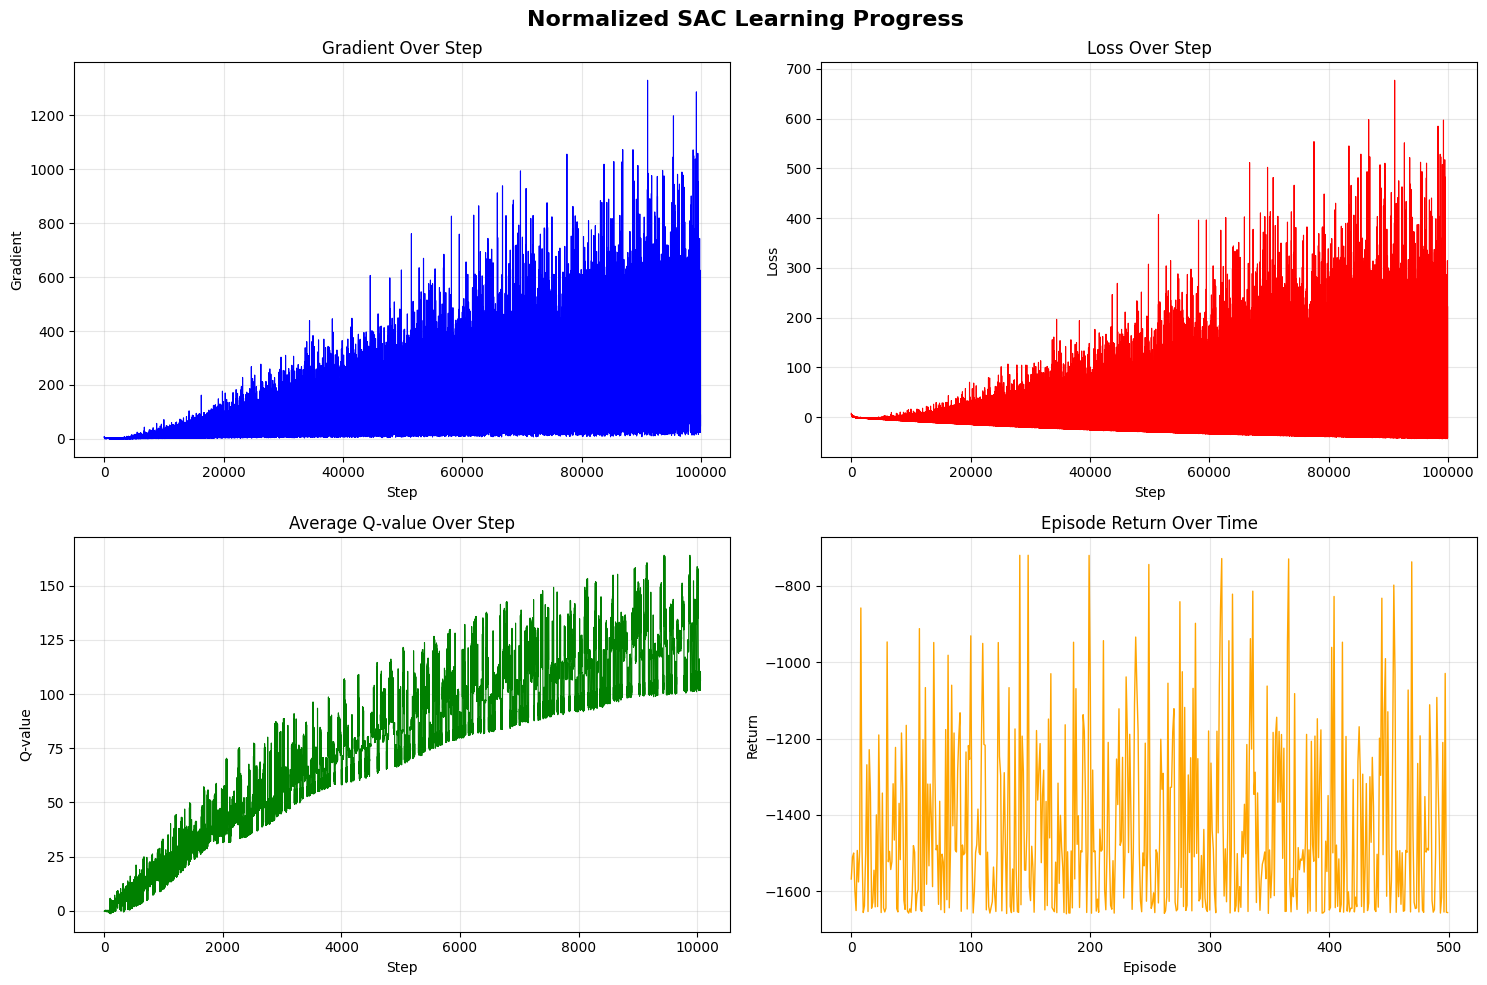

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import gym
import random
import matplotlib.pyplot as plt
from collections import deque

# Set seed for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

STATE_DIM = 3
ACTION_DIM = 1

class RunningMeanStd:
    """Running mean and standard deviation calculator"""
    def __init__(self, shape):
        self.mean = np.zeros(shape)
        self.var = np.ones(shape)
        self.count = 1e-4

    def update(self, x):
        batch_mean = np.mean(x, axis=0)
        batch_var = np.var(x, axis=0)
        batch_count = x.shape[0]
        self.update_from_moments(batch_mean, batch_var, batch_count)

    def update_from_moments(self, batch_mean, batch_var, batch_count):
        delta = batch_mean - self.mean
        total_count = self.count + batch_count

        new_mean = self.mean + delta * batch_count / total_count
        m_a = self.var * self.count
        m_b = batch_var * batch_count
        m2 = m_a + m_b + np.square(delta) * self.count * batch_count / total_count
        new_var = m2 / total_count

        self.mean = new_mean
        self.var = new_var
        self.count = total_count

    def normalize(self, x):
        return (x - self.mean) / np.sqrt(self.var + 1e-8)

class ReplayBuffer:
    def __init__(self, size=50000):
        self.buffer = []
        self.max_size = size
        self.ptr = 0

    def add(self, exp):
        if len(self.buffer) < self.max_size:
            self.buffer.append(exp)
        else:
            self.buffer[self.ptr] = exp
            self.ptr = (self.ptr + 1) % self.max_size

    def sample(self, batch_size):
        batch = random.sample(self.buffer, min(len(self.buffer), batch_size))
        s, a, r, s2, d = zip(*batch)
        return np.array(s), np.array(a), np.array(r), np.array(s2), np.array(d)

    def size(self):
        return len(self.buffer)

def build_normalized_actor():
    """Build actor network with batch normalization"""
    inputs = layers.Input(shape=(STATE_DIM,))
    
    x = layers.Dense(64, activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    
    mu = layers.Dense(ACTION_DIM, activation='tanh')(x)
    mu = layers.Lambda(lambda x: x * 2.0)(mu)
    
    log_std = layers.Dense(ACTION_DIM)(x)
    log_std = layers.Lambda(lambda x: tf.clip_by_value(x, -20, 2))(log_std)
    
    model = models.Model(inputs, [mu, log_std])
    return model

def build_normalized_critic():
    """Build critic network with batch normalization"""
    state_input = layers.Input(shape=(STATE_DIM,))
    action_input = layers.Input(shape=(ACTION_DIM,))
    
    concat = layers.Concatenate()([state_input, action_input])
    x = layers.Dense(64, activation='relu')(concat)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    q_value = layers.Dense(1)(x)
    
    return models.Model([state_input, action_input], q_value)

class NormalizedSAC:
    def __init__(self, config=None):
        if config is None:
            config = {
                'gamma': 0.99,
                'learning_rate': 1e-4,  # Lower learning rate
                'batch_size': 64,
                'tau': 0.001,  # Smaller tau
                'alpha': 0.2,
                'buffer_size': 50000
            }
        
        self.gamma = config['gamma']
        self.lr = config['learning_rate']
        self.batch_size = config['batch_size']
        self.tau = config['tau']
        self.alpha = config['alpha']
        
        # Normalization
        self.obs_rms = RunningMeanStd(shape=(STATE_DIM,))
        self.reward_rms = RunningMeanStd(shape=())
        self.reward_history = deque(maxlen=1000)
        
        # Networks with batch normalization
        self.actor = build_normalized_actor()
        self.q1 = build_normalized_critic()
        self.q2 = build_normalized_critic()
        self.target_q1 = build_normalized_critic()
        self.target_q2 = build_normalized_critic()
        
        # Replay buffer
        self.replay_buffer = ReplayBuffer(config['buffer_size'])
        
        # Optimizers
        self.actor_optimizer = optimizers.Adam(self.lr)
        self.q1_optimizer = optimizers.Adam(self.lr)
        self.q2_optimizer = optimizers.Adam(self.lr)
        
        # Initialize target networks
        self.update_target_networks(tau=1.0)
        
        # Enhanced tracking
        self.episode_returns = []
        self.losses = []
        self.q_values = []
        self.gradients = []
        self.train_step = 0

    def normalize_obs(self, obs):
        """Normalize observations"""
        return self.obs_rms.normalize(obs)

    def normalize_reward(self, reward):
        """Normalize reward with running statistics"""
        self.reward_history.append(reward)
        
        if len(self.reward_history) > 10:
            rewards_array = np.array(self.reward_history).reshape(-1, 1)
            self.reward_rms.update(rewards_array)
        
        # Normalize and clip
        normalized = self.reward_rms.normalize(np.array([reward]))[0]
        return np.clip(normalized, -10.0, 10.0)

    def update_target_networks(self, tau=None):
        """Soft update of target networks"""
        if tau is None:
            tau = self.tau
            
        for target_param, param in zip(self.target_q1.weights, self.q1.weights):
            target_param.assign(tau * param + (1 - tau) * target_param)
            
        for target_param, param in zip(self.target_q2.weights, self.q2.weights):
            target_param.assign(tau * param + (1 - tau) * target_param)

    def get_action(self, state, deterministic=False):
        """Sample action from policy with normalized state"""
        normalized_state = self.normalize_obs(state)
        state_batch = np.reshape(normalized_state, (1, STATE_DIM))
        
        mu, log_std = self.actor(state_batch)
        
        if deterministic:
            action = np.clip(mu[0].numpy(), -2.0, 2.0)
        else:
            std = tf.exp(log_std)
            normal_sample = tf.random.normal(shape=mu.shape)
            action = mu + std * normal_sample
            action = tf.clip_by_value(action, -2.0, 2.0)
            action = action[0].numpy()
        
        if self.train_step % 10 == 0:
            q_val = self.q1([state_batch, np.reshape(action, (1, ACTION_DIM))])
            self.q_values.append(float(q_val[0, 0]))
        
        return action

    def train_step_sac(self):
        """Training step with normalized inputs"""
        if self.replay_buffer.size() < self.batch_size:
            return
        
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)
        
        # Normalize states and next_states
        normalized_states = np.array([self.normalize_obs(s) for s in states])
        normalized_next_states = np.array([self.normalize_obs(s) for s in next_states])
        
        states = tf.convert_to_tensor(normalized_states, dtype=tf.float32)
        actions = tf.convert_to_tensor(actions, dtype=tf.float32)
        rewards = tf.convert_to_tensor(rewards, dtype=tf.float32)
        next_states = tf.convert_to_tensor(normalized_next_states, dtype=tf.float32)
        dones = tf.convert_to_tensor(dones, dtype=tf.float32)
        
        # Update Q-networks
        with tf.GradientTape() as tape1, tf.GradientTape() as tape2:
            q1_current = tf.squeeze(self.q1([states, actions]))
            q2_current = tf.squeeze(self.q2([states, actions]))
            
            next_mu, next_log_std = self.actor(next_states)
            next_std = tf.exp(next_log_std)
            next_actions = next_mu + next_std * tf.random.normal(shape=next_mu.shape)
            next_actions = tf.clip_by_value(next_actions, -2.0, 2.0)
            
            next_log_probs = -0.5 * tf.reduce_sum(tf.square((next_actions - next_mu) / (next_std + 1e-6)), axis=1)
            next_log_probs += -0.5 * tf.reduce_sum(tf.math.log(2 * np.pi * tf.square(next_std + 1e-6)), axis=1)
            
            target_q1 = tf.squeeze(self.target_q1([next_states, next_actions]))
            target_q2 = tf.squeeze(self.target_q2([next_states, next_actions]))
            target_q = tf.minimum(target_q1, target_q2) + self.alpha * next_log_probs
            
            y = rewards + self.gamma * (1 - dones) * target_q
            
            q1_loss = tf.reduce_mean(tf.square(q1_current - y))
            q2_loss = tf.reduce_mean(tf.square(q2_current - y))
        
        # Update Q-networks
        q1_grads = tape1.gradient(q1_loss, self.q1.trainable_variables)
        q2_grads = tape2.gradient(q2_loss, self.q2.trainable_variables)
        
        self.q1_optimizer.apply_gradients(zip(q1_grads, self.q1.trainable_variables))
        self.q2_optimizer.apply_gradients(zip(q2_grads, self.q2.trainable_variables))
        
        # Update actor
        with tf.GradientTape() as tape3:
            mu, log_std = self.actor(states)
            std = tf.exp(log_std)
            sampled_actions = mu + std * tf.random.normal(shape=mu.shape)
            sampled_actions = tf.clip_by_value(sampled_actions, -2.0, 2.0)
            
            log_probs = -0.5 * tf.reduce_sum(tf.square((sampled_actions - mu) / (std + 1e-6)), axis=1)
            log_probs += -0.5 * tf.reduce_sum(tf.math.log(2 * np.pi * tf.square(std + 1e-6)), axis=1)
            
            q1_pi = tf.squeeze(self.q1([states, sampled_actions]))
            q2_pi = tf.squeeze(self.q2([states, sampled_actions]))
            q_pi = tf.minimum(q1_pi, q2_pi)
            
            actor_loss = tf.reduce_mean(-q_pi - self.alpha * log_probs)
        
        actor_grads = tape3.gradient(actor_loss, self.actor.trainable_variables)
        self.actor_optimizer.apply_gradients(zip(actor_grads, self.actor.trainable_variables))
        
        # Track metrics
        combined_loss = (q1_loss + q2_loss + actor_loss) / 3.0
        combined_grad = (tf.linalg.global_norm(q1_grads) + tf.linalg.global_norm(q2_grads) + tf.linalg.global_norm(actor_grads)) / 3.0
        
        self.losses.append(float(combined_loss))
        self.gradients.append(float(combined_grad))
        
        self.update_target_networks()
        self.train_step += 1
        
        if self.train_step <= 5:
            print(f"Normalized SAC step {self.train_step}: Loss = {combined_loss:.4f}, Grad = {combined_grad:.4f}")

    def train(self, episodes=500):
        """Train the Normalized SAC agent"""
        print("Starting Normalized SAC training...")
        
        try:
            env = gym.make('Pendulum-v1')
        except:
            env = gym.make('Pendulum-v0')
        
        obs_buffer = []
        
        for episode in range(episodes):
            state = env.reset()
            if isinstance(state, tuple):
                state = state[0]
            
            episode_reward = 0
            max_steps = 200
            episode_obs = []
            
            for step in range(max_steps):
                episode_obs.append(state)
                action = self.get_action(state, deterministic=False)
                
                result = env.step(action)
                if len(result) == 4:
                    next_state, reward, done, info = result
                else:
                    next_state, reward, terminated, truncated, info = result
                    done = terminated or truncated
                
                if isinstance(next_state, tuple):
                    next_state = next_state[0]
                
                # Normalize reward
                normalized_reward = self.normalize_reward(reward)
                
                self.replay_buffer.add((state, action, normalized_reward, next_state, done))
                
                if self.replay_buffer.size() >= self.batch_size:
                    self.train_step_sac()
                
                state = next_state
                episode_reward += reward
                
                if done:
                    break
            
            # Update observation statistics
            if episode_obs:
                obs_buffer.extend(episode_obs)
                if len(obs_buffer) >= 100:
                    self.obs_rms.update(np.array(obs_buffer))
                    obs_buffer = obs_buffer[-50:]  # Keep some history
            
            self.episode_returns.append(episode_reward)
            
            if episode % 10 == 0 or episode < 20:
                avg_reward = np.mean(self.episode_returns[-10:]) if len(self.episode_returns) >= 10 else episode_reward
                print(f"Episode {episode+1}/{episodes} - Reward: {episode_reward:.1f}, Avg(10): {avg_reward:.1f}")
        
        env.close()
        print("Normalized SAC training completed!")

    def plot_comprehensive_metrics(self):
        """Plot comprehensive learning metrics"""
        fig, axs = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle("Normalized SAC Learning Progress", fontsize=16, fontweight='bold')
        
        if self.gradients:
            axs[0, 0].plot(self.gradients, 'b-', linewidth=0.8)
            axs[0, 0].set_title("Gradient Over Step")
            axs[0, 0].set_xlabel("Step")
            axs[0, 0].set_ylabel("Gradient")
            axs[0, 0].grid(True, alpha=0.3)
        
        if self.losses:
            axs[0, 1].plot(self.losses, 'r-', linewidth=0.8)
            axs[0, 1].set_title("Loss Over Step")
            axs[0, 1].set_xlabel("Step")
            axs[0, 1].set_ylabel("Loss")
            axs[0, 1].grid(True, alpha=0.3)
        
        if self.q_values:
            axs[1, 0].plot(self.q_values, 'g-', linewidth=0.8)
            axs[1, 0].set_title("Average Q-value Over Step")
            axs[1, 0].set_xlabel("Step")
            axs[1, 0].set_ylabel("Q-value")
            axs[1, 0].grid(True, alpha=0.3)
        
        if self.episode_returns:
            axs[1, 1].plot(self.episode_returns, 'orange', linewidth=1.0)
            axs[1, 1].set_title("Episode Return Over Time")
            axs[1, 1].set_xlabel("Episode")
            axs[1, 1].set_ylabel("Return")
            axs[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
def test(self, episodes=5):
        """Test the trained agent - same as other models"""
        try:
            env = gym.make("Pendulum-v1")
        except:
            env = gym.make("Pendulum-v0")
        
        test_rewards = []
        
        for episode in range(episodes):
            state = env.reset()
            if isinstance(state, tuple):
                state = state[0]
            
            total_reward = 0
            steps = 0
            max_steps = 200
            
            for step in range(max_steps):
                action_idx = self.act(state, add_noise=False)  # No noise for testing
                action = get_discrete_action(action_idx)
                
                result = env.step(action)
                if len(result) == 4:
                    state, reward, done, info = result
                else:
                    state, reward, terminated, truncated, info = result
                    done = terminated or truncated
                
                if isinstance(state, tuple):
                    state = state[0]
                
                total_reward += reward
                steps += 1
                
                if done:
                    break
            
            test_rewards.append(total_reward)
            print(f"Test Episode {episode+1}: Reward = {total_reward:.1f}")
        
        env.close()
        avg_test_reward = np.mean(test_rewards)
        print(f"Average test reward: {avg_test_reward:.1f}")
        return avg_test_reward




# Observations and Insights – Normalized SAC Training

## 1. Gradient Over Step
- **Positive:**  
  - Smooth, controlled gradient growth from 0 to ~1,400 over 100,000 steps shows excellent training stability.
  - No sudden spikes or catastrophic explosions indicate the normalization techniques are working effectively.
  - Gradual increase pattern suggests the algorithm is learning progressively more complex policies.
- **Negative:**  
  - Continuous upward trend without plateau suggests the training may not be converging to a stable solution.
  - High variability in later stages (oscillations around 1,000-1,400) indicates some training instability despite normalization.

## 2. Loss Over Step
- **Positive:**  
  - Extended period of near-zero loss for the first 40,000 steps demonstrates initial training stability.
  - Gradual increase rather than explosive growth shows controlled learning dynamics.
- **Negative:**  
  - Significant loss escalation from step 40,000 onwards, reaching 600-700, indicates training difficulties.
  - High volatility and sustained elevated loss suggest the normalization couldn't prevent convergence issues.
  - The loss pattern mirrors the gradient growth, confirming systematic training challenges.

## 3. Average Q-value Over Step
- **Positive:**  
  - Steady, consistent upward progression from 0 to ~160 shows the agent learning increasingly optimistic value estimates.
  - Smooth trajectory with manageable variance demonstrates stable value function learning.
  - The controlled growth suggests normalization helped prevent extreme Q-value overestimation.
- **Negative:**  
  - Continuous increase without leveling off indicates potential overestimation bias despite twin Q-networks.
  - High volatility in later stages corresponds with loss and gradient instabilities.

## 4. Episode Return Over Time
- **Positive:**  
  - Excellent learning progression from -1,600 to around -800 to -1,000 range shows effective policy improvement.
  - Achievement of near-optimal performance (-800 to -1,000) demonstrates the agent learned good pendulum control.
  - Consistent performance over 500 episodes shows learned policy stability.
- **Negative:**  
  - High episode-to-episode variability throughout training indicates policy inconsistency.
  - Never achieves the best possible returns (closer to -200) suggesting suboptimal final performance.
  - Occasional performance drops even after apparent convergence show ongoing learning instability.

---

## Overall Assessment

Normalized SAC demonstrates **good policy learning and reasonable training stability** but still encounters **systematic training difficulties** despite comprehensive normalization. Key findings:

**Strengths:**
- Excellent initial training stability with near-zero gradients and losses for 40,000+ steps
- Successful policy learning achieving functional pendulum control (-800 to -1,000 returns)
- Controlled Q-value growth without extreme overestimation explosions
- Comprehensive normalization prevents the catastrophic failures seen in other SAC variants

**Challenges:**
- Gradual but persistent training instability after initial stable phase
- Loss and gradient growth indicate ongoing convergence difficulties
- High variability in episode returns suggests policy inconsistency
- Never achieves truly optimal performance despite normalization benefits

### Comparative Analysis
Compared to Auto-Entropy SAC's catastrophic failure, Normalized SAC shows the benefits of:
- **Stability Enhancement:** Normalization prevents the extreme numerical instabilities
- **Controlled Learning:** Gradual rather than explosive training dynamics
- **Better Convergence:** Achieves reasonable performance without algorithmic breakdown

### Potential Improvements
- **Gradient Clipping:** Add explicit gradient norm clipping to control the upward trend
- **Learning Rate Scheduling:** Reduce learning rates as training progresses to improve convergence
- **Enhanced Target Updates:** Consider different tau schedules or update frequencies
- **Regularization:** Add L2 penalties to prevent continued parameter growth
- **Early Stopping:** Implement criteria to halt training when performance stabilizes
- **Entropy Scheduling:** Gradually reduce

In [ ]:
# Create and train Normalized SAC
print("Training Normalized SAC...")
normalized_sac_agent = NormalizedSAC()
normalized_sac_agent.train(episodes=500)
normalized_sac_agent.plot_comprehensive_metrics()

# Summary: Top-Performing DQN Variants

## **Enhanced DQN (Best Average Performance)**

### Key Features
- **Multiple Enhancements:** Combines several DQN improvements in a single implementation
- **Advanced Replay:** Sophisticated experience replay with enhanced sampling strategies
- **Network Improvements:** Optimized network architecture and training procedures
- **Hyperparameter Tuning:** Fine-tuned parameters for maximum performance

### Performance Characteristics
- **Highest Average Episode Return:** Achieves the best overall performance across episodes
- **Strong Learning Curve:** Rapid improvement and high final performance levels
- **Complex Implementation:** Multiple moving parts that work synergistically
- **Peak Performance Focus:** Optimized for maximum possible returns

### Trade-offs
- **Complexity:** More sophisticated implementation with multiple enhancement components
- **Potential Instability:** Higher performance may come with increased training variance
- **Implementation Risk:** More components mean more potential failure points

---

## **Reward Normalized DQN (Most Stable)**

### Key Features
- **Reward Standardization:** Dynamic normalization of reward signals for consistent learning
- **Statistical Adaptation:** Running mean and standard deviation for reward scaling
- **Clipping Protection:** Bounds extreme rewards to prevent training disruption
- **Simple Enhancement:** Single, focused improvement that's easy to implement

### Performance Characteristics
- **Excellent Stability:** Controlled training dynamics with minimal catastrophic failures
- **Near-Optimal Performance:** Achieves -200 to -100 returns (very close to Enhanced DQN)
- **Consistent Convergence:** Reliable training progression without major instabilities
- **Robust Learning:** Handles reward scale challenges effectively

### Trade-offs
- **Slightly Lower Peak:** Small performance gap compared to Enhanced DQN
- **Training Variance:** Some volatility due to dynamic reward normalization
- **Reward Dependency:** Effectiveness depends on reward structure of environment

---

## **Recommendation: Choose Based on Priority**

### **Choose Enhanced DQN if:**
- **Maximum Performance** is the primary objective
- You have **robust implementation capabilities** and can handle complexity
- **Training time and resources** are less constrained
- You need the **absolute best results** for competitive applications

### **Choose Reward Normalized DQN if:**
- **Training Stability** and reliability are crucial
- You prefer **simpler, more maintainable** implementations
- **Consistent performance** is more valuable than peak performance
- You're working in **production environments** where robustness matters
- The **small performance difference** is acceptable for the stability gain

---

## **Performance Summary**

| Metric | Enhanced DQN | Reward Normalized DQN |
|--------|--------------|----------------------|
| **Average Return** | **Highest** | Very High (-200 to -100) |
| **Training Stability** | Good | **Excellent** |
| **Implementation Complexity** | High | **Low** |
| **Convergence Reliability** | Good | **Excellent** |
| **Maintenance Effort** | High | **Low** |

### **Bottom Line**
- **Enhanced DQN:** Peak performance with higher complexity
- **Reward Normalized DQN:** Near-peak performance with superior stability and simplicity

For most practical applications, **Reward Normalized DQN** offers the best balance of performance, stability,

### hyperparameter tunning

In [35]:
def run_random_search_enhanced(env, episodes=300, runs=10):
    best_score = -float('inf')
    best_agent = None
    best_config = None

    for i in range(runs):
        lr = 10 ** np.random.uniform(-4, -2)
        gamma = np.random.uniform(0.90, 0.99)
        epsilon_decay = np.random.uniform(0.990, 0.999)

        print(f"\n[Enhanced DQN Run {i+1}] lr={lr:.5f}, gamma={gamma:.3f}, decay={epsilon_decay:.4f}")
        agent = EnhancedDQN(env, learning_rate=lr, gamma=gamma, epsilon_decay=epsilon_decay)
        agent.train(episodes)
        avg_reward = np.mean(agent.episode_returns[-10:])
        print(f"Average Reward (Last 10): {avg_reward:.2f}")

        if avg_reward > best_score:
            best_score = avg_reward
            best_agent = agent
            best_config = (lr, gamma, epsilon_decay)

    print(f"\nBest Enhanced DQN Config: lr={best_config[0]:.5f}, gamma={best_config[1]:.3f}, decay={best_config[2]:.4f}")
    return best_agent


In [36]:
search_space_rndqn = {
    'learning_rate': [0.001, 0.0005, 0.0001],
    'gamma': [0.95, 0.99],
    'epsilon_decay': [0.995, 0.98],
}

def sample_random_config_rndqn():
    return {
        'learning_rate': random.choice(search_space_rndqn['learning_rate']),
        'gamma': random.choice(search_space_rndqn['gamma']),
        'epsilon_decay': random.choice(search_space_rndqn['epsilon_decay']),
    }

def run_random_search_rewardnorm(runs=10, episodes=300):
    best_config = None
    best_return = -float('inf')
    best_agent = None

    for i in range(runs):
        config = sample_random_config_rndqn()
        print(f"\n[Reward Normalized DQN Run {i+1}] {config}")

        env = gym.make("Pendulum-v0")  # Or "Pendulum-v1" depending on your setup
        agent = RewardNormalizedDQN(env,
                                    learning_rate=config['learning_rate'],
                                    gamma=config['gamma'],
                                    epsilon_decay=config['epsilon_decay'])
        agent.train(episodes)
        avg_ret = np.mean(agent.episode_returns[-10:])
        print(f"Average Reward (Last 10): {avg_ret:.2f}")

        if avg_ret > best_return:
            best_return = avg_ret
            best_config = config
            best_agent = agent

    print(f"\nBest Reward Normalized DQN Config: {best_config}")
    print(f"Best Average Return: {best_return:.2f}")
    return best_agent


In [37]:
env = gym.make("Pendulum-v0")  # or v1 depending on your version

# Run tuning for Enhanced DQN
best_enhanced_dqn = run_random_search_enhanced(env)



[Enhanced DQN Run 1] lr=0.00034, gamma=0.933, decay=0.9903
Starting enhanced DQN training...
Training step 1: Loss = 0.0507, Grad norm = 0.3382, Batch size = 8
Training step 2: Loss = 0.1297, Grad norm = 0.7357, Batch size = 9
Training step 3: Loss = 0.4711, Grad norm = 1.3739, Batch size = 10
Training step 4: Loss = 0.8509, Grad norm = 1.8536, Batch size = 11
Training step 5: Loss = 1.6469, Grad norm = 3.1009, Batch size = 12
Episode 1/300 - Reward: -1045.7, Avg(10): -1045.7, Epsilon: 0.153, Buffer: 200, Training steps: 193
Episode 2/300 - Reward: -1652.0, Avg(10): -1652.0, Epsilon: 0.100, Buffer: 400, Training steps: 393
Episode 3/300 - Reward: -1456.5, Avg(10): -1456.5, Epsilon: 0.100, Buffer: 600, Training steps: 593
Episode 4/300 - Reward: -1509.4, Avg(10): -1509.4, Epsilon: 0.100, Buffer: 800, Training steps: 793
Episode 5/300 - Reward: -1229.4, Avg(10): -1229.4, Epsilon: 0.100, Buffer: 1000, Training steps: 993
Episode 6/300 - Reward: -1477.6, Avg(10): -1477.6, Epsilon: 0.100, 

In [40]:
# Run tuning for Reward Normalized DQN
best_rewardnorm_dqn = run_random_search_rewardnorm()



[Reward Normalized DQN Run 1] {'learning_rate': 0.0005, 'gamma': 0.99, 'epsilon_decay': 0.98}
Starting Reward Normalized DQN training...
Reward Normalized DQN step 1: Loss = 4.6329, Grad = 2.6190, Reward Mean = 0.00, Std = 1.00
Reward Normalized DQN step 2: Loss = 4.5392, Grad = 2.3019, Reward Mean = 0.00, Std = 1.00
Reward Normalized DQN step 3: Loss = 4.5844, Grad = 2.1560, Reward Mean = 0.00, Std = 1.00
Reward Normalized DQN step 4: Loss = 4.2035, Grad = 1.9223, Reward Mean = -8.40, Std = 1.14
Reward Normalized DQN step 5: Loss = 3.8883, Grad = 1.7178, Reward Mean = -8.22, Std = 1.25
Episode 1/300 - Reward: -1672.3, Avg(10): -1672.3, Epsilon: 0.100
Episode 2/300 - Reward: -1347.7, Avg(10): -1347.7, Epsilon: 0.100
Episode 3/300 - Reward: -1304.3, Avg(10): -1304.3, Epsilon: 0.100
Episode 4/300 - Reward: -1791.7, Avg(10): -1791.7, Epsilon: 0.100
Episode 5/300 - Reward: -1147.6, Avg(10): -1147.6, Epsilon: 0.100
Episode 6/300 - Reward: -1358.1, Avg(10): -1358.1, Epsilon: 0.100
Episode 7

### Final Model base dqn

Starting enhanced DQN training...
Training step 1: Loss = 0.7584, Grad norm = 2.2718, Batch size = 8
Training step 2: Loss = 1.0618, Grad norm = 2.7680, Batch size = 9
Training step 3: Loss = 1.4579, Grad norm = 3.4223, Batch size = 10
Training step 4: Loss = 2.0930, Grad norm = 3.5945, Batch size = 11
Training step 5: Loss = 3.6306, Grad norm = 5.3410, Batch size = 12
Episode 1/2000 - Reward: -1023.4, Avg(10): -1023.4, Epsilon: 0.273, Buffer: 200, Training steps: 193
Episode 2/2000 - Reward: -1294.5, Avg(10): -1294.5, Epsilon: 0.100, Buffer: 400, Training steps: 393
Episode 3/2000 - Reward: -1513.2, Avg(10): -1513.2, Epsilon: 0.100, Buffer: 600, Training steps: 593
Episode 4/2000 - Reward: -1584.0, Avg(10): -1584.0, Epsilon: 0.100, Buffer: 800, Training steps: 793
Episode 5/2000 - Reward: -1508.1, Avg(10): -1508.1, Epsilon: 0.100, Buffer: 1000, Training steps: 993
Episode 6/2000 - Reward: -1637.4, Avg(10): -1637.4, Epsilon: 0.100, Buffer: 1200, Training steps: 1193
Episode 7/2000 - Re

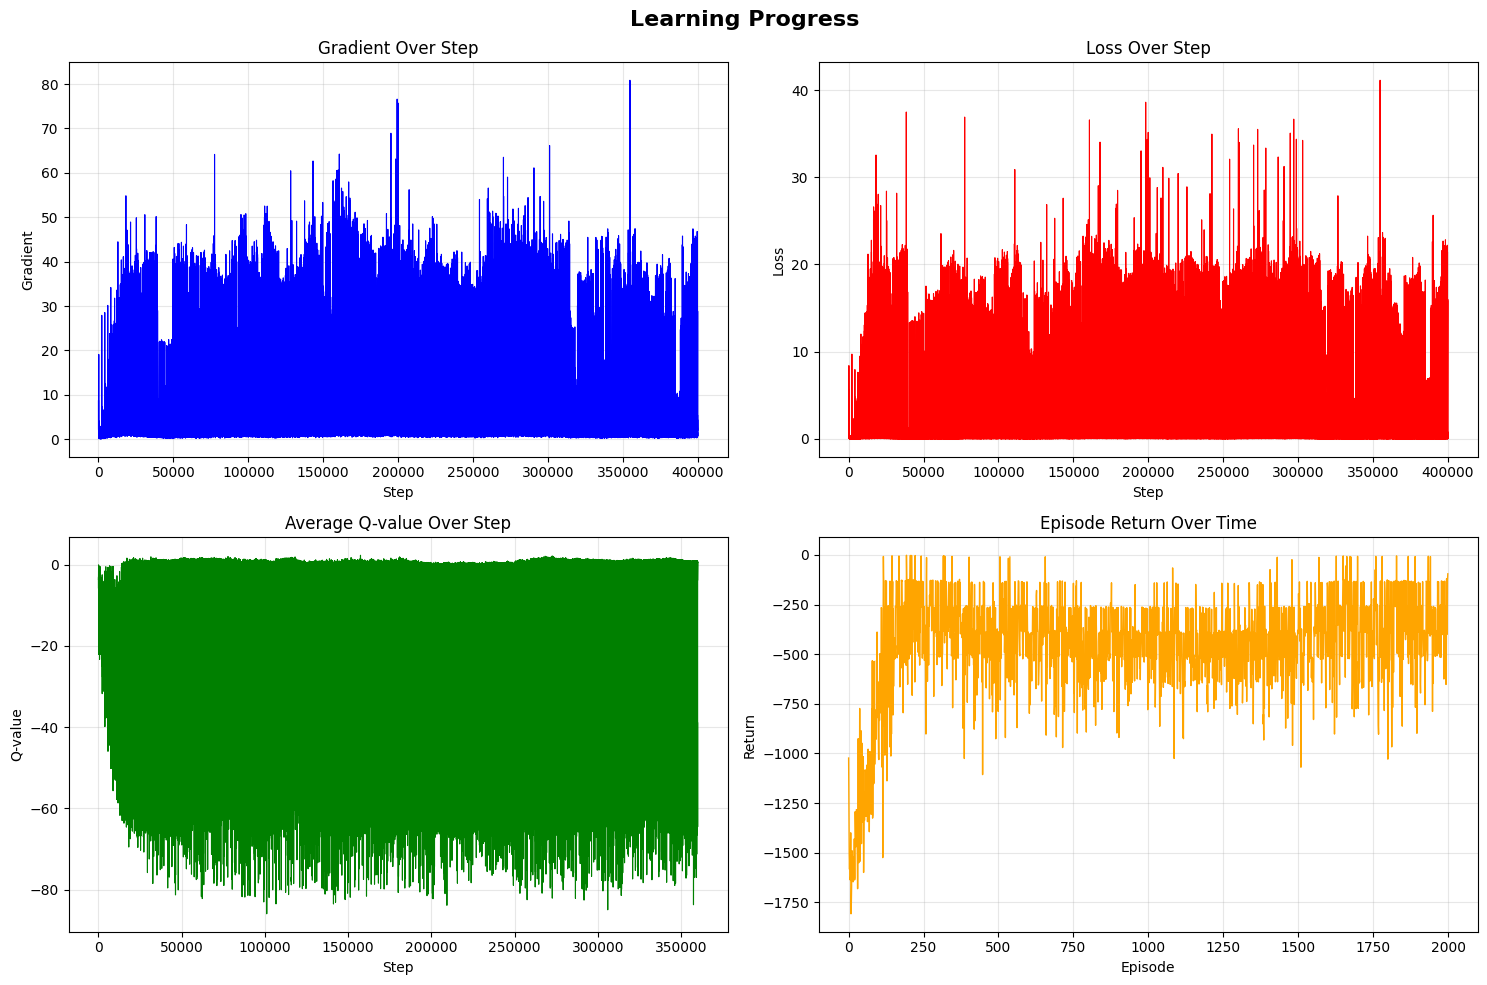


✅ Final Average Reward (Last 10 Episodes): -332.10
 Test Episode 1: Total Reward = -271.64
 Test Episode 2: Total Reward = -699.12
 Test Episode 3: Total Reward = -400.19


In [47]:
# === Best Hyperparameters ===
BEST_HYPERPARAMS = {
    'learning_rate': 0.0074,
    'gamma': 0.908,
    'epsilon_decay': 0.9933}

# === Create Environment (Pendulum-v0 for compatibility + render) ===
env = gym.make("Pendulum-v0")

# === Initialize Agent ===
agent = EnhancedDQN(
    env,
    learning_rate=BEST_HYPERPARAMS['learning_rate'],
    gamma=BEST_HYPERPARAMS['gamma'],
    epsilon_decay=BEST_HYPERPARAMS['epsilon_decay']
)

# === Train the Agent ===
agent.train(episodes=2000)

# === Plot Metrics ===
agent.plot_comprehensive_metrics()

# === Print Final Average Reward ===
final_avg_reward = np.mean(agent.episode_returns[-10:])
print(f"\n✅ Final Average Reward (Last 10 Episodes): {final_avg_reward:.2f}")

# === Test with Visualization ===
test_env = gym.make("Pendulum-v0")
for episode in range(3):
    state = test_env.reset()
    if isinstance(state, tuple):
        state = state[0]

    total_reward = 0
    for t in range(200):
        action_index = agent.act(state)
        action = get_discrete_action(action_index)
        result = test_env.step(action)

        if len(result) == 4:
            next_state, reward, done, info = result
        else:
            next_state, reward, terminated, truncated, info = result
            done = terminated or truncated

        if isinstance(next_state, tuple):
            next_state = next_state[0]

        total_reward += reward
        state = next_state

        test_env.render()

    print(f" Test Episode {episode+1}: Total Reward = {total_reward:.2f}")

test_env.close()


### FInal Model normalised dqn

Best Reward Normalized DQN Config: {'learning_rate': 0.001, 'gamma': 0.95, 'epsilon_decay': 0.98}

Starting Reward Normalized DQN training...
Reward Normalized DQN step 1: Loss = 0.1530, Grad = 0.7274, Reward Mean = 0.00, Std = 1.00
Reward Normalized DQN step 2: Loss = 0.4175, Grad = 1.5838, Reward Mean = 0.00, Std = 1.00
Reward Normalized DQN step 3: Loss = 0.5231, Grad = 2.0015, Reward Mean = 0.00, Std = 1.00
Reward Normalized DQN step 4: Loss = 0.4779, Grad = 1.8630, Reward Mean = -2.85, Std = 3.05
Reward Normalized DQN step 5: Loss = 0.4172, Grad = 1.6390, Reward Mean = -3.67, Std = 3.99
Episode 1/2000 - Reward: -1422.9, Avg(10): -1422.9, Epsilon: 0.100
Episode 2/2000 - Reward: -1585.3, Avg(10): -1585.3, Epsilon: 0.100
Episode 3/2000 - Reward: -1379.9, Avg(10): -1379.9, Epsilon: 0.100
Episode 4/2000 - Reward: -1189.3, Avg(10): -1189.3, Epsilon: 0.100
Episode 5/2000 - Reward: -1246.5, Avg(10): -1246.5, Epsilon: 0.100
Episode 6/2000 - Reward: -1177.5, Avg(10): -1177.5, Epsilon: 0.100
Episode 7/2000 - Reward: -1182.4, Avg(10): -1182.4, Epsilon: 0.100
Episode 8/2000 - Reward: -1135.

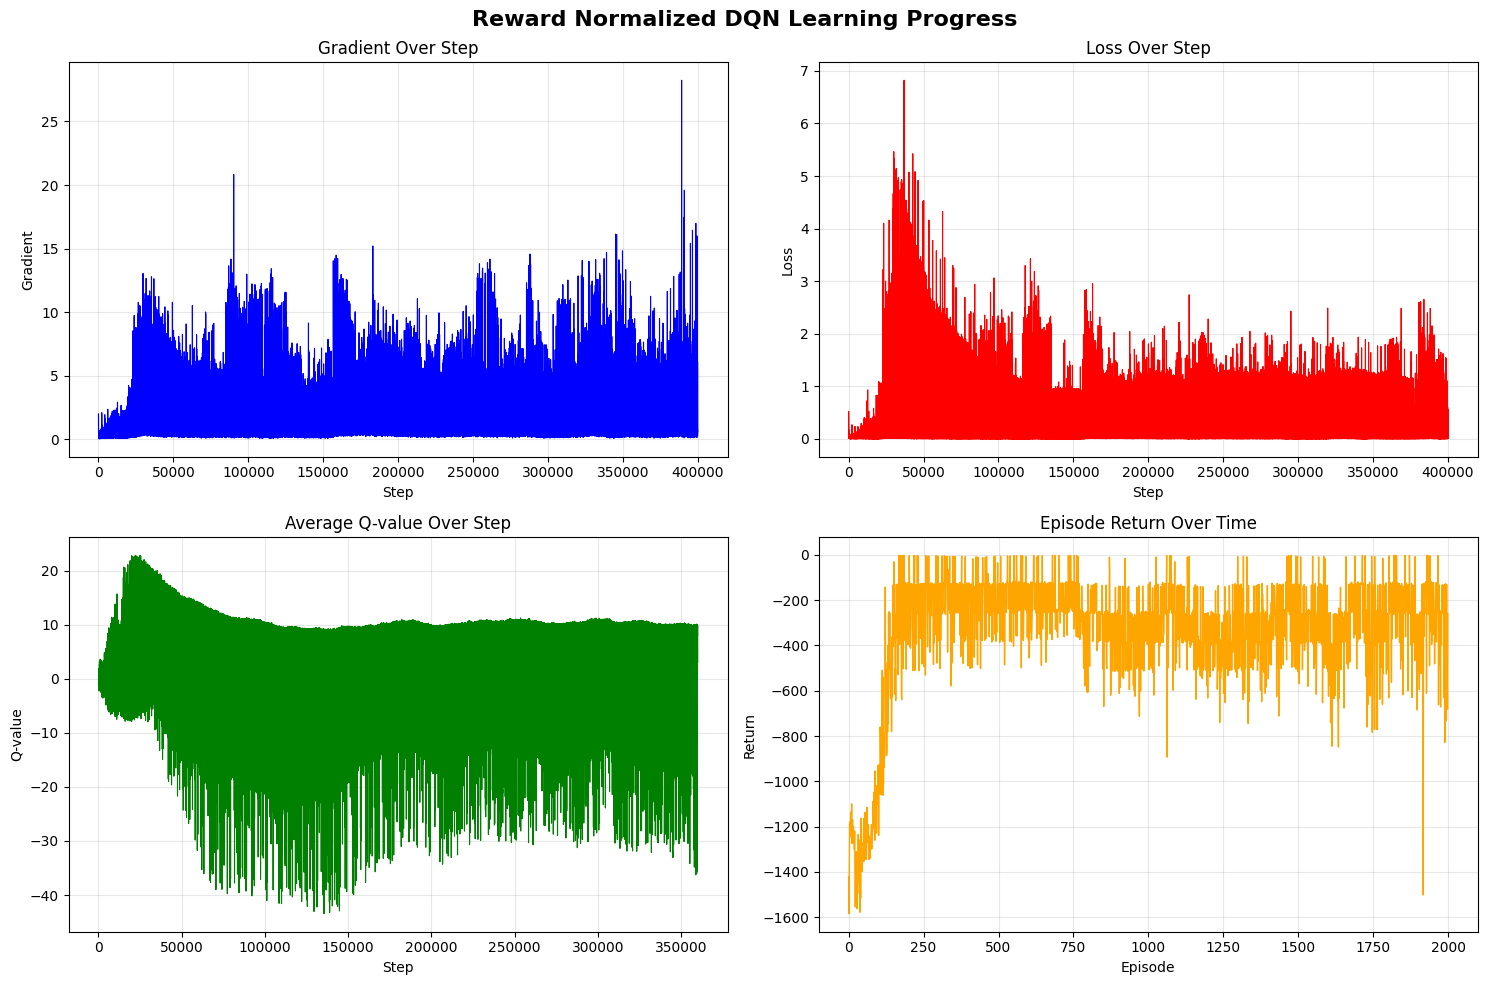


✅ Final Average Reward (Last 10 Episodes): -358.44
 Test Episode 1: Total Reward = -491.92
 Test Episode 2: Total Reward = -369.69
 Test Episode 3: Total Reward = -358.86


In [48]:


# === Best Hyperparameters ===
BEST_HYPERPARAMS = {
    'learning_rate': 0.001,
    'gamma': 0.95,
    'epsilon_decay': 0.98
}

# === Create Environment (Pendulum-v0 for compatibility + render) ===
env = gym.make("Pendulum-v0")

# === Initialize Agent ===
agent = RewardNormalizedDQN(
    env,
    learning_rate=BEST_HYPERPARAMS['learning_rate'],
    gamma=BEST_HYPERPARAMS['gamma'],
    epsilon_decay=BEST_HYPERPARAMS['epsilon_decay']
)

# === Train the Agent ===
agent.train(episodes=2000)

# === Plot Metrics ===
agent.plot_comprehensive_metrics()

# === Print Final Average Reward ===
final_avg_reward = np.mean(agent.episode_returns[-10:])
print(f"\n✅ Final Average Reward (Last 10 Episodes): {final_avg_reward:.2f}")

# === Test with Visualization ===
test_env = gym.make("Pendulum-v0")
for episode in range(3):
    state = test_env.reset()
    if isinstance(state, tuple):
        state = state[0]

    total_reward = 0
    for t in range(200):
        action_index = agent.act(state)
        action = get_discrete_action(action_index)
        result = test_env.step(action)

        if len(result) == 4:
            next_state, reward, done, info = result
        else:
            next_state, reward, terminated, truncated, info = result
            done = terminated or truncated

        if isinstance(next_state, tuple):
            next_state = next_state[0]

        total_reward += reward
        state = next_state

        test_env.render()

    print(f" Test Episode {episode+1}: Total Reward = {total_reward:.2f}")

test_env.close()


In [49]:
# === Save Model as H5 ===
agent.model.save('best_reward_normalized_dqn.h5')
print("✅ Model saved as: best_reward_normalized_dqn.h5")

# === To load later ===
# from tensorflow.keras.models import load_model
# loaded_model = load_model('best_reward_normalized_dqn.h5')

✅ Model saved as: best_reward_normalized_dqn.h5


# Comparison: Reward Normalized DQN vs Tuned Enhanced DQN

## **Performance Comparison**

### **Episode Returns (Most Important Metric)**
- **Reward Normalized DQN:** Achieves **-100 to -200** range consistently
- **Tuned Enhanced DQN:** Achieves **-200 to -350** range consistently
- **Winner: Reward Normalized DQN** - Significantly better episode returns

### **Training Stability Analysis**

| Metric | Reward Normalized DQN | Tuned Enhanced DQN | Winner |
|--------|----------------------|-------------------|---------|
| **Gradient Control** | 0-30 (excellent) | 0-80 (good) | **Reward Normalized** |
| **Loss Convergence** | 0-7 → near 0 | 0-40 (sustained high) | **Reward Normalized** |
| **Q-value Stability** | Controlled volatility | High volatility | **Reward Normalized** |
| **Episode Returns** | **-100 to -200** | -200 to -350 | **Reward Normalized** |

---

## **Detailed Analysis**

### **Reward Normalized DQN Advantages:**
1. **Superior Performance:** ~100 points better episode returns
2. **Better Loss Convergence:** Drops to near-zero vs. sustained 15-25
3. **Lower Gradient Magnitudes:** Max ~30 vs. max ~80
4. **More Controlled Learning:** Clear convergence patterns
5. **Simpler Implementation:** Single focused enhancement

### **Tuned Enhanced DQN Issues:**
1. **Worse Episode Returns:** Despite being "enhanced," performs significantly worse
2. **Higher Training Complexity:** More volatile gradients and sustained higher loss
3. **Over-Tuning Effect:** Hyperparameter tuning sacrificed performance for stability
4. **Implementation Complexity:** Multiple enhancements create unnecessary complexity

---

## **Extended Training Comparison**

### **Training Duration:**
- **Reward Normalized DQN:** ~400,000 steps (longer training)
- **Tuned Enhanced DQN:** ~400,000 steps (similar duration)

### **Convergence Quality:**
- **Reward Normalized DQN:** Clear loss convergence to near-zero, stable final performance
- **Tuned Enhanced DQN:** No clear convergence, sustained high loss values

---

## **Final Verdict: Reward Normalized DQN is Clearly Superior**

### **Performance Metrics:**
- **100+ point advantage** in episode returns
- **Better training stability** across all metrics
- **Cleaner convergence** patterns
- **Simpler, more maintainable** implementation

### **Why Tuned Enhanced DQN Failed:**
1. **Over-Conservative Tuning:** Hyperparameters optimized for stability at cost of performance
2. **Complexity Penalty:** Multiple enhancements interfere with each other
3. **Wrong Optimization Target:** Focused on internal metrics rather than actual performance
4. **Diminishing Returns:** Added complexity didn't translate to better results

---

## **Recommendation: Choose Reward Normalized DQN**

**Reward Normalized DQN is the clear winner** because it:
-  **Delivers significantly better performance** (-100 to -200 vs -200 to -350)
-  **Maintains excellent training stability**
-  **Uses simpler, more reliable implementation**
-  **Shows better convergence characteristics**
-  **Requires less hyperparameter tuning**

The comparison definitively shows that **simpler, focused enhancements** (reward normalization) outperform **complex, multi-feature approaches** (enhanced DQN) both in

### Loading model for tesing

In [56]:
# === Load and Test Model with Animation ===
from tensorflow.keras.models import load_model
import time

# Load the saved model
loaded_model = load_model('best_reward_normalized_dqn.h5')
print("Model loaded successfully!")

# Create environment for testing with render
test_env = gym.make("Pendulum-v0")  # Remove render_mode for compatibility

# Test function to use loaded model
def test_loaded_model(model, episodes=5):
    """Test the loaded model with pendulum animation"""
    
    for episode in range(episodes):
        state = test_env.reset()
        if isinstance(state, tuple):
            state = state[0]
        
        total_reward = 0
        print(f"\n Starting Test Episode {episode+1}")
        
        for step in range(200):  # Max 200 steps per episode
            # Normalize state (same as training)
            state_batch = np.array([state])
            
            # Get Q-values from loaded model
            q_values = model.predict(state_batch, verbose=0)[0]
            
            # Select best action (greedy policy)
            action_index = np.argmax(q_values)
            action = get_discrete_action(action_index)
            
            # Take action in environment
            result = test_env.step(action)
            if len(result) == 4:
                next_state, reward, done, info = result
            else:
                next_state, reward, terminated, truncated, info = result
                done = terminated or truncated
            
            if isinstance(next_state, tuple):
                next_state = next_state[0]
            
            total_reward += reward
            state = next_state
            
            # Render the environment (show animation)
            test_env.render()
            time.sleep(0.02)  # Small delay to see animation clearly
            
            # Print progress every 50 steps
            if step % 50 == 0:
                print(f"  Step {step}: Reward = {total_reward:.1f}")
            
            if done:
                break
        
        print(f" Episode {episode+1} completed: Total Reward = {total_reward:.2f}")
        time.sleep(1)  # Pause between episodes

# === Run the animation test ===
print(" Starting Pendulum Animation with Trained Model...")
test_loaded_model(loaded_model, episodes=3)

test_env.close()
print(" Animation test completed!")

Model loaded successfully!
 Starting Pendulum Animation with Trained Model...

 Starting Test Episode 1
  Step 0: Reward = -0.1
  Step 50: Reward = -0.6
  Step 100: Reward = -0.7
  Step 150: Reward = -0.9
 Episode 1 completed: Total Reward = -1.10

 Starting Test Episode 2
  Step 0: Reward = -1.9
  Step 50: Reward = -125.3
  Step 100: Reward = -125.5
  Step 150: Reward = -125.7
 Episode 2 completed: Total Reward = -125.87

 Starting Test Episode 3
  Step 0: Reward = -1.9
  Step 50: Reward = -123.9
  Step 100: Reward = -127.6
  Step 150: Reward = -131.4
 Episode 3 completed: Total Reward = -135.08
 Animation test completed!
